# **Model Tuning Project - ReneWind**

- Student: Alexey Tyurin
- Group: Oct'22 C Sun - MLS Grp B
- Batch: PGP-DSBA-UTA-OCT22-C
- Date: 4/22/2023-5/4/2023

# Problem Statement

## Description
<center><p float="center">
  <img src="https://olympus.mygreatlearning.com/courses/79763/files/5778139/preview?verifier=mkUixA7fKm9LjCjmDdSmwkyKFOVDAKO7LuZRVxaL">

## Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 


## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.


## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

# Load essentials

## Importing necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import time

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To impute missing values
from sklearn.impute import KNNImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To construct a pipeline of machine learning tasks
from imblearn.pipeline import Pipeline

# To tune model, get different metric scores and split data
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (confusion_matrix,
                             make_scorer,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score)


# To suppress the warnings
import warnings

warnings.filterwarnings("ignore")

## Loading the dataset

In [2]:
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')

## User-defined functions

### Combined boxplot and histogram

In [3]:
# functiom to create combined boxplot and histogram
def histogram_boxplot(data, feature, figsize=(10, 5), fmt='{:.1f}', rotation=0,
                      title=None, kde=True, bins=None, step=None, xlabel=None):
    x = data[feature]
    colors = sns.color_palette("Spectral")
    title = title if title else f'Distribution for `{feature}` column'

    x_min, x_max = x.min(), x.max()

    if (bins == None) & (step == None):
        bins = int(3 * np.log(x.nunique())) + 2
    elif bins == None:
        x_min = step * round(x_min / step, 0)
        x_max = step * round(x_max / step, 0) + step
        bins = int((x_max - x_min) / step)

    bw = (x_max - x_min) / bins

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize,
                           gridspec_kw={"height_ratios": (0.3, 0.7)})

    plt.suptitle(title, fontsize=16)
    box = sns.boxplot(data=data, x=feature, ax=ax[0], showmeans=True, color=colors[1])
    hist = sns.histplot(data=data, x=feature, kde=kde, ax=ax[1], color=colors[4], bins=bins)

    ax[0].set_xlabel('')
    ax[1].axvline(x.median(), color="grey", linestyle="-")
    ax[1].axvline(x.mean(), color="darkgreen", linestyle="--")
    ax[1].set_ylabel('Number of observations', fontsize=12)
    if xlabel: ax[1].set_xlabel(xlabel, fontsize=12)

    labels = [fmt.format(x) for x in np.arange(x_min, x_max, bw)]
    ticks =  [x+bw/2 for x in np.arange(x_min, x_max, bw)]

    ax[1].set_xticks(ticks)
    ax[1].set_xticklabels(labels, rotation=rotation)

    plt.show();

### Labeled barplots

In [4]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None, percfmt="{:.1f}%", rnd=0,
                    figsize=(10, 5), xlabel=None, xlo=0, title=None, sort=True, 
                    orient='h'):
    """
    Barplot with percentage at the top

    data: dataframe
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    figsize: size of figure (default (10, 5))
    xlabel: label for x axis
    """

    fig, ax = plt.subplots(figsize=figsize)
    plt.xticks(rotation=xlo, fontsize=14)
    if orient == 'h':
      sns.countplot(data=data, x=feature, palette="Paired",
                    order=data[feature].value_counts().index[:n] if sort else None)
    else:
      sns.countplot(data=data, y=feature, palette="Paired",
                    order=data[feature].value_counts().index[:n] if sort else None)

    # draw lables
    for p in ax.patches:
      if orient == 'h':
        if perc == True:
          label = percfmt.format(100 * p.get_height() / data.shape[0])
        else:
          label = p.get_height()
        ax.annotate(label, (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha="center", va="center", size=11, xytext=(0, 5),
                    textcoords="offset points")
        ax.set_ylabel('Number of cases', fontsize=14)
        if xlabel: ax.set_xlabel(xlabel, fontsize=14)
      else:
        if perc == True:
          label = percfmt.format(100 * p.get_width() / data.shape[0])
        else:
          label = p.get_width()
        ax.annotate(label, (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha="center", va="center", size=11, xytext=(20, 0),
                    textcoords="offset points")
        ax.set_xlabel('Number of cases', fontsize=14)
        if xlabel: ax.set_ylabel(xlabel, fontsize=14)

    if title: plt.title(title, fontsize=16)
    else: plt.title(f'Distribution for `{feature}` column', fontsize=16)

    plt.show()

### Model Performance - compute different metrics and visualize results

In [5]:
# Let's define function to provide metric scores (accuracy, recall, precision, etc.) 
# on train and test set and a function to show confusion matrix 
# so that we do not have use the same code repetitively while evaluating models.
# defining a function to compute different metrics to check performance of 
# a classification model built using sklearn

def specificity_score(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).flatten()
  return (tn)/(tn+fp)

def npv_score(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).flatten()
  return (tn)/(tn+fn)

def model_performance(model, X_train, y_train, X_test, y_test, verbose=True, sets=['Train', 'Test']):
  p_train = model.predict(X_train).astype(bool)
  p_test = model.predict(X_test).astype(bool)
  y_train = np.array(y_train).astype(bool)
  y_test = np.array(y_test).astype(bool)

  cm_train = confusion_matrix(y_train, p_train)
  cm_test = confusion_matrix(y_test, p_test)
  lab_train = np.asarray([["{0:,.0f}".format(item) + "\n{0:.2%}".format(item / cm_train.flatten().sum())] for item in cm_train.flatten()]).reshape(2, 2)
  lab_test  = np.asarray([["{0:,.0f}".format(item) + "\n{0:.2%}".format(item / cm_test.flatten().sum())] for item in cm_test.flatten()]).reshape(2, 2)

  df_perf = pd.DataFrame({'Accuracy':    [accuracy_score(y_train, p_train), accuracy_score(y_test, p_test)],
                          'Precision':   [precision_score(y_train, p_train), precision_score(y_test, p_test)],
                          'Recall':      [recall_score(y_train, p_train), recall_score(y_test, p_test)],
                          'NPV':         [npv_score(y_train, p_train), npv_score(y_test, p_test)],
                          'Specificity': [specificity_score(y_train, p_train), specificity_score(y_test, p_test)],
                          'F1':          [f1_score(y_train, p_train), f1_score(y_test, p_test)]},
                         index=sets)

  if verbose:
    fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(9, 3))

    sns.heatmap(cm_train, annot=lab_train, fmt="", ax=ax[0], annot_kws = {"size": 10})
    sns.heatmap(cm_test, annot=lab_test, fmt="", ax=ax[1], annot_kws = {"size": 10})
    ax[0].set_title(sets[0]+' dataset', fontsize=10)
    ax[0].set_xlabel('Predicted label', fontsize=10)
    ax[0].set_ylabel('True label', fontsize=10)
    ax[1].set_title(sets[1]+' dataset', fontsize=10)
    ax[1].set_xlabel('Predicted label', fontsize=10)
    ax[1].set_ylabel('True label', fontsize=10)
    plt.show();

    print('\033[1m' + 'Model performance:' + '\033[0m')
    display(df_perf.style.set_table_styles([dict(selector="th", props=[('max-width', '75px')])]).format('{:.2%}'))
  
  return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [6]:
# Type of scoring used to compare parameter combinations
scorer = make_scorer(recall_score)


### Defining 7 classifiers to be used for cross-validation and hyperparameter tuning

In [7]:
models_grid = [('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42),
                {'max_depth': np.arange(2, 6),
                 'min_samples_leaf': [1, 4, 7], 
                 'max_leaf_nodes' : [10, 15],
                 'min_impurity_decrease': [0.0001, 0.001]}),
               ('LogisticRegression', LogisticRegression(random_state=42),
               {'C': np.arange(0.1, 1.1, 0.1)}),
               ('RandomForestClassifier', RandomForestClassifier(random_state=42),
               {'n_estimators': [200, 250, 300],
                'min_samples_leaf': np.arange(1, 4),
                'max_features': [np.arange(0.3, 0.6, 0.1), 'sqrt'],
                'max_samples': np.arange(0.4, 0.7, 0.1)
               }),
               ('BaggingClassifier', BaggingClassifier(random_state=42),
               {'max_samples': [0.8, 0.9, 1.0], 
                'max_features': [0.7, 0.8, 0.9],
                'n_estimators' : [30, 50, 70],
               }),
               ('AdaBoostClassifier', AdaBoostClassifier(random_state=42),
               {'n_estimators': [100, 150, 200],
                'learning_rate': [0.2, 0.05],
                'base_estimator': [DecisionTreeClassifier(max_depth=1, random_state=42), 
                                   DecisionTreeClassifier(max_depth=2, random_state=42), 
                                   DecisionTreeClassifier(max_depth=3, random_state=42)],
               }),
               ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42),
               {'n_estimators': np.arange(100, 150, 25),
                'learning_rate': [0.2, 0.05, 1],
                'subsample': [0.5, 0.7],
                'max_features': [0.5, 0.7]
               }),
               ('XGBClassifier', XGBClassifier(random_state=42),
               {'n_estimators': [150, 200, 250],
                'scale_pos_weight': [5, 10],
                'learning_rate': [0.1, 0.2],
                'gamma': [0, 3, 5],
                'subsample': [0.8, 0.9]
               }),
               ]

### Defining a function to evaluate the performance of models using cross-validation and compute various performance metrics on different datasets

In [8]:
def cv_simple(models_grid, X_train, y_train, X_valid, y_valid, title):
  # Empty DataFrame to store all model's CV scores
  results = pd.DataFrame()

  # Type of scoring used to compare parameter combinations
  scorer = make_scorer(recall_score)

  # Empty DataFrame to store temporarty parameters
  res = pd.DataFrame(columns=['cv_recalls', 'duration_train', 'duration_valid'])

  # loop through all models to get the mean cross validated score
  print("\n" "Cross-Validation performance on training dataset:" "\n")

  for model in models_grid:
      start_time = time.time()
      kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

      cv_result = cross_val_score(estimator=model[1], X=X_train, y=y_train, 
                                  scoring=scorer, cv=kfold)

      res.loc[model[0], 'cv_recalls'] = cv_result
      res.loc[model[0], 'duration_train'] = time.time() - start_time

      print(f'\t{model[0]}: {cv_result.mean():.5f}')
      print(f'\t\tIteration duration: {time.time() - start_time:.2f} seconds')

  # loop through all models to get the validation score
  print("\n" "Validation Performance:" "\n")

  for model in models_grid:
      start_time = time.time()
      model[1].fit(X_train, y_train)
      score = recall_score(y_valid, model[1].predict(X_valid))
      
      res.loc[model[0], 'duration_valid'] = time.time() - start_time

      print(f'\t{model[0]}: {score:.5f}')
      print(f'\t\tIteration duration: {time.time() - start_time:.2f} seconds')

  # loop through all models to collect and show models' performace 
  for model in models_grid:
      start_time = time.time()

      print(f'\n\x1b[2;37;42m{model[0]}:{" " * (101-len(model[0]))}\x1b[0m')
      model_perf = model_performance(model[1],
                                    X_train, y_train, 
                                    X_valid, y_valid, 
                                    verbose=True, sets=['Training', 'Validation'])

      model_perf.loc['Training', 'duration'] = res.loc[model[0], 'duration_train']
      model_perf.loc['Training', 'cv_recall'] = res.loc[model[0], 'cv_recalls'].mean()
      model_perf.loc['Validation', 'duration'] = res.loc[model[0], 'duration_valid']
      model_perf = model_perf.reset_index()
      model_perf['model'] = model[0]
      results = pd.concat([results, model_perf], ignore_index=True)

  # Boxolot with Cross Validation Results for all models
  cvs = pd.DataFrame([list(q) for q in res['cv_recalls'].values], 
                     index=res.index).T
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.boxplot(cvs)
  ax.set_title(f'Classificators Performace - {title} Data')
  ax.set_xticklabels(list(cvs.columns), rotation=90)
  plt.show()

  return results
  

### Defining a function that uses RandomizedSearchCV to tune the hyperparameters of various models and evaluates models' performance by computing performance metrics on different datasets.

In [9]:
def cv_tuned(models, X_train, y_train, X_valid, y_valid, title):
  # Empty DataFrame to store all model's scores
  results = pd.DataFrame()

  # Type of scoring used to compare parameter combinations
  scorer = make_scorer(recall_score)

  for model in models:
    start_time = time.time()
    randomized_cv = RandomizedSearchCV(estimator=model[1], 
                                      param_distributions=model[2], 
                                      n_iter=10, n_jobs = -1, 
                                      scoring=scorer, cv=5, random_state=42)
    
    #Fitting parameters in RandomizedSearchCV
    model_fit = randomized_cv.fit(X_train, y_train)
    duration = time.time() - start_time

    print(f'\n\x1b[2;37;42m{model[0]}:{" " * (101-len(model[0]))}\x1b[0m')
    print(f'\tBest parameters are:')
    for e in model_fit.best_params_:
      print(f'\t\t{e}: {model_fit.best_params_[e]}')
    print(f'\tCV score={model_fit.best_score_:.5f}')
    print(f'\tIteration duration: {time.time() - start_time:.2f} seconds')
    print('-' * 101)

    model_perf = model_performance(model_fit, X_train, y_train, X_valid, y_valid, 
                                   verbose=True, sets=['Training', 'Validation'])

    model_perf.loc['Training', 'best_params'] = [model_fit.best_params_]
    model_perf.loc['Training', 'duration'] = duration

    model_perf.loc['Validation', 'best_params'] = [model_fit.best_params_]
    model_perf.loc['Validation', 'duration'] = duration

    model_perf = model_perf.reset_index()
    model_perf['model'] = model[0]
    results = pd.concat([results, model_perf], ignore_index=True)

  return results


# Data Overview

The initial steps to get an overview of any dataset is to: 
- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- check the statistical summary of the dataset to get an overview of the numerical columns of the data
- [x] Observations
- [x] Sanity checks

## View the first and last 5 rows of the dataset

In [10]:
train.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -4.464606 -4.679129  3.101546  0.506130 -0.221083 -2.032511 -2.910870   
1  3.365912  3.653381  0.909671 -1.367528  0.332016  2.358938  0.732600   
2 -3.831843 -5.824444  0.634031 -2.418815 -1.773827  1.016824 -2.098941   
3  1.618098  1.888342  7.046143 -1.147285  0.083080 -1.529780  0.207309   
4 -0.111440  3.872488 -3.758361 -2.982897  3.792714  0.544960  0.205433   

         V8        V9       V10  ...       V32       V33        V34       V35  \
0  0.050714 -1.522351  3.761892  ...  3.059700 -1.690440   2.846296  2.235198   
1 -4.332135  0.565695 -0.101080  ... -1.795474  3.032780  -2.467514  1.894599   
2 -3.173204 -2.081860  5.392621  ... -0.257101  0.803550   4.086219  2.292138   
3 -2.493629  0.344926  2.118578  ... -3.584425 -2.577474   1.363769  0.622714   
4  4.848994 -1.854920 -6.220023  ...  8.265896  6.629213 -10.068689  1.222987   

        V36       V37       V38       V39       V40  Target  
0  6.667486  0.443809 -2.369169  2.950578 -3.480324       0  
1 -2.297780 -1.731048  5.908837 -0.386345  0.616242       0  
2  5.360850  0.351993  2.940021  3.839160 -4.309402       0  
3  5.550100 -1.526796  0.138853  3.101430 -1.277378       0  
4 -3.229763  1.686909 -2.163896 -3.644622  6.510338       0  

[5 rows x 41 columns]

In [11]:
train.tail()

V1         V2        V3        V4        V5        V6        V7  \
19995 -2.071318  -1.088279 -0.796174 -3.011720 -2.287540  2.807310  0.481428   
19996  2.890264   2.483069  5.643919  0.937053 -1.380870  0.412051 -1.593386   
19997 -3.896979  -3.942407 -0.351364 -2.417462  1.107546 -1.527623 -3.519882   
19998 -3.187322 -10.051662  5.695955 -4.370053 -5.354758 -1.873044 -3.947210   
19999 -2.686903   1.961187  6.137088  2.600133  2.657241 -4.290882 -2.344267   

             V8        V9       V10  ...       V32       V33       V34  \
19995  0.105171 -0.586599 -2.899398  ... -8.273996  5.745013  0.589014   
19996 -5.762498  2.150096  0.272302  ... -4.159092  1.181466 -0.742412   
19997  2.054792 -0.233996 -0.357687  ...  7.112162  1.476080 -3.953710   
19998  0.679420 -2.389254  5.456756  ...  0.402812  3.163661  3.752095   
19999  0.974004 -1.027462  0.497421  ...  6.620811 -1.988786 -1.348901   

            V35       V36       V37       V38       V39       V40  Target  
19995 -0.649988 -3.043174  2.216461  0.608723  0.178193  2.927755       1  
19996  5.368979 -0.693028 -1.668971  3.659954  0.819863 -1.987265       0  
19997  1.855555  5.029209  2.082588 -6.409304  1.477138 -0.874148       0  
19998  8.529894  8.450626  0.203958 -7.129918  4.249394 -6.112267       0  
19999  3.951801  5.449706 -0.455411 -2.202056  1.678229 -1.974413       0  

[5 rows x 41 columns]

In [12]:
test.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -0.613489 -3.819640  2.202302  1.300420 -1.184929 -4.495964 -1.835817   
1  0.389608 -0.512341  0.527053 -2.576776 -1.016766  2.235112 -0.441301   
2 -0.874861 -0.640632  4.084202 -1.590454  0.525855 -1.957592 -0.695367   
3  0.238384  1.458607  4.014528  2.534478  1.196987 -3.117330 -0.924035   
4  5.828225  2.768260 -1.234530  2.809264 -1.641648 -1.406698  0.568643   

         V8        V9       V10  ...       V32       V33       V34       V35  \
0  4.722989  1.206140 -0.341909  ...  2.291204 -5.411388  0.870073  0.574479   
1 -4.405744 -0.332869  1.966794  ... -2.474936  2.493582  0.315165  2.059288   
2  1.347309 -1.732348  0.466500  ... -1.318888 -2.997464  0.459664  0.619774   
3  0.269493  1.322436  0.702345  ...  3.517918 -3.074085 -0.284220  0.954576   
4  0.965043  1.918379 -2.774855  ...  1.773841 -1.501573 -2.226702  4.776830   

        V36       V37        V38       V39       V40  Target  
0  4.157191  1.428093 -10.511342  0.454664 -1.448363       0  
1  0.683859 -0.485452   5.128350  1.720744 -1.488235       0  
2  5.631504  1.323512  -1.752154  1.808302  1.675748       0  
3  3.029331 -1.367198  -3.412140  0.906000 -2.450889       0  
4 -6.559698 -0.805551  -0.276007 -3.858207 -0.537694       0  

[5 rows x 41 columns]

In [13]:
test.tail()

V1        V2        V3        V4        V5        V6        V7  \
4995 -5.120451  1.634804  1.251259  4.035944  3.291204 -2.932230 -1.328662   
4996 -5.172498  1.171653  1.579105  1.219922  2.529627 -0.668648 -2.618321   
4997 -1.114136 -0.403576 -1.764875 -5.879475  3.571558  3.710802 -2.482952   
4998 -1.703241  0.614650  6.220503 -0.104132  0.955916 -3.278706 -1.633855   
4999 -0.603701  0.959550 -0.720995  8.229574 -1.815610 -2.275547 -2.574524   

            V8        V9       V10  ...       V32       V33        V34  \
4995  1.754066 -2.984586  1.248633  ...  9.979118  0.063438   0.217281   
4996 -2.000545  0.633791 -0.578938  ...  4.423900  2.603811  -2.152170   
4997 -0.307614 -0.921945 -2.999141  ...  3.791778  7.481506 -10.061396   
4998 -0.103936  1.388152 -1.065622  ... -4.100352 -5.949325   0.550372   
4999 -1.041479  4.129645 -2.731288  ...  2.369776 -1.062408   0.790772   

           V35       V36       V37       V38       V39       V40  Target  
4995  3.036388  2.109323 -0.557433  1.938718  0.512674 -2.694194       0  
4996  0.917401  2.156586  0.466963  0.470120  2.196756 -2.376515       0  
4997 -0.387166  1.848509  1.818248 -1.245633 -1.260876  7.474682       0  
4998 -1.573640  6.823936  2.139307 -4.036164  3.436051  0.579249       0  
4999  4.951955 -7.440825 -0.069506 -0.918083 -2.291154 -5.362891       0  

[5 rows x 41 columns]

## Understand the shape of the `Train` and `Test` datasets

In [14]:
train.shape

(20000, 41)

In [15]:
test.shape

(5000, 41)

- The `Train` dataset has 20000 rows and 41 columns of data
- The `Test` dataset has 5000 rows and 41 columns of data


## Find out the data types of the columns

df.info()

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

**Observations:**
- There are 41 numeric values (40 floats and 1 int) in both datasets
- All of predictors are of type `float64`
- Target variable is of type `int64`


## Checking for missing values

In [18]:
nulls = train.isna().sum()
print('Number of Null values in the Train dataset:')
print(nulls[nulls>0])

nulls = test.isna().sum()
print('Number of Null values in the Test dataset:')
print(nulls[nulls>0])

Number of Null values in the Train dataset:
V1    18
V2    18
dtype: int64
Number of Null values in the Test dataset:
V1    5
V2    6
dtype: int64


**Observations:**
* There are some (less than 0.2%) null values in the datasets:
  - 18 null values in V1 and V2 columns in the `Train` dataset
  - 5 null values in V1 and 6 null values in V2 columns in the `Test` dataset

In [19]:
train[train.V1.isnull()]

V1        V2        V3        V4        V5        V6        V7  \
89    NaN -3.961403  2.787804 -4.712526 -3.007329 -1.541245 -0.881148   
5941  NaN  1.008391  1.227702  5.397082  0.064230 -2.706919 -2.028368   
6317  NaN -5.205346  1.997652 -3.707913 -1.042200 -1.593126 -2.653309   
6464  NaN  2.146202  5.004415  4.192063  1.427887 -6.438263 -0.931339   
7073  NaN  2.534010  2.762821 -1.673718 -1.942214 -0.029961  0.911323   
8431  NaN -1.398710 -2.008106 -1.750341  0.932279 -1.290327 -0.270476   
8439  NaN -3.840585  0.197220  4.147789  1.151400 -0.993298 -4.732363   
11156 NaN -0.666978  3.715829  4.934000  1.667596 -4.356097 -2.823137   
11287 NaN -2.561519 -0.180836 -7.194814 -1.043832  1.384845  1.306093   
11456 NaN  1.299595  4.382858  1.583219 -0.076564  0.658770 -1.638530   
12221 NaN -2.326319 -0.051978  0.615063 -0.895755 -2.437003  0.349826   
12447 NaN  0.752613 -0.271099  1.301204  2.038697 -1.485203 -0.411939   
13086 NaN  2.056243  3.330642  2.741497  2.783166 -0.444191 -2.015376   
13411 NaN  2.704511  4.587169  1.867930  2.050133 -0.925076 -1.669496   
14202 NaN  7.038653  2.144536 -3.201788  4.112972  3.375972 -1.337179   
15520 NaN  1.382556  3.236896 -3.818363 -1.917264  0.437686  1.347540   
16576 NaN  3.933815 -0.761930  2.651889  1.753614 -0.554092  1.829107   
18104 NaN  1.492173  2.659206  0.222784 -0.303648 -1.347322  0.044309   

             V8        V9       V10  ...       V32       V33        V34  \
89     1.476656  0.574700 -1.100884  ... -8.326069 -5.140552   1.121314   
5941   0.534046  3.006797 -2.362238  ...  1.869502 -3.115298  -0.550197   
6317   0.852280 -1.310489  2.406924  ...  3.074149 -0.067649  -0.277521   
6464   3.794120 -0.683032 -0.738941  ...  5.231472 -5.113312   1.745687   
7073  -3.199743  2.948610 -0.413229  ... -4.887077 -2.611526  -1.500807   
8431   4.458834 -2.776270 -1.211766  ...  4.560244 -0.420834  -2.037313   
8439   0.558966 -0.926683  0.457914  ...  6.818725  3.451213   0.241818   
11156  0.373175 -0.709951  2.177428  ...  6.663446 -2.897697   3.068461   
11287  1.559192 -2.992173  1.274543  ... -2.531655  0.560392  -1.153884   
11456 -4.814763 -0.914819  2.811808  ...  1.772287  5.755242   1.203739   
12221  2.092611 -2.933523  2.291272  ...  0.134995 -5.183424   5.251667   
12447  0.980629  0.810336 -0.065120  ...  4.410397 -2.208567  -1.358706   
13086 -0.887154 -1.110920  0.025289  ...  5.112126  4.675408  -1.709632   
13411 -1.653803 -0.243383 -0.317316  ...  2.527207  3.625279  -1.200200   
14202 -4.546371  1.941427 -5.466593  ...  0.157778  9.768106 -10.258190   
15520 -2.036067  1.155712  0.306502  ... -5.414599 -0.896510  -1.057864   
16576 -0.105409 -3.737081  1.036776  ...  3.486408  1.028094   2.845747   
18104 -0.159095  1.108116 -0.572670  ... -1.007343 -2.229579  -0.870845   

            V35       V36       V37       V38       V39       V40  Target  
89    -0.305907  5.315007  3.750044 -5.631174  2.372485  2.195956       0  
5941   1.713781 -2.256960  0.410992 -3.434400 -1.299388 -1.768734       0  
6317   3.196840  7.016205  1.302334 -4.580096  2.956254 -2.363150       0  
6464   2.587189  3.990777  0.610716 -4.273457  1.864568 -3.599079       0  
7073   2.036186 -0.828979 -1.369591  0.572366 -0.132183 -0.322007       0  
8431   1.109793  1.520594  2.113872 -2.252571 -0.939249  2.542411       0  
8439   3.215765  1.203210  1.274857 -1.921229  0.578890 -2.837521       0  
11156  2.486862  4.808548  0.069305 -1.215784  3.013674 -5.972586       0  
11287 -0.019205  4.065248  0.978880 -0.571288  0.630374  3.919467       0  
11456  5.663939  0.413630 -2.643934  5.529745  2.104536 -4.945350       0  
12221  0.716371  3.210930  1.641985  1.543559  1.805163 -2.039510       0  
12447 -1.725697  1.679060 -0.208564 -2.335547  0.112248 -0.542931       0  
13086  2.429762  0.996644 -1.190509  1.207054  0.511023 -0.884200       0  
13411  2.328028  1.666937 -0.943228  0.946846  1.655145 -1.665439       0  
14202  0.513864 -1.974958 -0.029436  3.127486  0.0094

In [20]:
train[train.V2.isnull()]

V1  V2        V3        V4        V5        V6        V7  \
613   -2.048681 NaN -1.623885 -3.324224  0.152256  0.600157 -1.812802   
2236  -3.760658 NaN  0.194954 -1.637958  1.261479 -1.573947 -3.685700   
2508  -1.430888 NaN  0.659576 -2.876402  1.150137 -0.785760 -1.560174   
4653   5.465769 NaN  4.540947 -2.916550  0.399752  2.798925  0.029477   
6810  -2.631454 NaN  2.330188  1.090080  0.603973 -1.139383 -0.690121   
7788  -4.203459 NaN  2.953868  0.584466  4.103940 -0.639211 -2.810799   
8483  -4.484232 NaN  1.200644 -2.042064  2.779443 -0.801748 -5.403548   
8894   3.263555 NaN  8.446574 -3.253218 -3.417978 -2.995838 -0.669271   
8947  -3.793170 NaN  0.719610  2.306296  0.934728 -0.984321  0.504867   
9362   2.662045 NaN  2.980068  4.430762 -0.237769  0.671919  0.380068   
9425  -2.354134 NaN  2.053893  0.811660  2.540366 -0.924875 -0.208380   
9848  -1.763501 NaN  2.845012 -2.753083 -0.811848 -0.101166 -1.382141   
11637 -2.270541 NaN  1.710061  1.157522 -0.355177 -5.449480 -0.786321   
12339 -1.663687 NaN -0.712286 -4.346935  1.391670 -0.093951 -2.163175   
15913  0.768122 NaN  5.296110  0.043018 -1.173729 -2.248575  0.956395   
18342 -0.928572 NaN  2.375506 -1.236914  3.228744 -2.100088 -2.189908   
18343 -2.377369 NaN -0.009173 -1.471979  1.295482  0.724894 -1.122797   
18907 -0.119181 NaN  3.657612 -1.231802  1.946873 -0.119089  0.652414   

             V8        V9       V10  ...        V32       V33       V34  \
613    0.852194 -1.522600  0.211071  ...   3.264218  2.379064 -2.457084   
2236   1.575651 -0.309823 -0.137656  ...   7.620821  1.695061 -3.956354   
2508   2.898635 -2.346989 -0.217607  ...   6.279266  3.323914 -4.047760   
4653  -7.334071  1.122874  1.695269  ...  -1.535753  4.596212 -4.103525   
6810  -1.358935  0.355568 -1.189176  ...  -0.950215  0.209717  0.448728   
7788  -0.112492 -1.362768 -0.800101  ...  12.522374  9.502488 -7.152953   
8483  -1.225314  1.485831 -0.974382  ...   9.467401  4.281421 -7.588117   
8894  -0.161283 -0.666870  3.133527  ...  -4.242730 -3.122680  2.522415   
8947  -0.441008 -2.767177  1.734671  ...   1.527720 -0.496910  3.789736   
9362  -7.646684  4.434754 -0.746393  ...  -5.493590 -1.104656  1.224987   
9425  -0.562864 -0.140210 -2.146916  ...  -0.621103 -0.896509 -1.181480   
9848  -1.105042 -0.054339  0.159742  ...  -2.158880  1.859682 -0.337278   
11637  3.936176 -1.576138  0.800881  ...   2.651480 -8.429332  3.511387   
12339 -0.380573  0.031191 -0.658845  ...   0.306588 -2.690990 -3.111879   
15913 -0.089941 -0.241678 -1.061413  ...  -7.720265 -4.518617  3.182253   
18342  0.588644  1.955973 -5.008491  ...   1.613181 -1.820569 -6.664808   
18343 -3.190475  3.250575 -4.861648  ...  -5.093149  0.439355 -3.167241   
18907 -1.490208 -0.033631 -2.556604  ...  -4.670353 -0.593916 -1.650592   

            V35       V36       V37       V38       V39       V40  Target  
613    1.719365  2.537010  1.701780 -1.434535  0.597365  0.739238       0  
2236   2.707644  4.657387  1.619307 -5.537285  1.246650 -1.162793       0  
2508   3.119220  3.336260  0.603524 -3.781725 -0.157478  1.503298       0  
4653   4.295524  0.152672 -3.726700  6.562692  0.706452 -0.461696       0  
6810   1.046063  0.536937  0.763187  1.728621  1.885821 -1.701774       0  
7788   5.668769  1.249833 -2.158520 -0.954461 -0.002385 -1.546808       0  
8483   3.266825  5.232311  1.278590 -5.370513  1.984130 -1.643391       0  
8894   5.283805  7.291310 -0.867555 -4.315230  3.124488 -2.393239       0  
8947   1.130689  0.618278 -0.111146  5.708912  1.542366 -2.481019       0  
9362   0.975596 -4.794411 -2.269039  7.670648  0.824983 -3.929104       0  
9425  -1.236617  1.237120  1.228277  2.073727  1.223874  1.472175       0  
9848   1.509300  3.408411  0.922594 -1.502959  2.514666 -0.793574       0  
11637  1.500102  5.552380  2.588580 -3.453418  2.324339 -2.760081       0  
12339 -1.596402  5.821108  3.462033 -1.736752  2.291092  2.240769       0  
15913  0.453452  2.175494  1.261707  0.892630  2.026732  0.

In [21]:
test[test.V1.isnull()]

V1        V2        V3        V4        V5        V6        V7  \
859  NaN  1.481190  2.208128 -2.550029  1.526045 -0.964918  0.559579   
1070 NaN  1.222743  7.023517 -1.227970 -3.385548 -1.500321 -0.375947   
1639 NaN -5.280584  1.695313 -0.787160 -1.872912 -0.469312 -1.970327   
1832 NaN -0.558554  5.315575  1.517019 -2.304035 -1.410233 -1.974341   
4051 NaN  3.983783  0.524783 -4.776552  2.590121  1.040410  3.097642   

            V8        V9       V10  ...       V32       V33       V34  \
859   3.004337 -3.937734  0.105693  ...  5.093845  2.920339 -3.080601   
1070 -2.898488  3.016750  0.097183  ... -6.401373 -2.539566 -0.427894   
1639 -2.099606 -1.573940  4.521625  ... -1.939828 -2.575771  5.279322   
1832 -3.081827  1.762233  1.134216  ... -3.017435 -0.475546  1.987185   
4051 -1.744755 -0.269377  0.410768  ... -4.134022 -5.444258 -1.925177   

           V35       V36       V37       V38       V39       V40  Target  
859   3.750633  2.422388 -0.692277 -0.182557 -0.709241  2.498946       0  
1070  4.971210  1.229448 -1.620576 -2.472413  0.692331 -1.427785       0  
1639  1.557176  5.542348  1.058056  1.696663  3.691808 -3.802066       0  
1832  4.541473  1.335494 -0.812582 -0.545365  1.922588 -4.117640       0  
4051 -5.736453  4.155637  0.047600  3.864513  1.224684  4.916014       0  

[5 rows x 41 columns]

In [22]:
test[test.V2.isnull()]

V1  V2        V3        V4        V5        V6        V7  \
709   3.171300 NaN -0.899604 -7.687193 -1.844379  2.229502  0.649609   
1777  1.255877 NaN  1.123121  0.347719 -0.199314  0.542522 -0.904536   
1869 -1.272832 NaN  4.426359 -3.013970 -1.294693 -0.883173 -1.731633   
2741 -2.938927 NaN  2.913242  1.431121  4.003345 -4.743048 -2.450111   
3266  5.896134 NaN  7.342806 -1.052112 -1.393952 -0.410402  0.392391   
4186  5.034513 NaN  4.450708 -6.077425  0.445417  2.491588  1.958447   

            V8        V9       V10  ...        V32       V33       V34  \
709   0.680742 -0.079613 -3.926869  ...  -8.569958  1.198974 -3.747194   
1777 -2.398356  0.228689  0.245489  ...   0.851358  1.657839 -1.410919   
1869  0.098774 -0.991360  2.495756  ...  -0.396983  1.190134  0.629071   
2741  3.795883 -0.339877 -2.897700  ...  12.077656  0.671770 -6.354040   
3266 -6.141263  2.100145  1.897655  ...  -5.652135 -1.973205  0.275744   
4186 -5.311945 -1.397204  2.755499  ...  -5.133693  1.139969 -1.421471   

           V35       V36       V37       V38       V39       V40  Target  
709  -0.834087  0.364598  3.687177 -1.450631 -0.012682  6.569833       0  
1777  3.587088 -1.116910 -0.865736  2.766820 -0.368560 -0.864084       0  
1869  2.411258  6.166668 -0.140616 -4.208798  2.623088 -1.368893       0  
2741  3.887011  3.420416  0.506994 -5.913055  0.214129 -0.931294       0  
3266  3.894656  2.108591 -2.803778  3.971349  2.233942 -2.542753       0  
4186  0.822456  4.099736 -2.152178  7.063377  2.377923  1.906096       0  

[6 rows x 41 columns]

* There are null values in the datasets:
  - The `Train` dataset has 18 null values: `V1` and `V2` columns each contain some.
  - No rows have nulls in both `V1` and `V2` in the `Train` dataset.
  - The `Test` dataset has 5 null values in the `V1` column and 6 null values in the `V2` column.
  - No rows have nulls in both `V1` and `V2` in the `Test` dataset.
  - All rows with null values have a target variable of 0.

## Сhecking the duplicate values

In [23]:
train.duplicated().sum()

0

In [24]:
test.duplicated().sum()

0

* There are no duplicate values in the datasets

## Statistical summary of the dataset

In [25]:
x = train.describe().T
x['std'][:-1].describe()

count    40.000000
mean      3.045536
std       0.861076
min       1.651547
25%       2.185043
50%       3.167313
75%       3.487960
max       5.500400
Name: std, dtype: float64

In [26]:
train.describe().T

count      mean       std        min       25%       50%       75%  \
V1      19982.0 -0.271996  3.441625 -11.876451 -2.737146 -0.747917  1.840112   
V2      19982.0  0.440430  3.150784 -12.319951 -1.640674  0.471536  2.543967   
V3      20000.0  2.484699  3.388963 -10.708139  0.206860  2.255786  4.566165   
V4      20000.0 -0.083152  3.431595 -15.082052 -2.347660 -0.135241  2.130615   
V5      20000.0 -0.053752  2.104801  -8.603361 -1.535607 -0.101952  1.340480   
V6      20000.0 -0.995443  2.040970 -10.227147 -2.347238 -1.000515  0.380330   
V7      20000.0 -0.879325  1.761626  -7.949681 -2.030926 -0.917179  0.223695   
V8      20000.0 -0.548195  3.295756 -15.657561 -2.642665 -0.389085  1.722965   
V9      20000.0 -0.016808  2.160568  -8.596313 -1.494973 -0.067597  1.409203   
V10     20000.0 -0.012998  2.193201  -9.853957 -1.411212  0.100973  1.477045   
V11     20000.0 -1.895393  3.124322 -14.832058 -3.922404 -1.921237  0.118906   
V12     20000.0  1.604825  2.930454 -12.948007 -0.396514  1.507841  3.571454   
V13     20000.0  1.580486  2.874658 -13.228247 -0.223545  1.637185  3.459886   
V14     20000.0 -0.950632  1.789651  -7.738593 -2.170741 -0.957163  0.270677   
V15     20000.0 -2.414993  3.354974 -16.416606 -4.415322 -2.382617 -0.359052   
V16     20000.0 -2.925225  4.221717 -20.374158 -5.634240 -2.682705 -0.095046   
V17     20000.0 -0.134261  3.345462 -14.091184 -2.215611 -0.014580  2.068751   
V18     20000.0  1.189347  2.592276 -11.643994 -0.403917  0.883398  2.571770   
V19     20000.0  1.181808  3.396925 -13.491784 -1.050168  1.279061  3.493299   
V20     20000.0  0.023608  3.669477 -13.922659 -2.432953  0.033415  2.512372   
V21     20000.0 -3.611252  3.567690 -17.956231 -5.930360 -3.532888 -1.265884   
V22     20000.0  0.951835  1.651547 -10.122095 -0.118127  0.974687  2.025594   
V23     20000.0 -0.366116  4.031860 -14.866128 -3.098756 -0.262093  2.451750   
V24     20000.0  1.134389  3.912069 -16.387147 -1.468062  0.969048  3.545975   
V25     20000.0 -0.002186  2.016740  -8.228266 -1.365178  0.025050  1.397112   
V26     20000.0  1.873785  3.435137 -11.834271 -0.337863  1.950531  4.130037   
V27     20000.0 -0.612413  4.368847 -14.904939 -3.652323 -0.884894  2.189177   
V28     20000.0 -0.883218  1.917713  -9.269489 -2.171218 -0.891073  0.375884   
V29     20000.0 -0.985625  2.684365 -12.579469 -2.787443 -1.176181  0.629773   
V30     20000.0 -0.015534  3.005258 -14.796047 -1.867114  0.184346  2.036229   
V31     20000.0  0.486842  3.461384 -13.722760 -1.817772  0.490304  2.730688   
V32     20000.0  0.303799  5.500400 -19.876502 -3.420469  0.052073  3.761722   
V33     20000.0  0.049825  3.575285 -16.898353 -2.242857 -0.066249  2.255134   
V34     20000.0 -0.462702  3.183841 -17.985094 -2.136984 -0.255008  1.436935   
V35     20000.0  2.229620  2.937102 -15.349803  0.336191  2.098633  4.064358   
V36     20000.0  1.514809  3.800860 -14.833178 -0.943809  1.566526  3.983939   
V37     20000.0  0.011316  1.788165  -5.478350 -1.255819 -0.128435  1.175533   
V38     20000.0 -0.344025  3.948147 -17.375002 -2.987638 -0.316849  2.279399   
V39     20000.0  0.890653  1.753054  -6.438880 -0.272250  0.919261  2.057540   
V40     20000.0 -0.875630  3.012155 -11.023935 -2.940193 -0.920806  1.119897   
Target  20000.0  0.055500  0.228959   0.000000  0.000000  0.000000  0.000000   

              max  
V1      15.493002  
V2      13.089269  
V3      17.090919  
V4      13.236381  
V5       8.133797  
V6       6.975847  
V7       8.006091  
V8      11.679495  
V9       8.137580  
V10      8.108472  
V11     11.826433  
V12     15.080698  
V13     15.419616  
V14      5.670664  
V15     12.246455  
V16     13.583212  
V17     16.756432  
V18     13.179863  
V19     13.237742  
V20     16.052339  
V21     13.840473  
V22      7.409856  
V23     14.458734  
V24     17.163291  
V25      8.223389  
V26     16.836410  
V27     17.560404  
V28      6.527643  
V29     10.722055  
V30     12.505812  
V31     17.255090  
V32     2

In [27]:
test.describe().T

count      mean       std        min       25%       50%       75%  \
V1      4995.0 -0.277622  3.466280 -12.381696 -2.743691 -0.764767  1.831313   
V2      4994.0  0.397928  3.139562 -10.716179 -1.649211  0.427369  2.444486   
V3      5000.0  2.551787  3.326607  -9.237940  0.314931  2.260428  4.587000   
V4      5000.0 -0.048943  3.413937 -14.682446 -2.292694 -0.145753  2.166468   
V5      5000.0 -0.080120  2.110870  -7.711569 -1.615238 -0.131890  1.341197   
V6      5000.0 -1.042138  2.005444  -8.924196 -2.368853 -1.048571  0.307555   
V7      5000.0 -0.907922  1.769017  -8.124230 -2.054259 -0.939695  0.212228   
V8      5000.0 -0.574592  3.331911 -12.252731 -2.642088 -0.357943  1.712896   
V9      5000.0  0.030121  2.174139  -6.785495 -1.455712 -0.079891  1.449548   
V10     5000.0  0.018524  2.145437  -8.170956 -1.353320  0.166292  1.511248   
V11     5000.0 -2.008615  3.112220 -13.151753 -4.050432 -2.043122  0.044069   
V12     5000.0  1.576413  2.907401  -8.164048 -0.449674  1.488253  3.562626   
V13     5000.0  1.622456  2.882892 -11.548209 -0.126012  1.718649  3.464604   
V14     5000.0 -0.921097  1.803470  -7.813929 -2.110952 -0.896011  0.272324   
V15     5000.0 -2.452174  3.387041 -15.285768 -4.479072 -2.417131 -0.432943   
V16     5000.0 -3.018503  4.264407 -20.985779 -5.648343 -2.773763 -0.178105   
V17     5000.0 -0.103721  3.336513 -13.418281 -2.227683  0.047462  2.111907   
V18     5000.0  1.195606  2.586403 -12.214016 -0.408850  0.881395  2.604014   
V19     5000.0  1.210490  3.384662 -14.169635 -1.026394  1.295864  3.526278   
V20     5000.0  0.138429  3.657171 -13.719620 -2.325454  0.193386  2.539550   
V21     5000.0 -3.664398  3.577841 -16.340707 -5.944369 -3.662870 -1.329645   
V22     5000.0  0.961960  1.640414  -6.740239 -0.047728  0.986020  2.029321   
V23     5000.0 -0.422182  4.056714 -14.422274 -3.162690 -0.279222  2.425911   
V24     5000.0  1.088841  3.968207 -12.315545 -1.623203  0.912815  3.537195   
V25     5000.0  0.061235  2.010227  -6.770139 -1.298377  0.076703  1.428491   
V26     5000.0  1.847261  3.400330 -11.414019 -0.242470  1.917032  4.156106   
V27     5000.0 -0.552397  4.402947 -13.177038 -3.662591 -0.871982  2.247257   
V28     5000.0 -0.867678  1.926181  -7.933388 -2.159811 -0.930695  0.420587   
V29     5000.0 -1.095805  2.655454  -9.987800 -2.861373 -1.340547  0.521843   
V30     5000.0 -0.118699  3.023292 -12.438434 -1.996743  0.112463  1.946450   
V31     5000.0  0.468810  3.446324 -11.263271 -1.822421  0.485742  2.779008   
V32     5000.0  0.232567  5.585628 -17.244168 -3.556267 -0.076694  3.751857   
V33     5000.0 -0.080115  3.538624 -14.903781 -2.348121 -0.159713  2.099160   
V34     5000.0 -0.392663  3.166101 -14.699725 -2.009604 -0.171745  1.465402   
V35     5000.0  2.211205  2.948426 -12.260591  0.321818  2.111750  4.031639   
V36     5000.0  1.594845  3.774970 -12.735567 -0.866066  1.702964  4.104409   
V37     5000.0  0.022931  1.785320  -5.079070 -1.240526 -0.110415  1.237522   
V38     5000.0 -0.405659  3.968936 -15.334533 -2.984480 -0.381162  2.287998   
V39     5000.0  0.938800  1.716502  -5.451050 -0.208024  0.959152  2.130769   
V40     5000.0 -0.932406  2.978193 -10.076234 -2.986587 -1.002764  1.079738   
Target  5000.0  0.056400  0.230716   0.000000  0.000000  0.000000  0.000000   

              max  
V1      13.504352  
V2      14.079073  
V3      15.314503  
V4      12.140157  
V5       7.672835  
V6       5.067685  
V7       7.616182  
V8      10.414722  
V9       8.850720  
V10      6.598728  
V11      9.956400  
V12     12.983644  
V13     12.620041  
V14      5.734112  
V15     11.673420  
V16     13.975843  
V17     19.776592  
V18     13.642235  
V19     12.427997  
V20     13.870565  
V21     11.046925  
V22      7.505291  
V23     13.180887  
V24     17.806035  
V25      6.556937  
V26     17.528193  
V27     17.290161  
V28      7.415659  
V29     14.039466  
V30     10.314976  
V31     12.558928  
V32     26.539391  
V33     13.323517  
V34     12

* The target class distribution is imbalanced.
  - In both datasets, about 5.6% of the rows have a target value of "1" while 94.4% have a target value of "0"
  - In other words, the failure rate in the observations is 5.6%.

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.

## Univariate Analysis

 # Histograms for all the variables overview

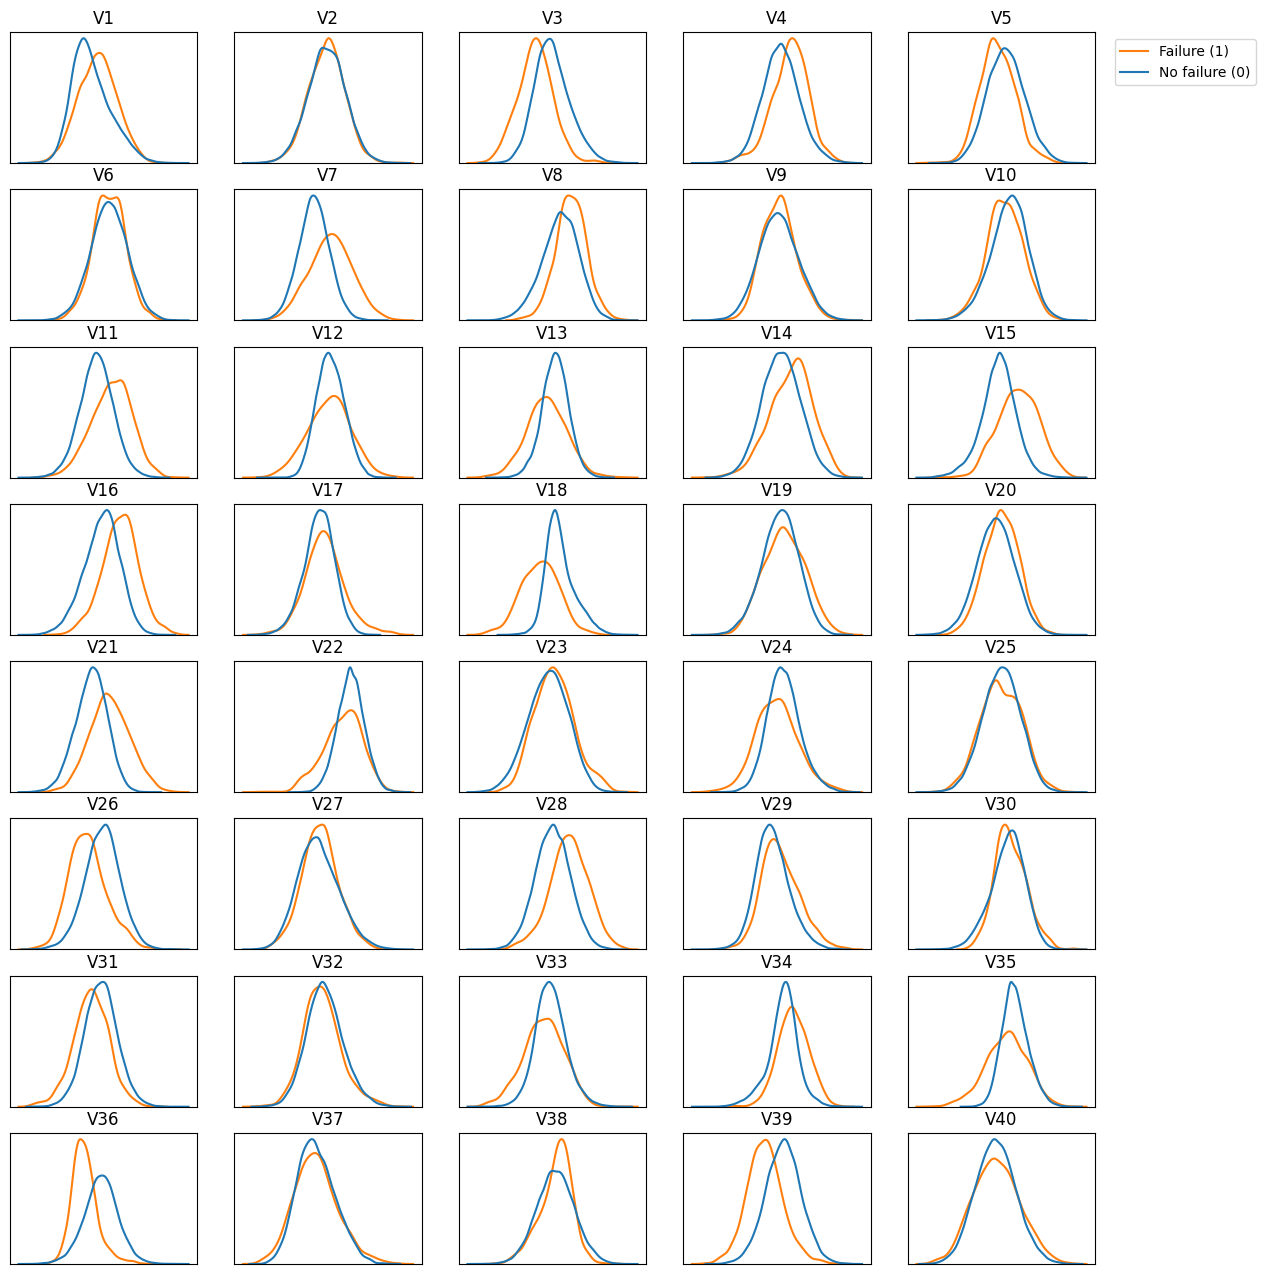

In [28]:
fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(14, 16)) 

for i, var in enumerate(train.columns[:-1]):
    ax = axes[i//5, i%5]
    sns.kdeplot(data=train, x=var, hue='Target', common_norm=False, legend=False, ax=ax).set(xlabel='', ylabel='', xticks=[], yticks=[])
    ax.set_title(var)

fig.legend(axes[0, 0].lines, ['Failure (1)', 'No failure (0)'], bbox_to_anchor=(1.02, 0.88))
plt.show()

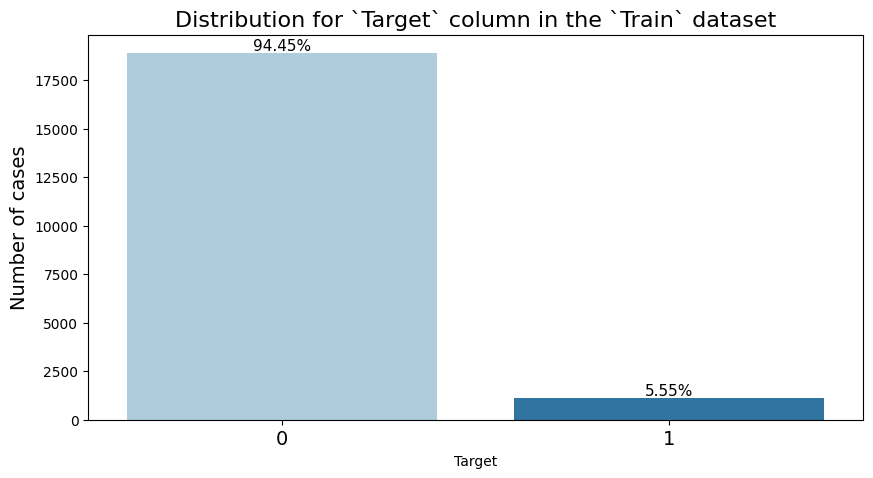

In [29]:
labeled_barplot(train, 'Target', perc=True, percfmt="{:.2f}%", rnd=0,
                    figsize=(10, 5), xlabel=None, xlo=0, title='Distribution for `Target` column in the `Train` dataset')

* The majority of variables are closely distributed to the normal distribution.
* For some variable, the distributions by the target variable are similar, while for others, they are different (shifted by mean or frequency).
* About 5.55% of the rows have a target value of "1" in the `Train` dataset, while 94.45% have a target value of "0"

### Plotting histograms and boxplots for all the variables
### Plotting all the features at one go

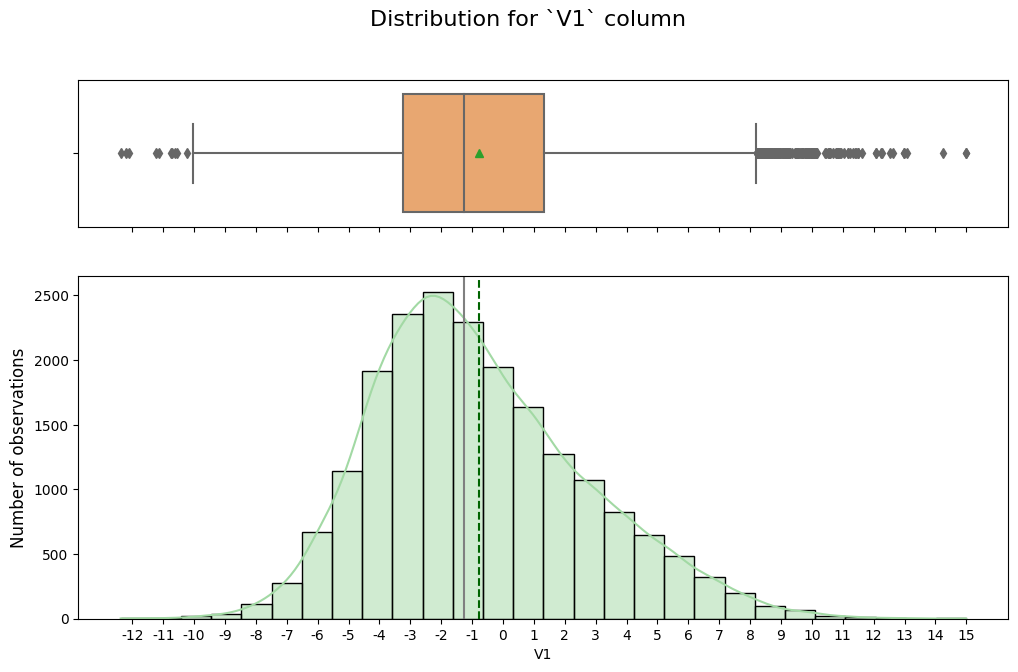

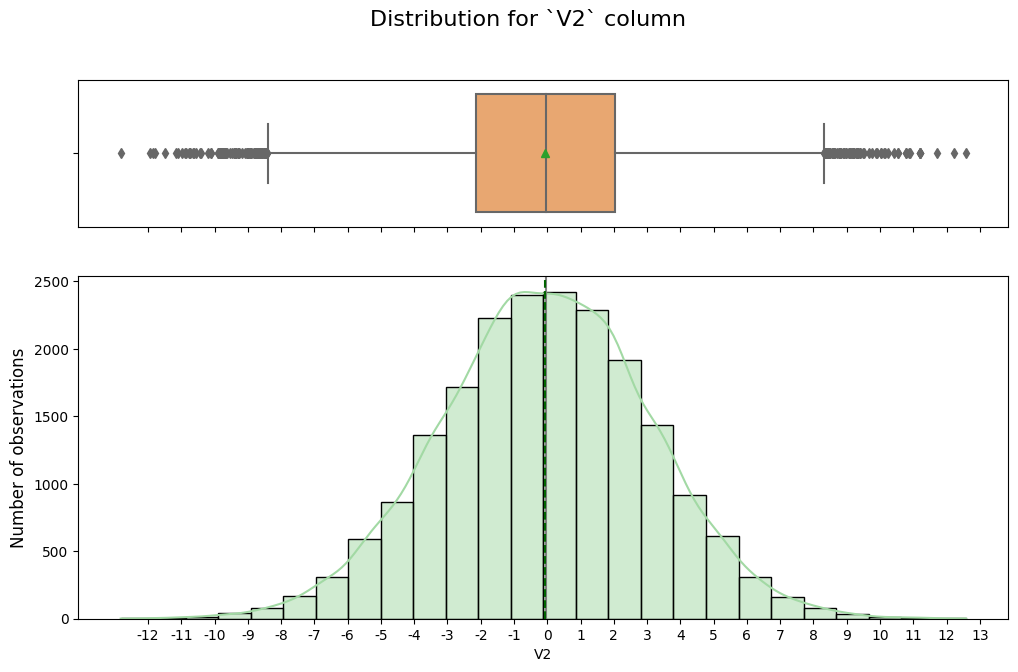

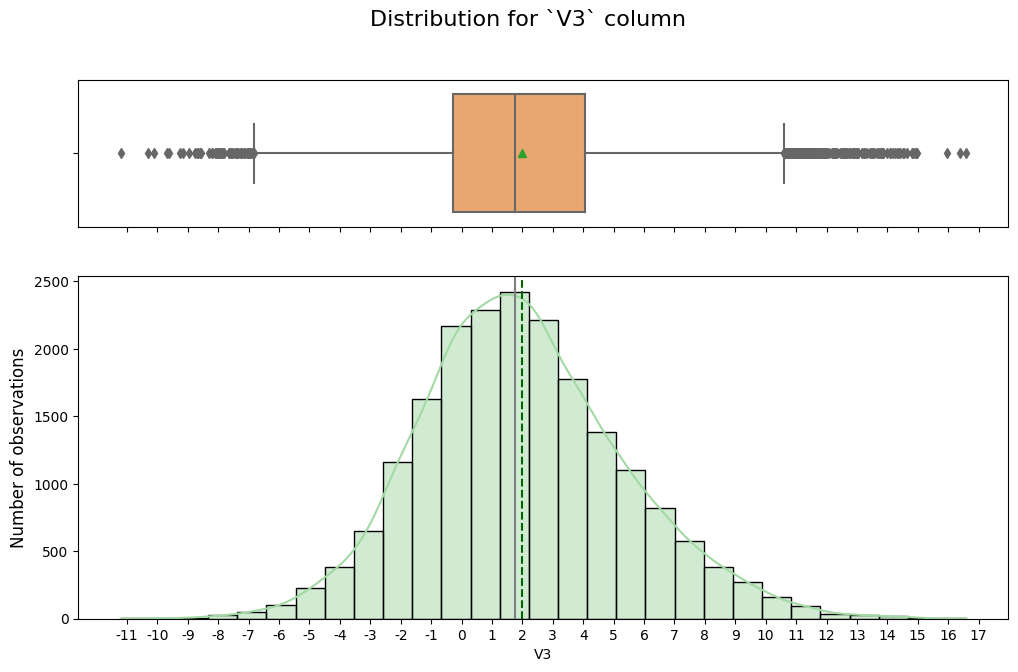

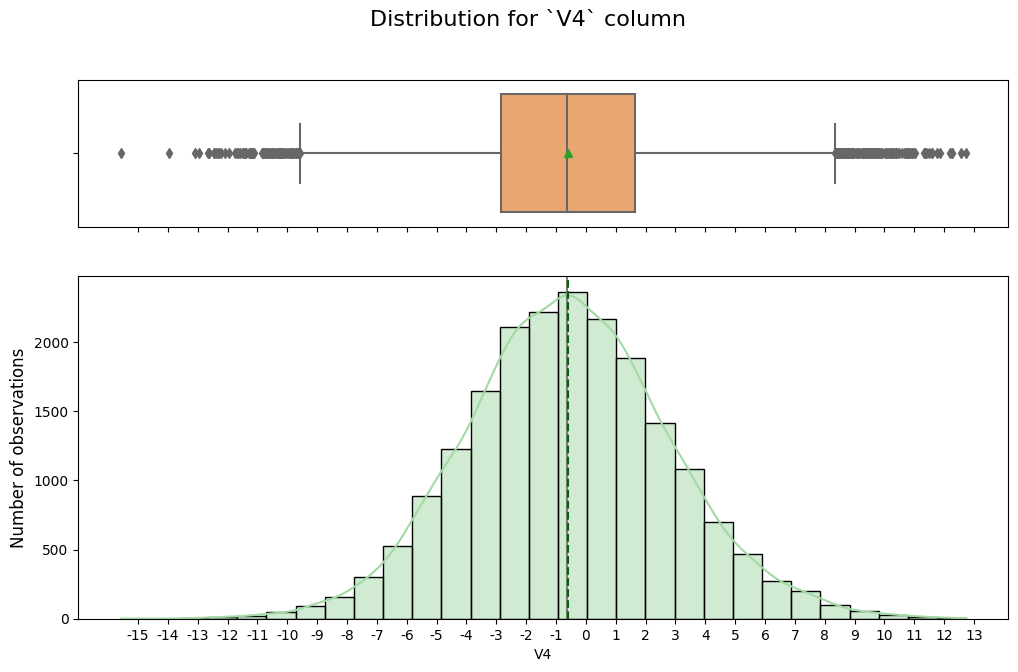

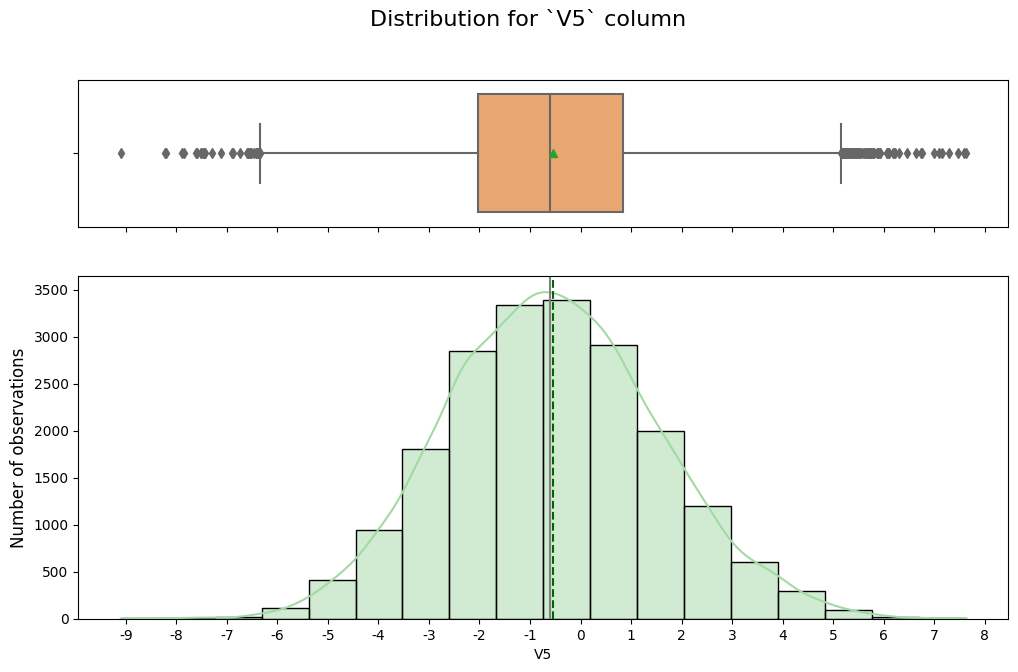

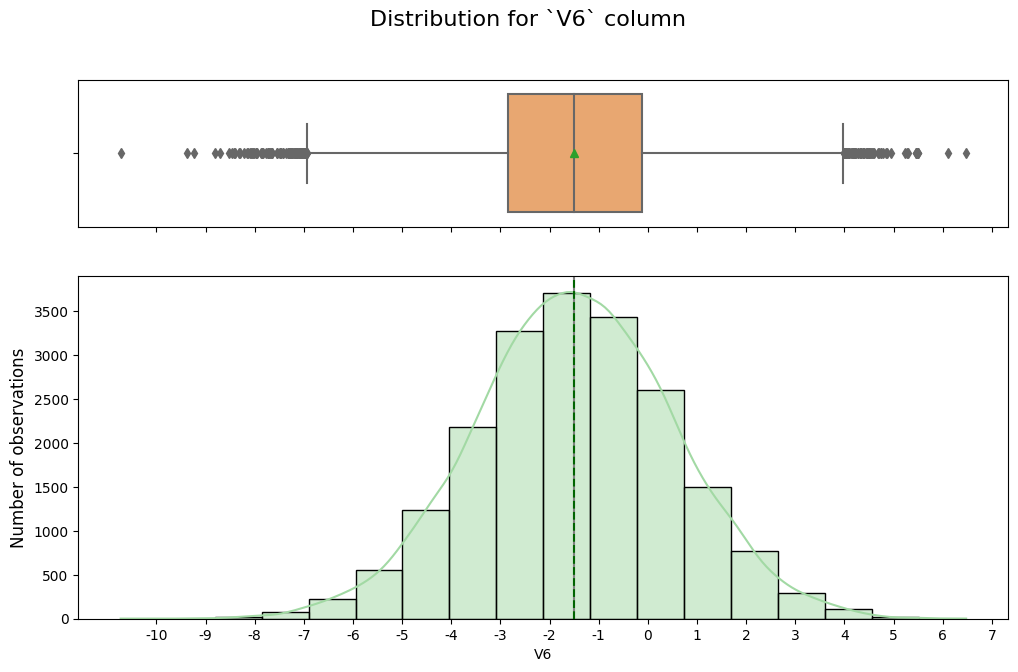

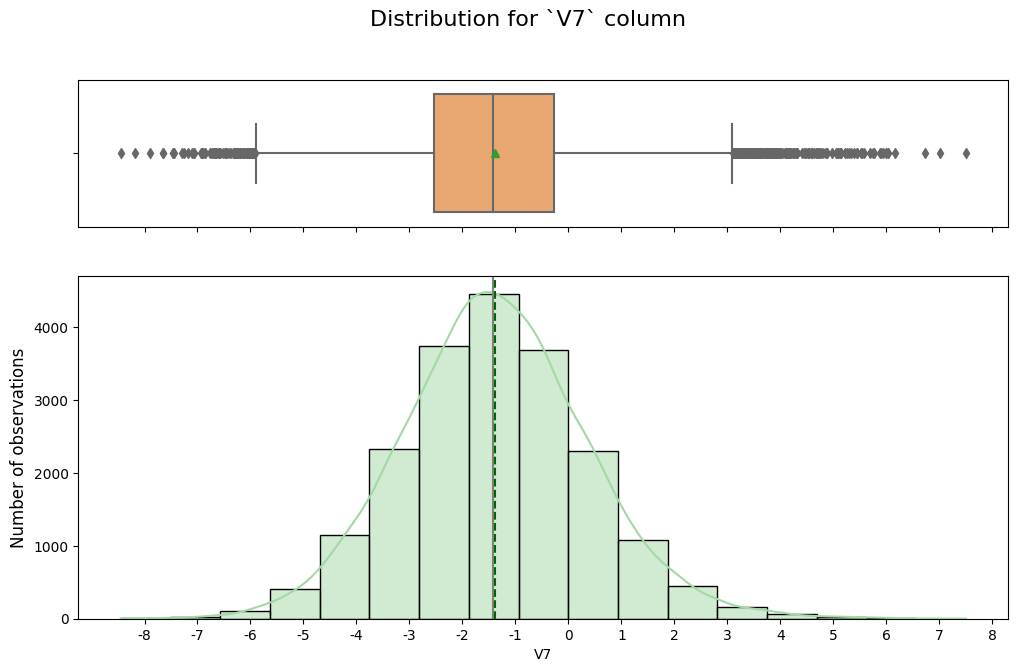

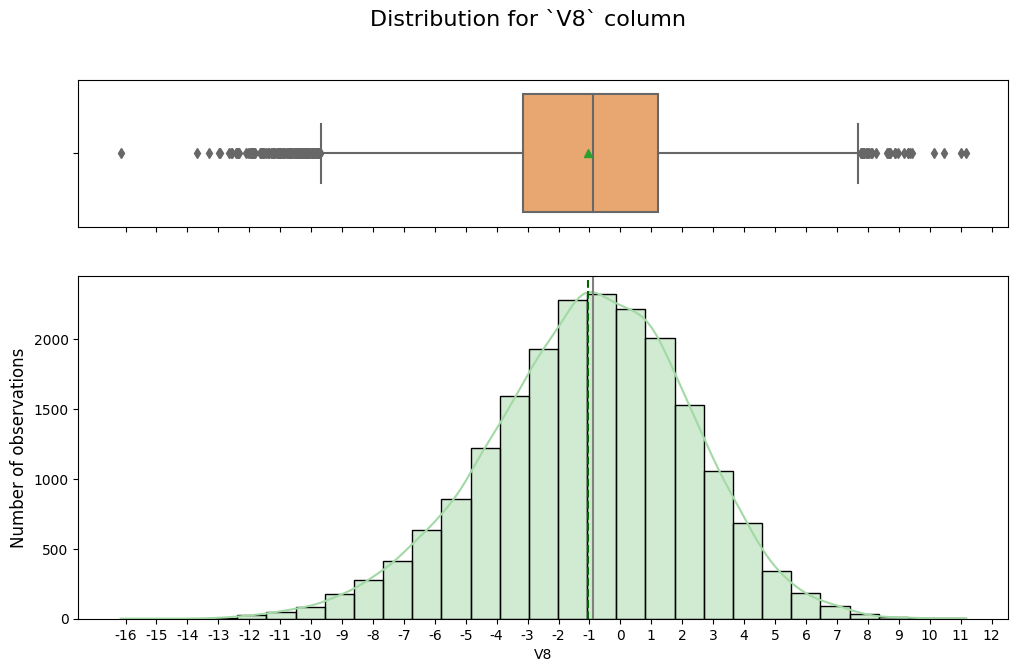

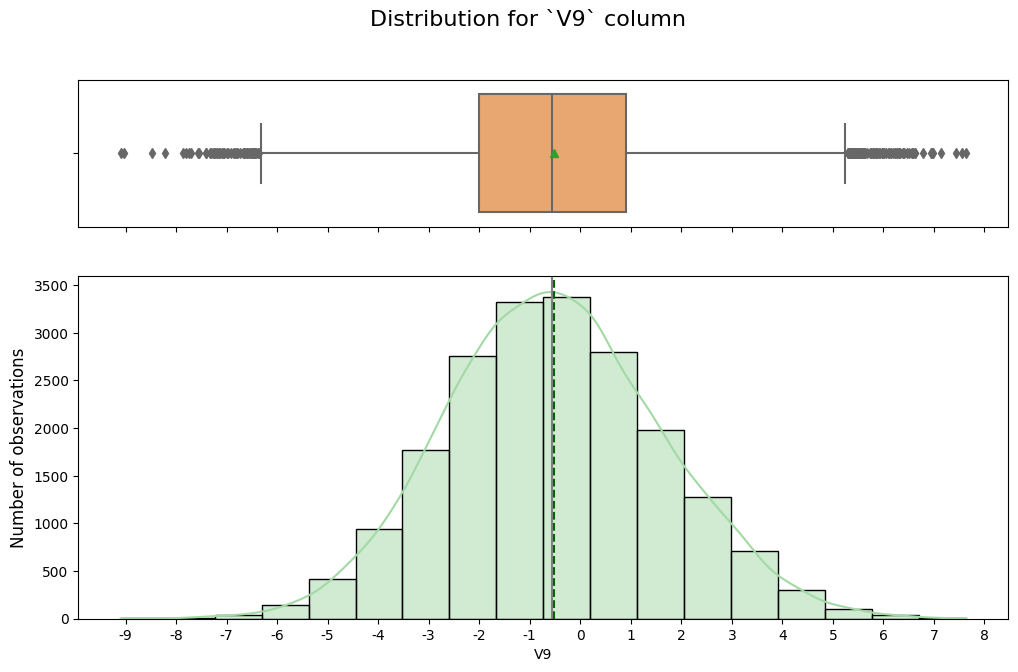

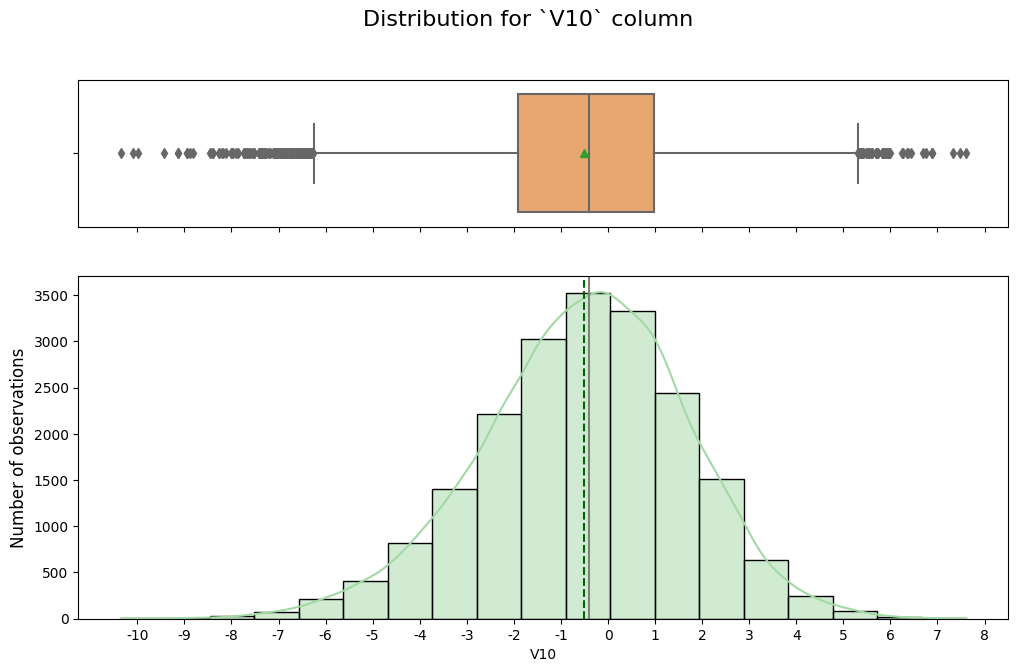

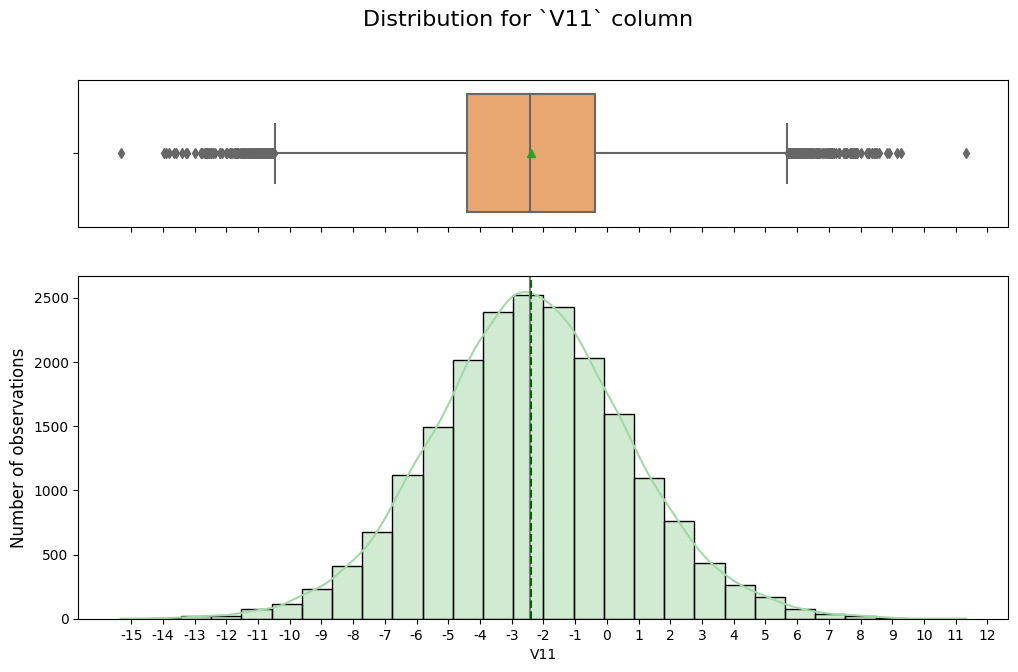

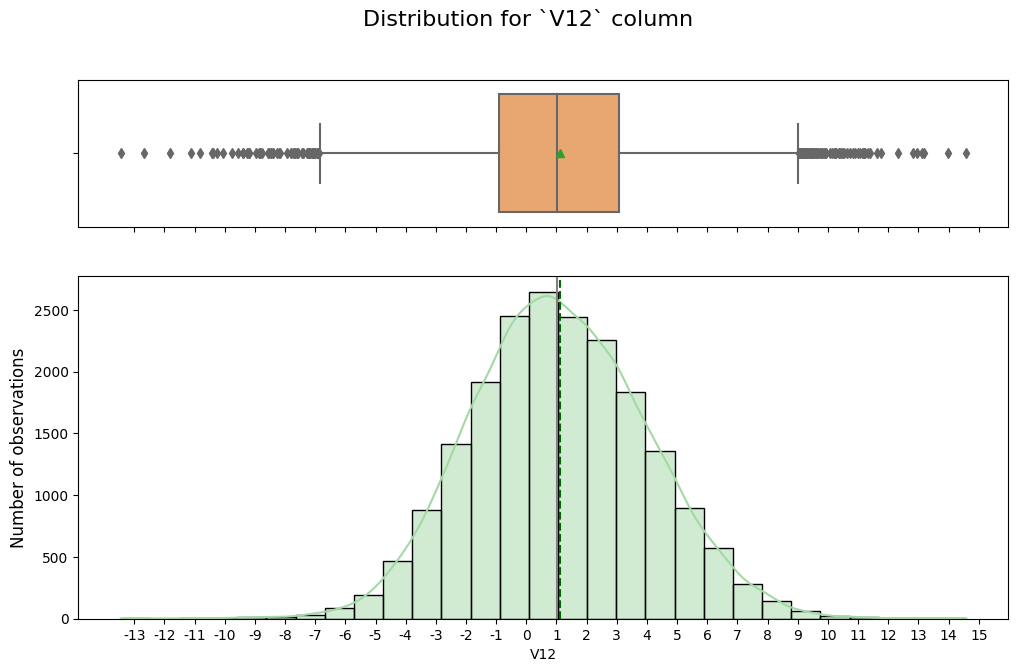

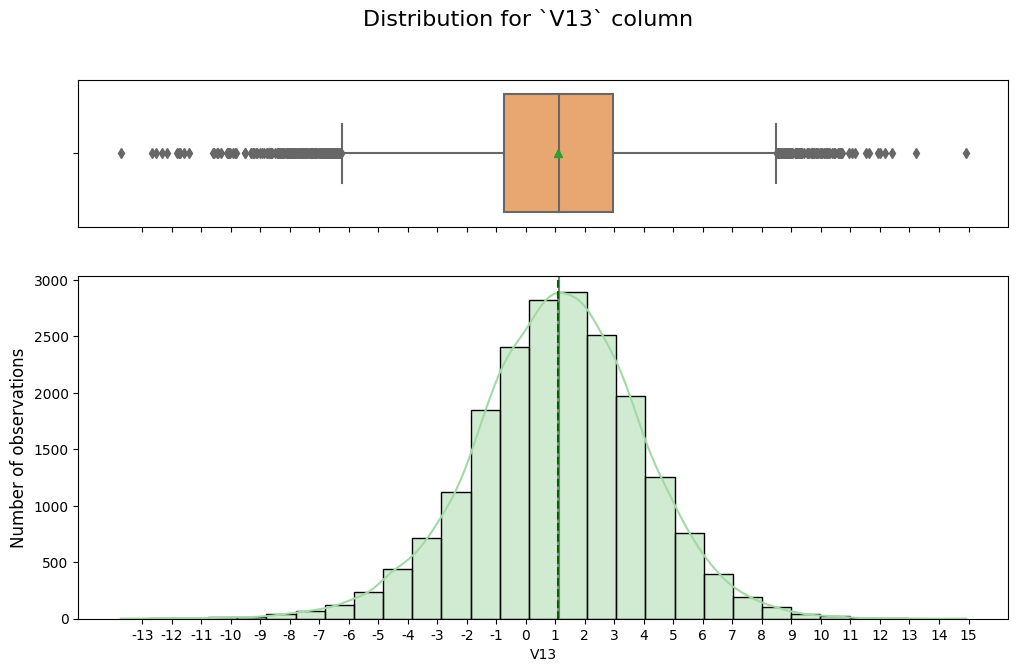

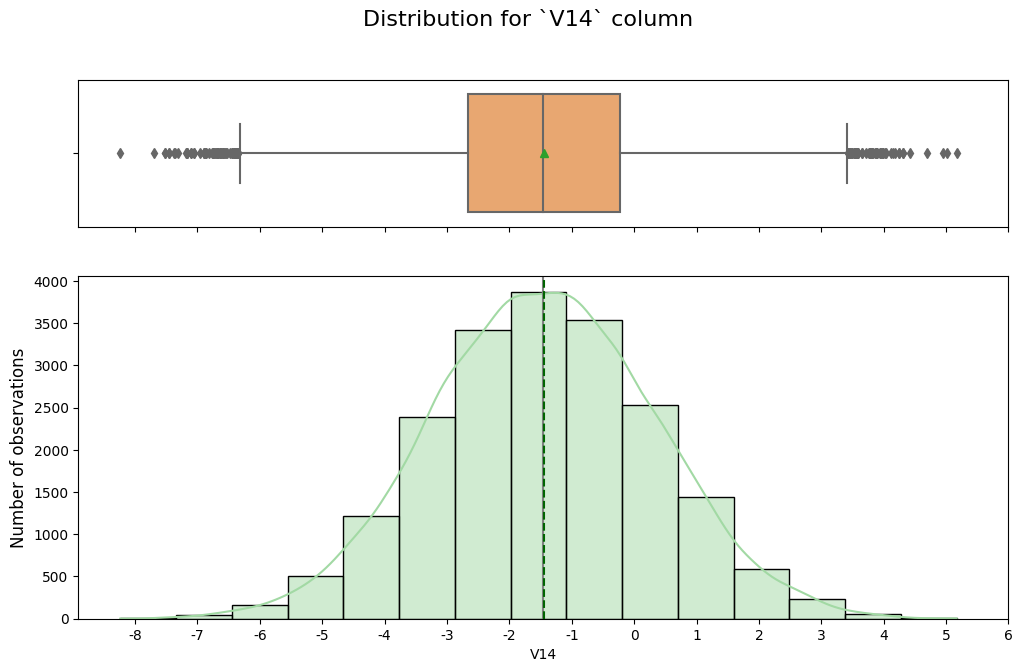

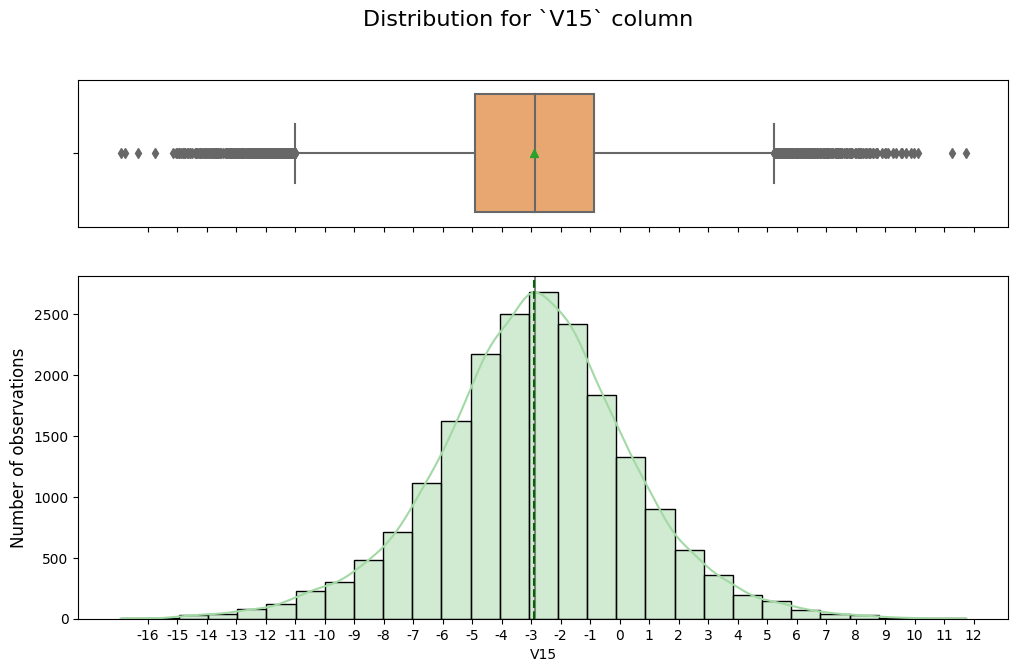

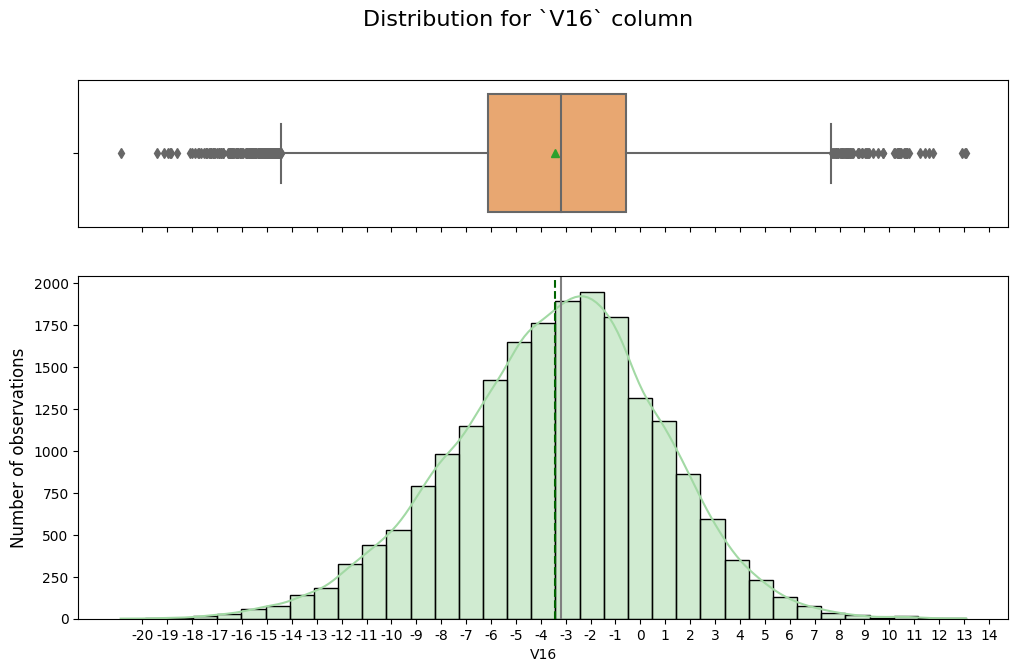

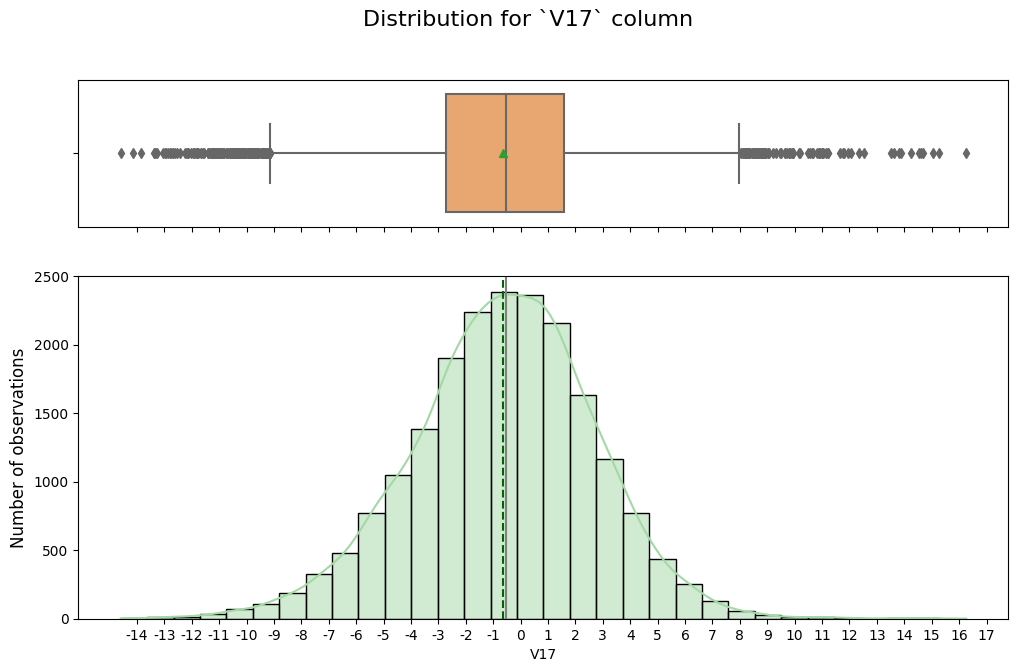

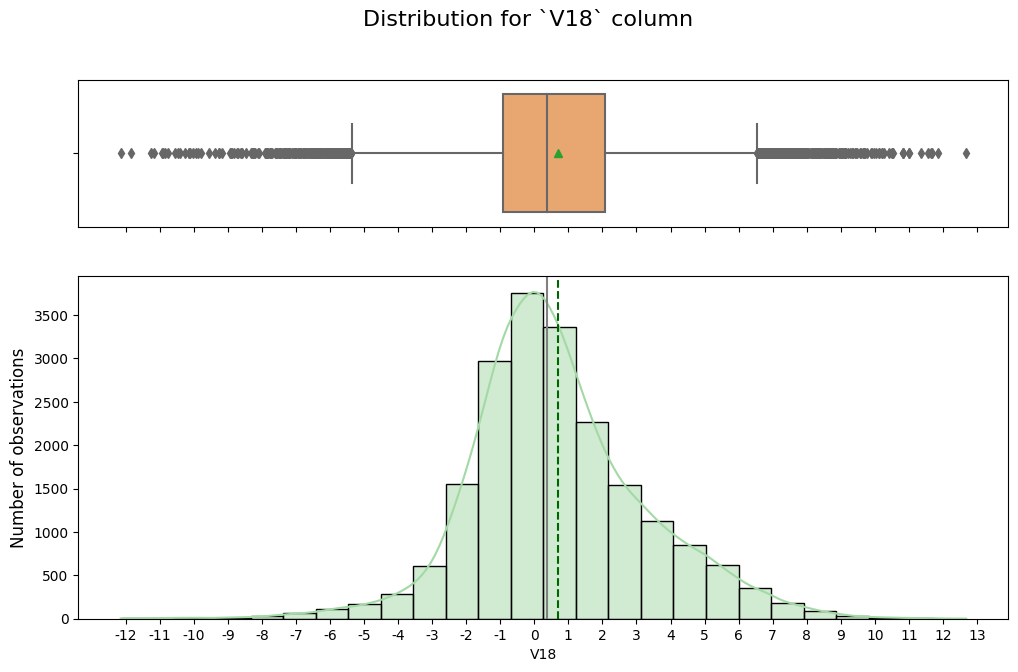

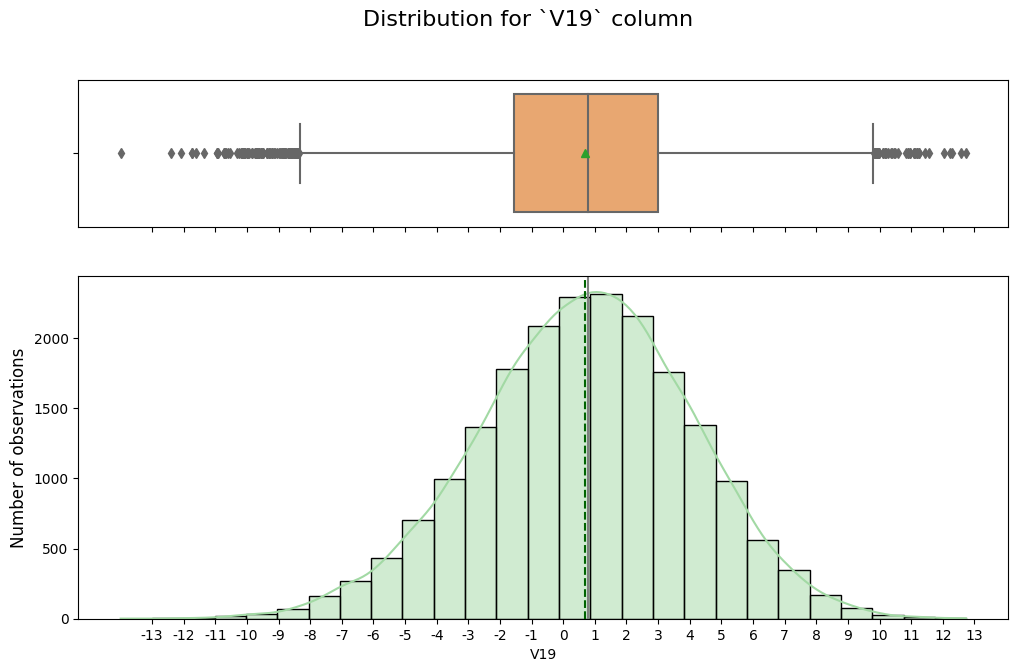

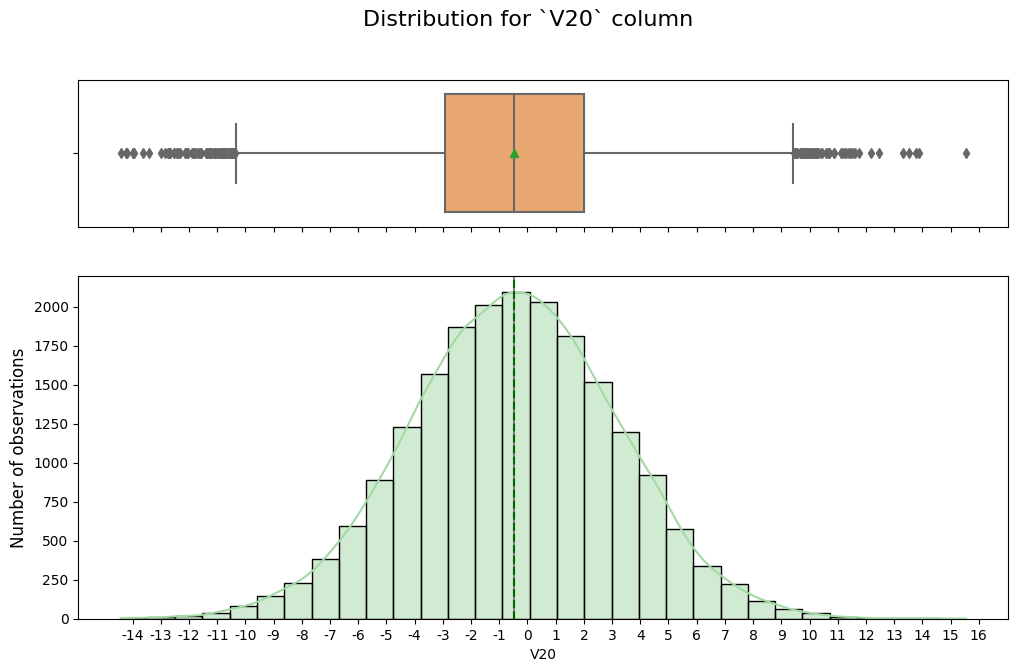

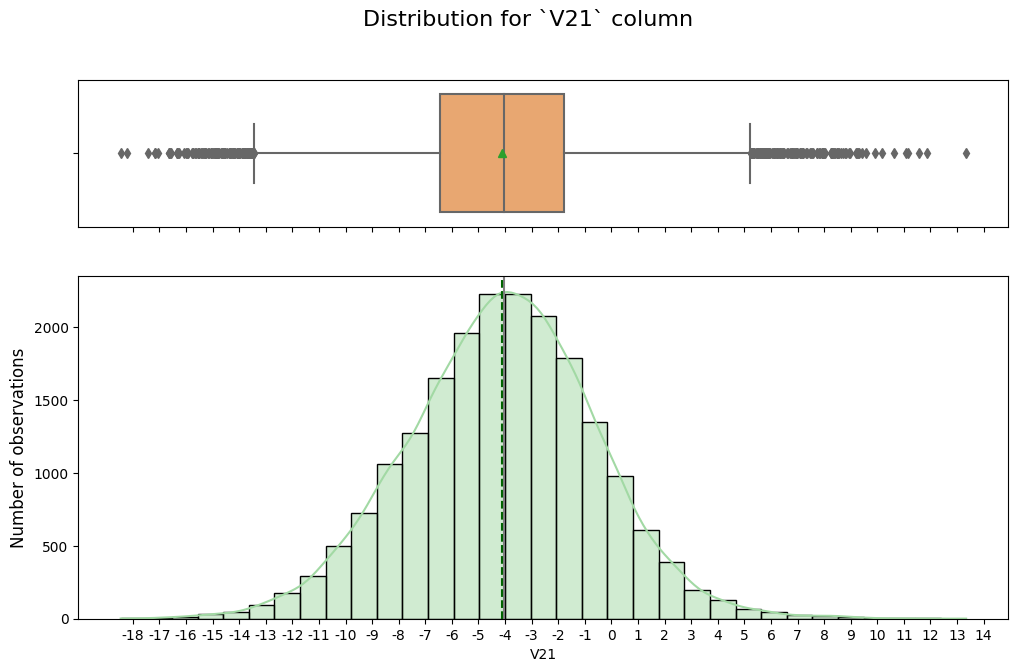

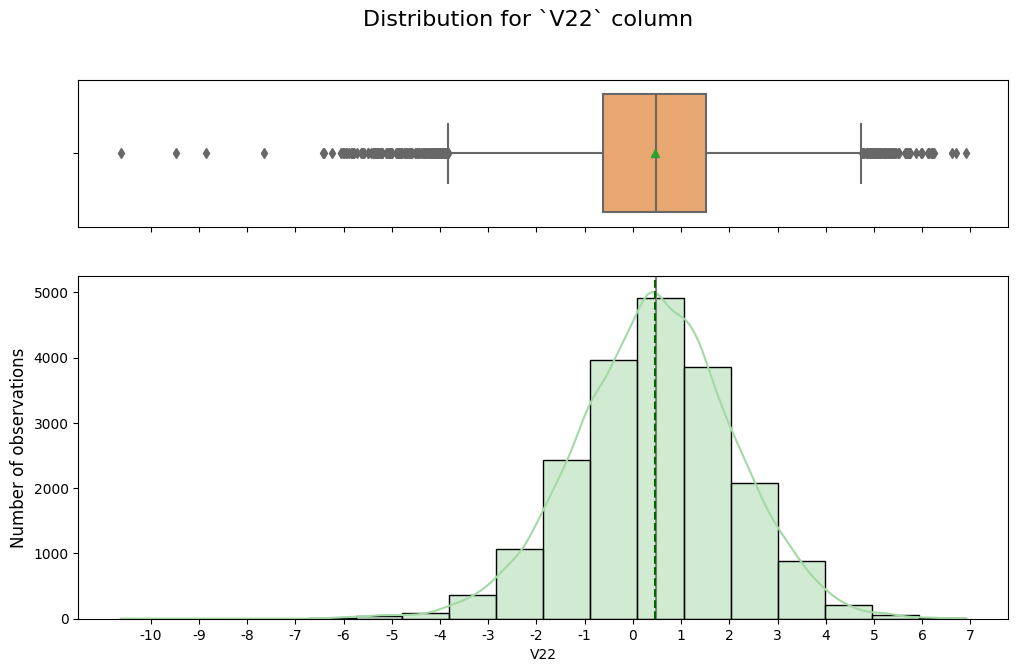

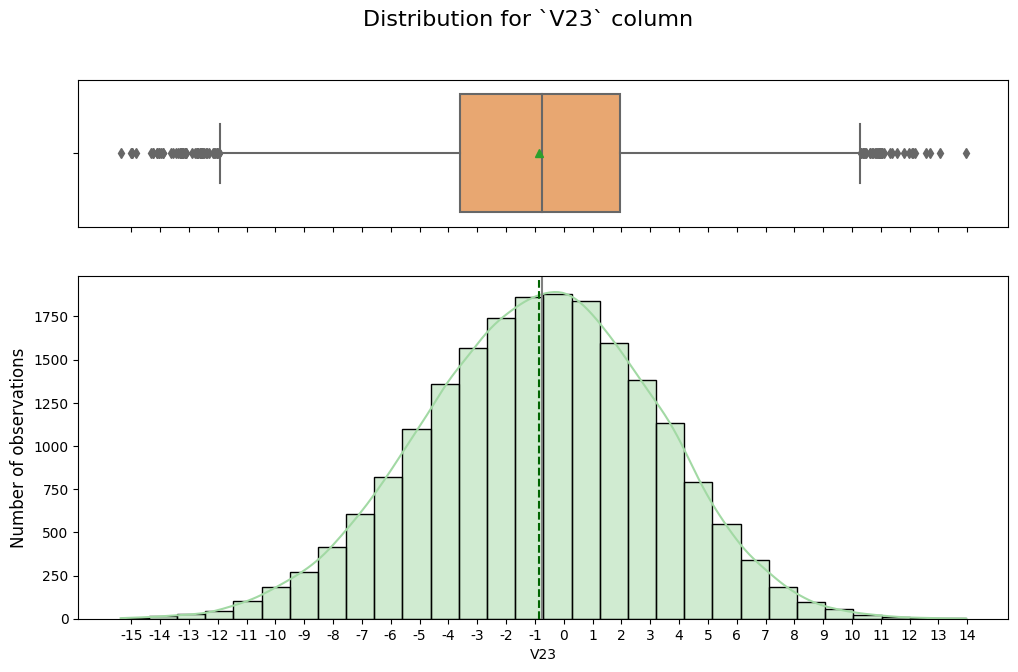

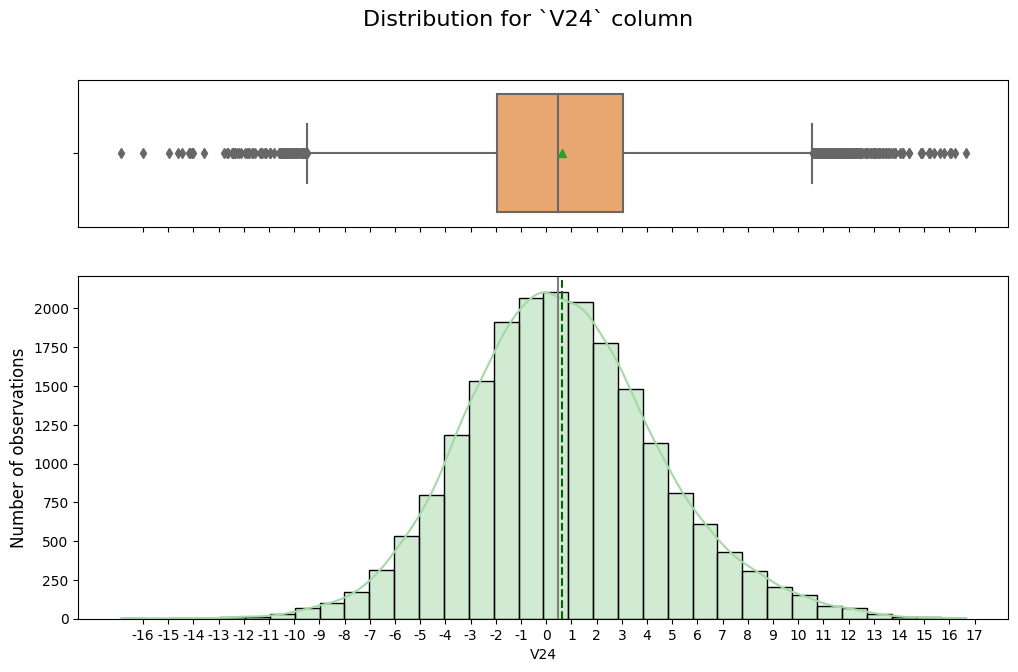

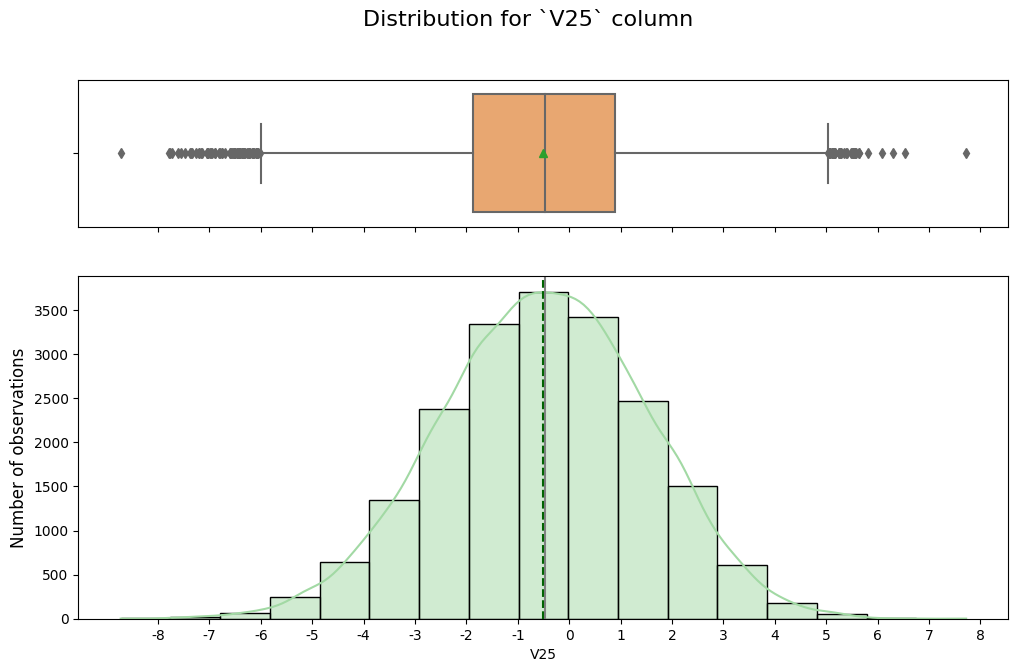

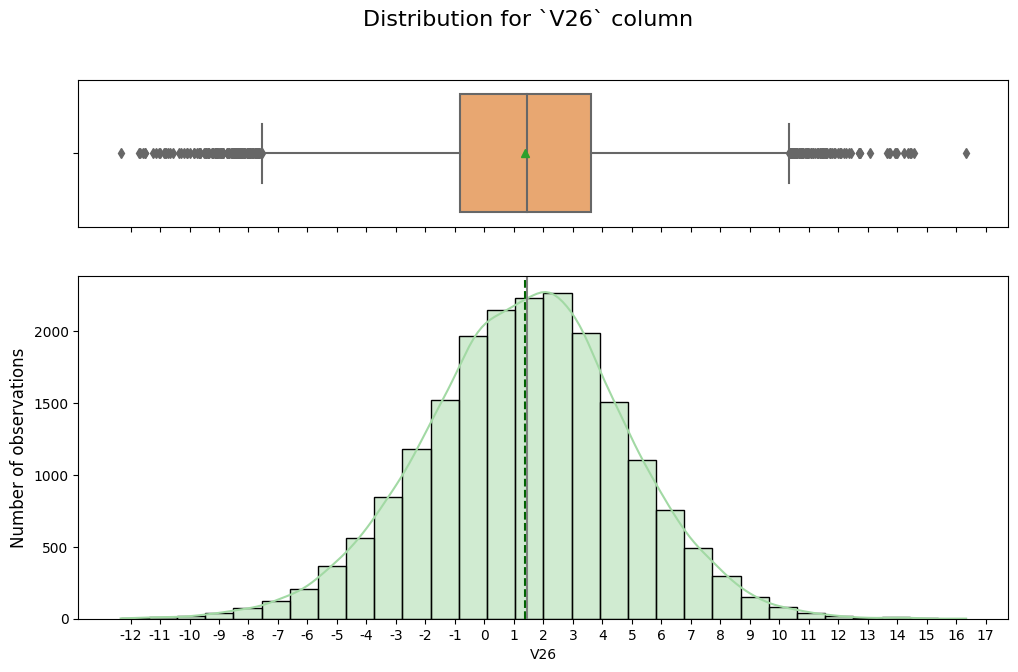

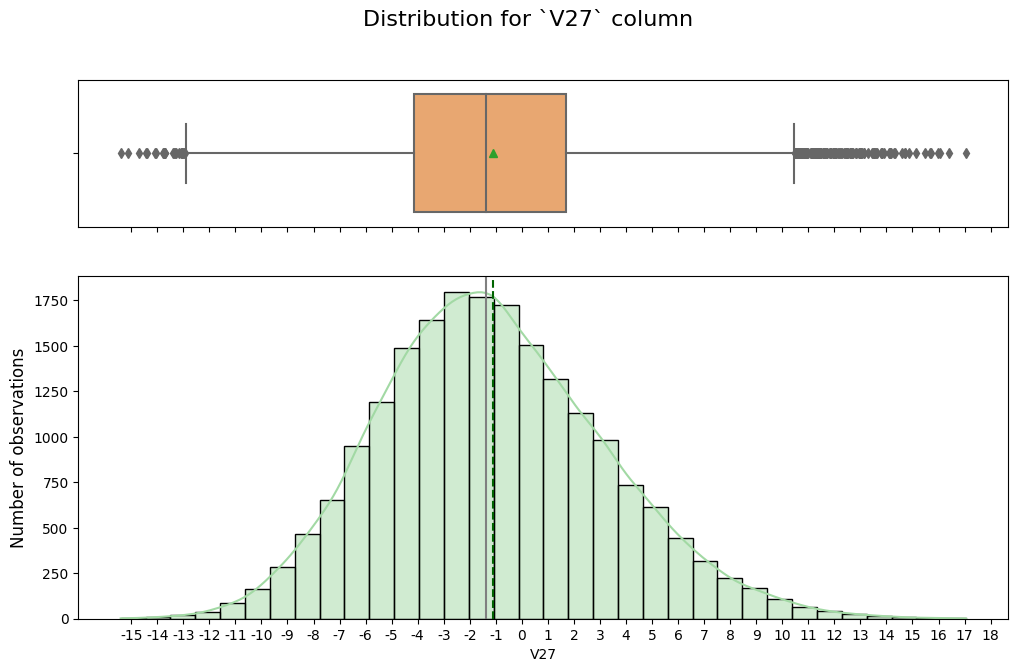

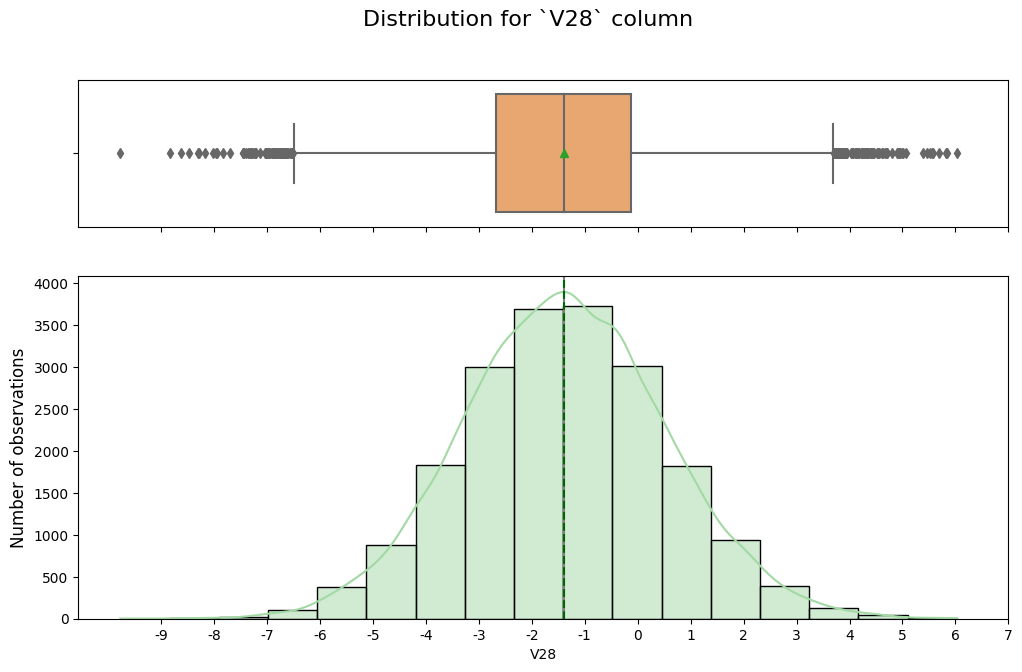

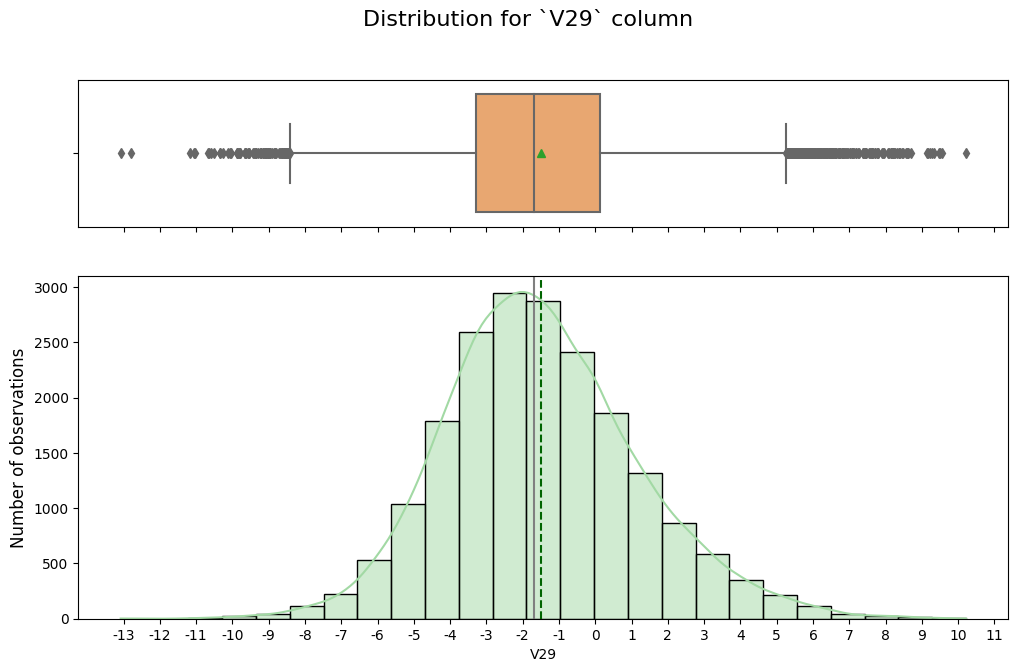

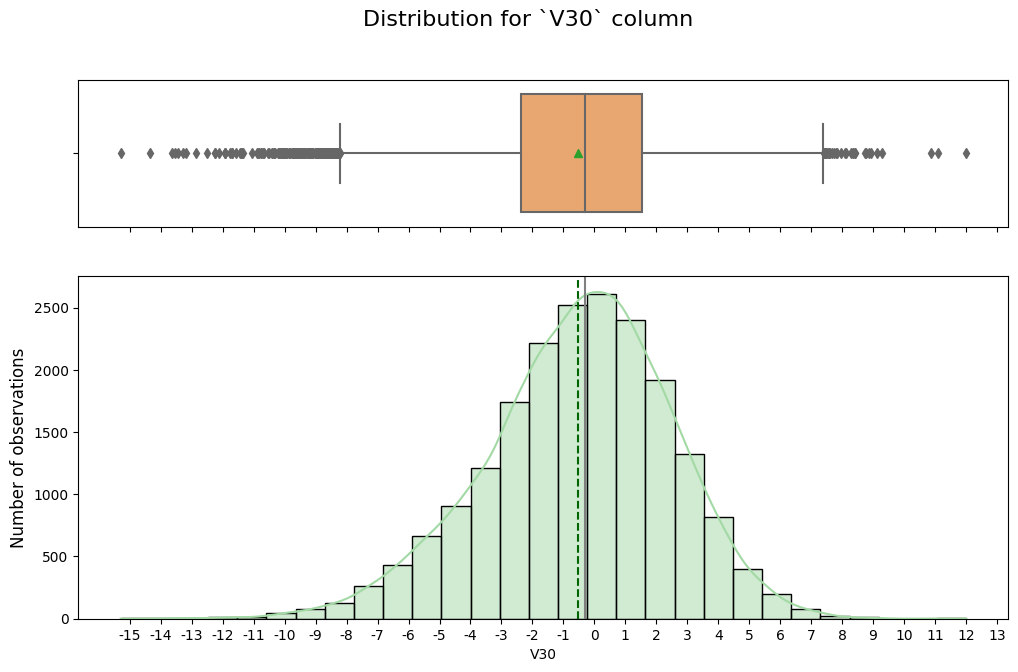

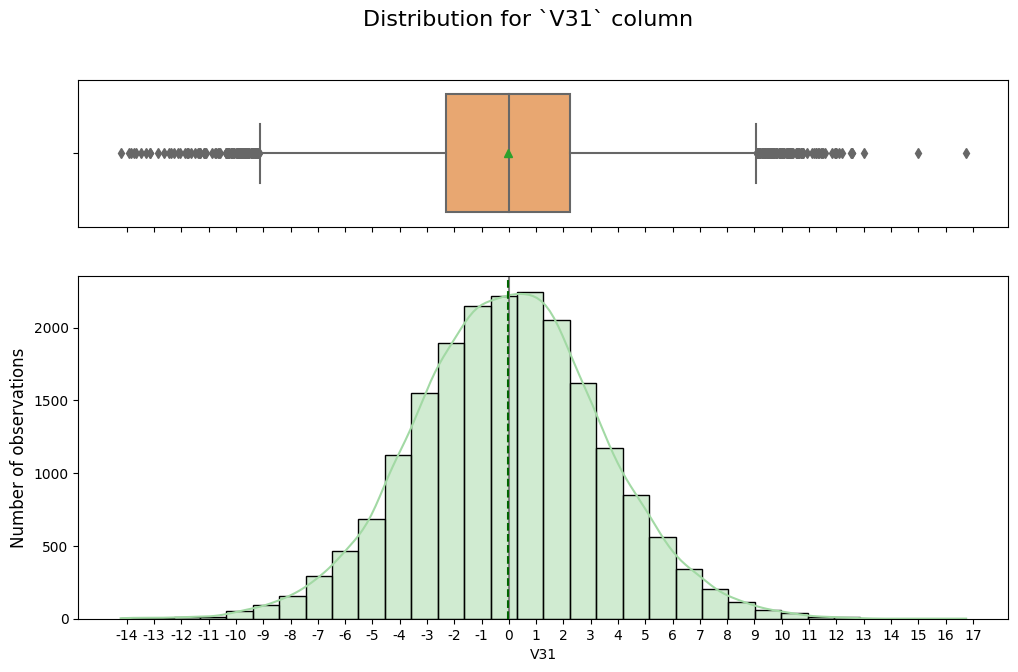

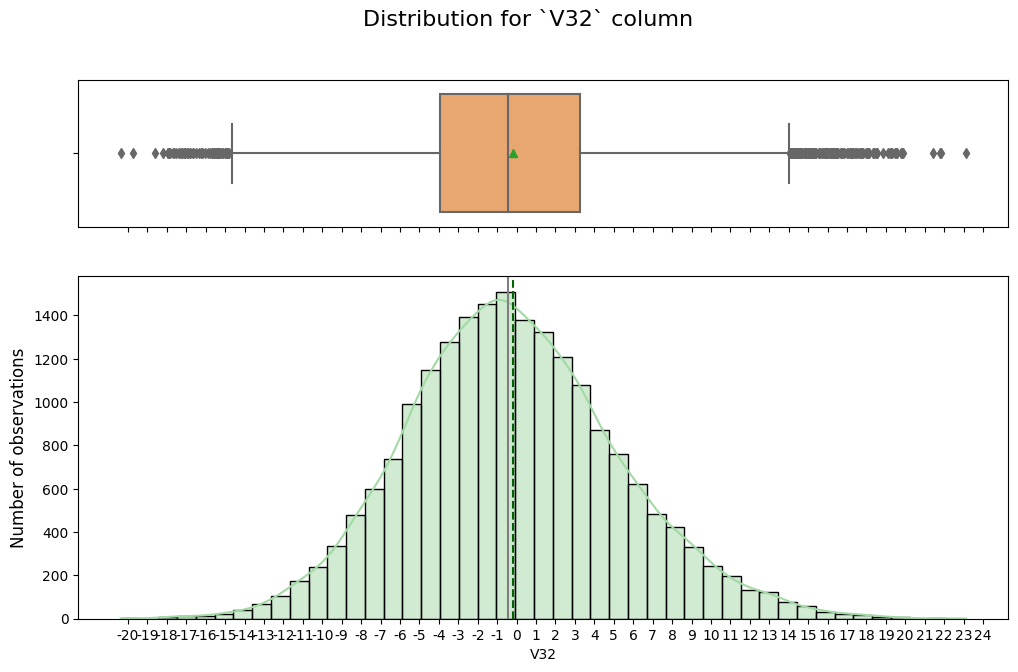

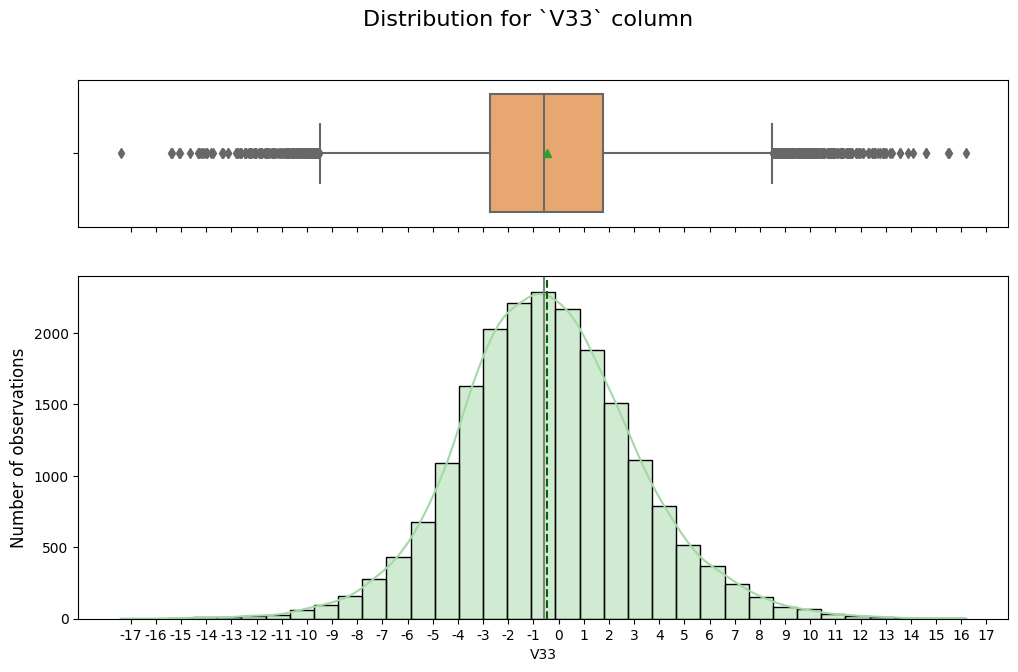

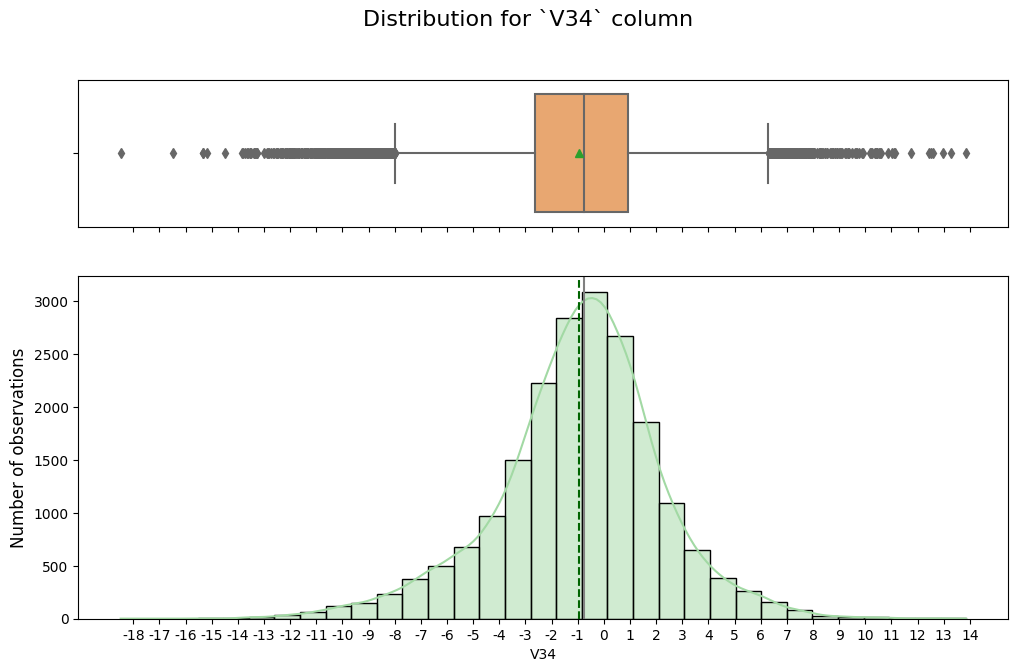

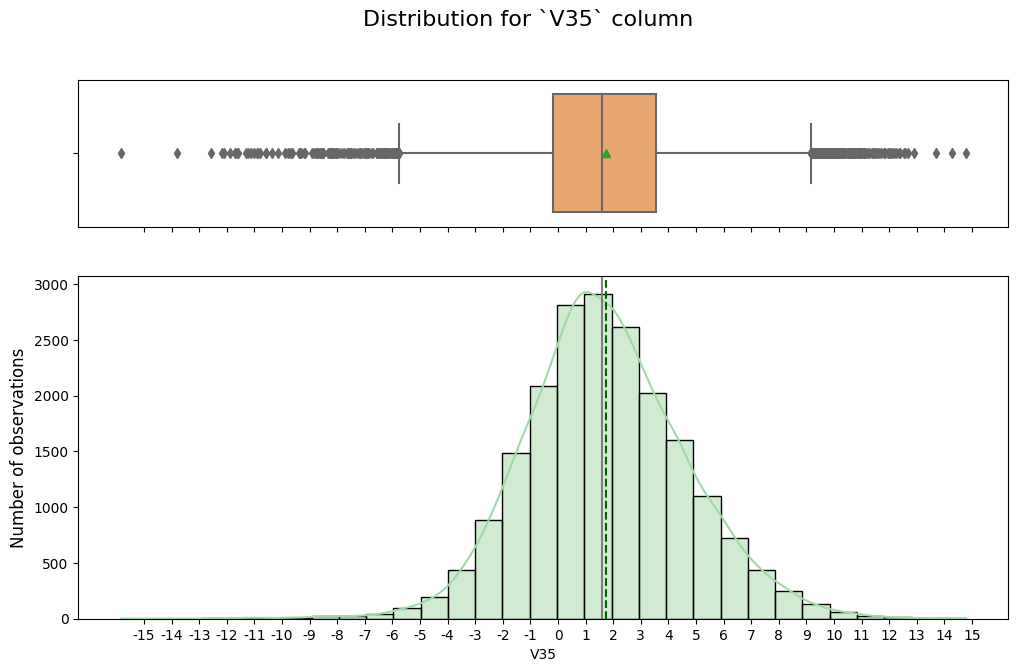

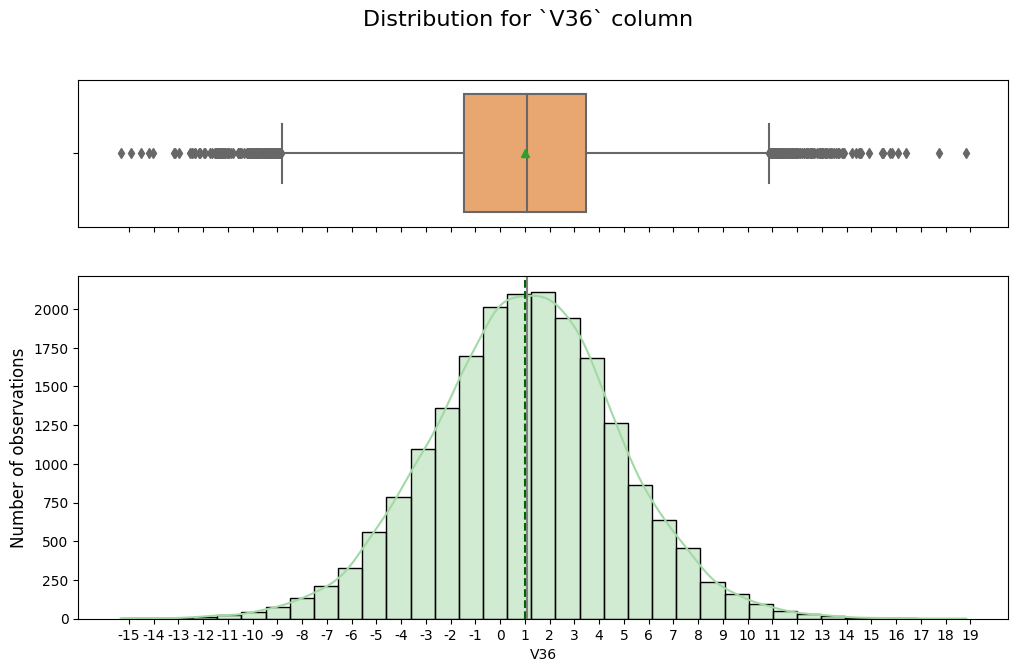

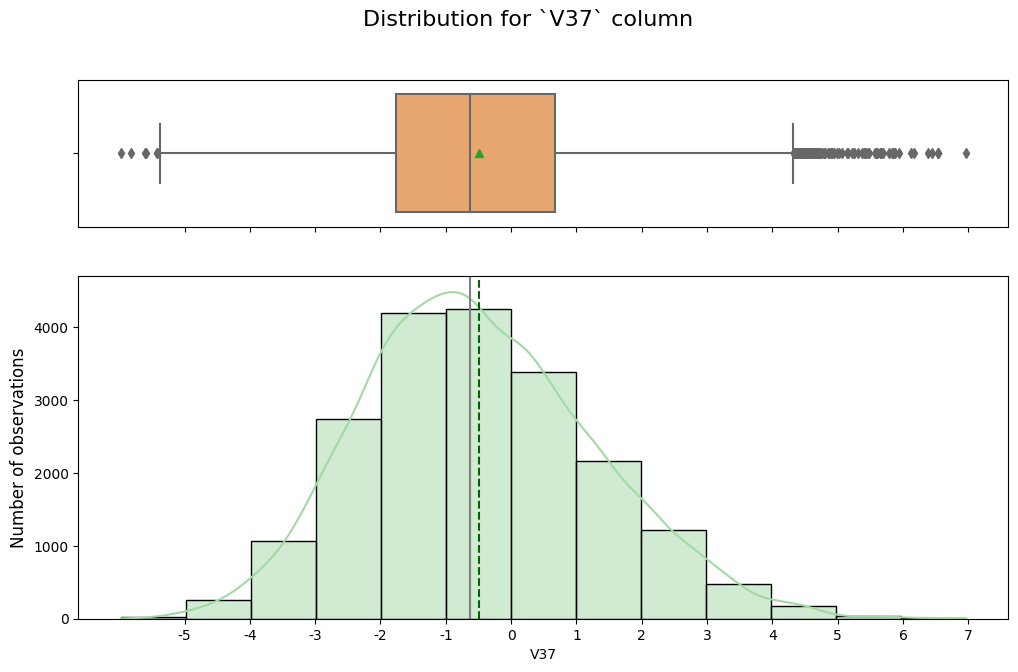

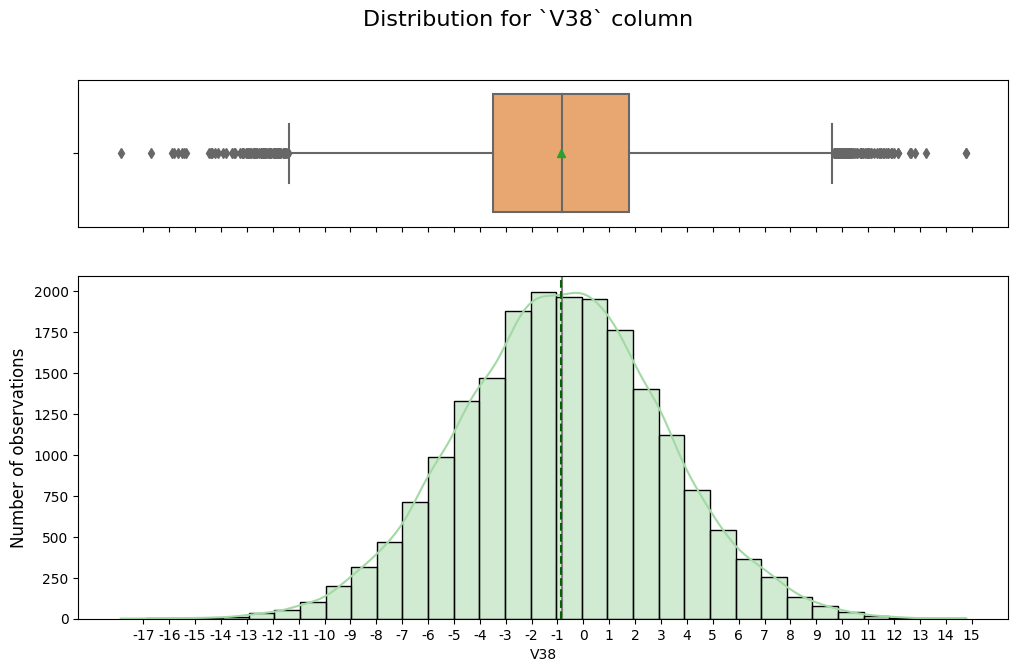

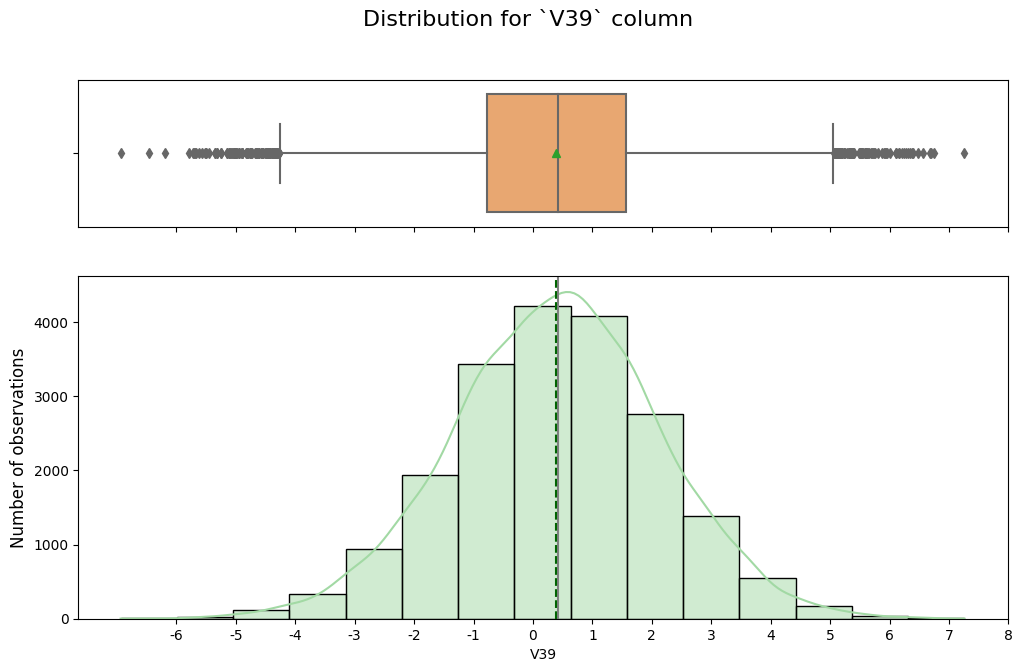

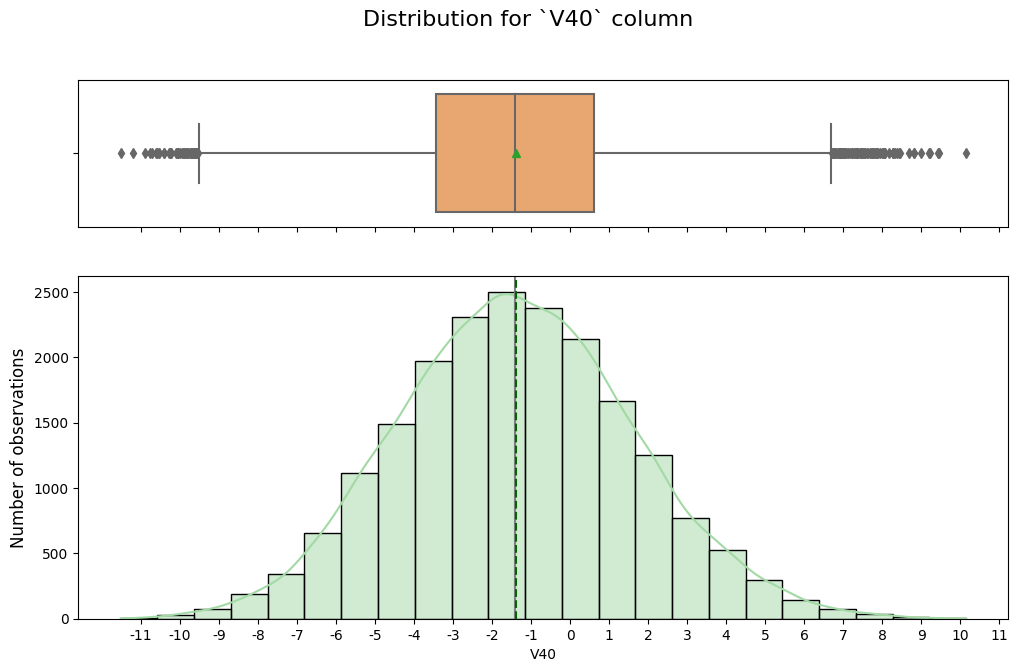

In [30]:
for feature in train.columns[:-1]:
  histogram_boxplot(train, feature, figsize=(12, 7), step=1, fmt='{:.0f}')

### Let's look at the unique values of all the Target variable


In [31]:
print(f'Unique values in `Target` in the `Train` dataset are :')
display(pd.DataFrame(data=[train['Target'].value_counts(), train['Target'].value_counts(normalize=True)],
                         index=['count', 'share']).T.style.format({'count': '{:,.0f}', 'share': '{:.2%}'}))
print('*'*50)

print(f'Unique values in `Target` in the `Test` dataset are :')
display(pd.DataFrame(data=[test['Target'].value_counts(), test['Target'].value_counts(normalize=True)],
                         index=['count', 'share']).T.style.format({'count': '{:,.0f}', 'share': '{:.2%}'}))
print('*'*50)

Unique values in `Target` in the `Train` dataset are :


**************************************************
Unique values in `Target` in the `Test` dataset are :


**************************************************


**Observations:**
* The majority of variables are closely distributed to the normal distribution.
* There are many outliers for all the variables.
* The average of means is close to zero (ranging from -3.6 to +2.5).
* The standard deviation of the means lies between 1.65 and 5.5.
* About 5.55% of the rows have a target value of "1", while 94.45% have a target value of "0". The failure rate in the observations is 5.6%.
* The distribution of classes in the target variable is imbalanced.


## Bivariate Analysis

### Correlation heatmap

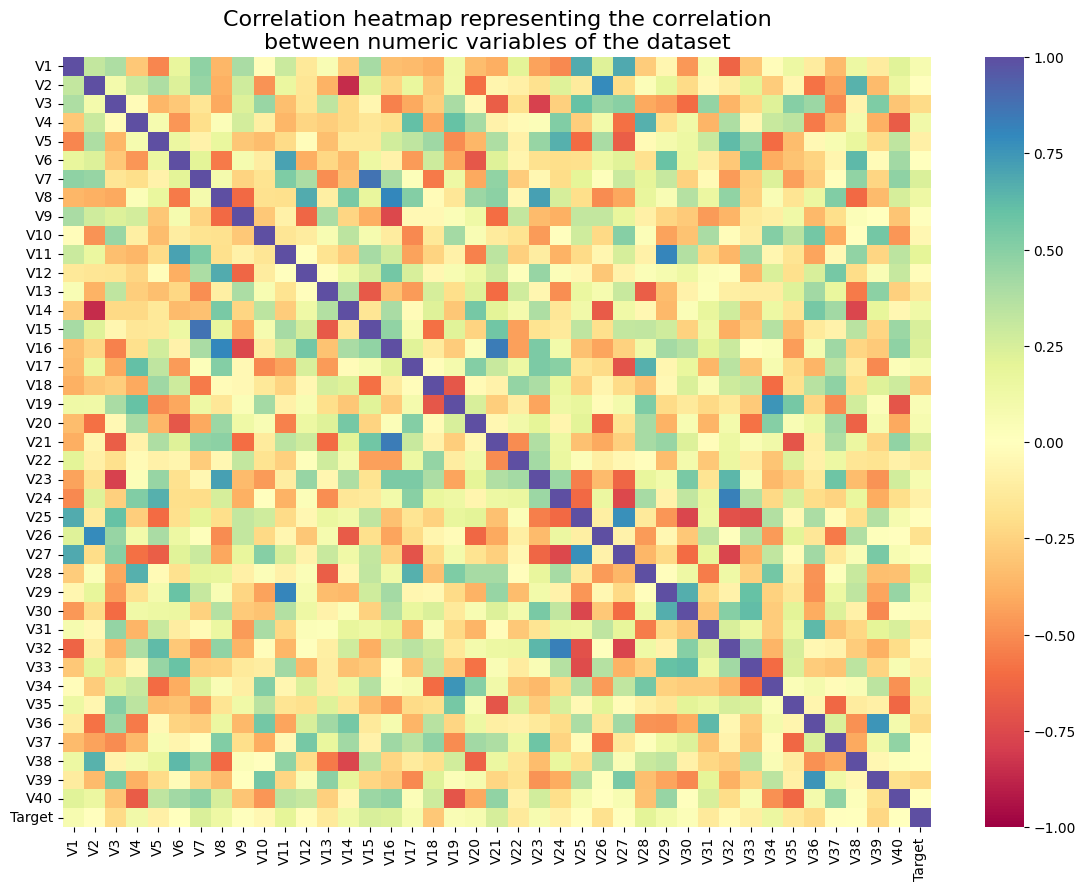

In [32]:
plt.figure(figsize=(14, 10))
sns.heatmap(train.corr(), annot=False, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation heatmap representing the correlation\nbetween numeric variables of the dataset',
          fontsize=16)
plt.show();

In [33]:
# The correlations between the dependent variable and predictors
corr = train.corr()
corr['Target'].sort_values().head()

V18   -0.293340
V39   -0.227264
V36   -0.216453
V3    -0.213855
V26   -0.180469
Name: Target, dtype: float64

In [34]:
corr['Target'][:-1].sort_values().tail()

V28    0.207359
V16    0.230507
V7     0.236907
V15    0.249118
V21    0.256411
Name: Target, dtype: float64

In [35]:
corr['Target'][:-1].describe()

count    40.000000
mean      0.008393
std       0.142960
min      -0.293340
25%      -0.101031
50%       0.005693
75%       0.108953
max       0.256411
Name: Target, dtype: float64

* Either there are no correlations or weak positive/negative correlations between the dependent variable and the predictors.

In [36]:
# The correlations between the independent variables
pos, neg = [], []

for i in range(len(corr)-1):
  for j in range(i+1, len(corr)-1):
    if corr.iloc[i, j] > 0.7:
      pos.append([corr.index[i], corr.columns[j]])
    if corr.iloc[i, j] < -0.7:
      neg.append([corr.index[i], corr.columns[j]])
      

In [37]:
print('Pairs of independent variables exhibiting strong positive correlations:')
display(pos)

Pairs of independent variables exhibiting strong positive correlations:


[['V2', 'V26'],
 ['V6', 'V11'],
 ['V7', 'V15'],
 ['V8', 'V16'],
 ['V8', 'V23'],
 ['V11', 'V29'],
 ['V16', 'V21'],
 ['V19', 'V34'],
 ['V24', 'V32'],
 ['V25', 'V27'],
 ['V36', 'V39']]

In [38]:
print('Pairs of independent variables exhibiting strong negative correlations:')
display(neg)

Pairs of independent variables exhibiting strong negative correlations:


[['V2', 'V14'],
 ['V3', 'V23'],
 ['V9', 'V16'],
 ['V14', 'V38'],
 ['V17', 'V27'],
 ['V21', 'V35'],
 ['V24', 'V27'],
 ['V25', 'V30'],
 ['V25', 'V32'],
 ['V25', 'V33'],
 ['V27', 'V32']]

* The correlations between the dependent variable and predictors are very weak, ranging from -0.29 to +0.25.
* There are 11 pairs of independent variables that are strongly positively correlated with each other.
* There are 11 pairs of independent variables that are strongly negatively correlated with each other.
* The variables `V25` and `V27` have the highest number of mutual correlations with other predictors.
  * They are also positively correlated with each other.
  * `V25` is negatively correlated with `V30`, `V32`, and `V33`.
  * `V27` is negatively correlated with `V17`, `V24`, and `V32`.

## Data Pre-processing

* Preparing data for modeling
* Missing value treatment
* Feature engineering
* Outlier detection and treatment
* Any other preprocessing steps

## Preparing data for modeling

>In this project, two separate datasets have been provided: Train.csv and Test.csv. The Train.csv file can be split into training and validation sets to train, tune, and check how models perform. The Test.csv file should be used for testing the performance of the final model only. So, there is no need to split the Test.csv file.

In [39]:
# Splitting training data into training and validation, as we already have tthe test set:
X_temp, y_temp = train.drop(['Target'], axis=1), train['Target']
X_test, y_test = test.drop('Target', axis=1), test['Target']

#The next 3 lines were needed for a smoke-test purposes only during the project preparation
#N = 1000
#X_temp, y_temp = train[:N].drop(['Target'], axis=1), train['Target'][:N]
#X_test, y_test = test[:N].drop('Target', axis=1), test['Target'][:N]

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(X_train.shape, X_valid.shape, X_test.shape)

(15000, 40) (5000, 40) (5000, 40)


In [40]:
print("Number of rows in train data is", X_train.shape[0])
print("Number of rows in validation data is", X_valid.shape[0])
print("Number of rows in test data is", X_test.shape[0])

Number of rows in train data is 15000
Number of rows in validation data is 5000
Number of rows in test data is 5000


## Missing value imputation




 Let's drop the missing values
> We reviewed three options to address missing values in this project.

  * **Option 1**. Dropping rows with missing values. We can remove rows with missing values, as there are only a few.
    * Pros:
      - Easy to implement.
      - Preserves the integrity of the data, as no artificial values are introduced.
    * Cons:
      - Sometimes it may result in loss of valuable information if the dataset is small or missing values are significant in number.
      - May introduce bias if the missing values are not missing at random.

  * **Option 2.** Median. We can replace missing values with the median value.
    * Pros:
      - Simple and fast to compute.
      - Less sensitive to outliers compared to the mean value.
    * Cons:
      - May not accurately represent the missing data if the distribution is heavily skewed.
      - Can distort the underlying distribution of the data.

  * **Option 3.** KNN. We can replace missing values using the KNN algorithm.
    * Pros:
      - Can provide more accurate estimations of missing values, as it considers the similarity between instances in the dataset.
      - Handles non-linear relationships between features.
    * Cons:
      - Computationally expensive, especially for large datasets.
      - Sensitive to the presence of noise and outliers in the dataset.

>**Option 3 has been selected for this project.**

In [41]:
# Option 1. Dropping rows with missing values. 

# Dropping missing values in the training dataset
#X_train = X_train.dropna()
#y_train = y_train[X_train.index]

# Dropping missing values in the validation dataset
#X_valid = X_valid.dropna()
#y_valid = y_valid[X_valid.index]

# Dropping missing values in the testing dataset
#X_test = X_test.dropna()
#y_test = y_test[X_test.index]

#print(X_train.shape, X_valid.shape, X_test.shape)
#print(y_train.shape, y_valid.shape, y_test.shape)

In [42]:
# Option 2. Replacing missing values with the median value.

# Defining the KNN imputer
#imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit the imputer on train data and transform the train data
#X_train = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data using the imputer fit on train data
#X_valid = pd.DataFrame(imp_median.transform(X_valid), columns=X_valid.columns)

# Transform the test data using the imputer fit on train data
#X_test = pd.DataFrame(imp_median.transform(X_test), columns=X_test.columns)

* To address missing values in the dataset, we will use an adaptive imputation method: **KNN Imputer** can adapt to various data distributions and patterns, making it suitable for our datasets.
  * `KNNImputer`: Each sample's missing values are imputed by looking at the n_neighbors nearest neighbors found in the training set. Default value for n_neighbors=5.
  * KNN imputer replaces missing values using the average of k nearest non-missing feature values.
  * Nearest points are found based on euclidean distance.

In [43]:
# Option 3. KNN. We can replace missing values using the KNN algorithm.
# defining the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Fit the imputer on the training dataset
imputer.fit(X_train)

# Impute missing values in the training dataset
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)

# Impute missing values in the validation dataset using the same imputer
X_valid = pd.DataFrame(imputer.transform(X_valid), columns=X_valid.columns)

# Impute missing values in the test dataset using the same imputer
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [44]:
# Checking that no column has missing values in train, validation or test sets

print("Number of missing values in train data is", X_train.isna().sum().sum())
print("Number of missing values in validation data is", X_valid.isna().sum().sum())
print("Number of missing values in test data is", X_test.isna().sum().sum())


Number of missing values in train data is 0
Number of missing values in validation data is 0
Number of missing values in test data is 0


* All missing values have been treated.

## Feature engineering


### Oversampling train data using SMOTE

In [45]:
# Fit SMOTE on train data (Synthetic Minority Oversampling Technique)

sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=42)

X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [46]:
print("Before OverSampling, count of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, count of label '0': {} \n".format(sum(y_train == 0)))

print("After OverSampling, count of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, count of label '0': {} \n".format(sum(y_train_over == 0)))

print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, count of label '1': 833
Before OverSampling, count of label '0': 14167 

After OverSampling, count of label '1': 14167
After OverSampling, count of label '0': 14167 

After OverSampling, the shape of train_X: (28334, 40)
After OverSampling, the shape of train_y: (28334,) 



### Undersampling train data using Random Undersampler

In [47]:
# Fit Random Under Sampler on the train data

rus = RandomUnderSampler(random_state=42, sampling_strategy=1)

X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [48]:
print("Before Under Sampling, count of label '1': {}".format(sum(y_train == 1)))
print("Before Under Sampling, count of label '0': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, count of label '1': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, count of label '0': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, count of label '1': 833
Before Under Sampling, count of label '0': 14167 

After Under Sampling, count of label '1': 833
After Under Sampling, count of label '0': 833 

After Under Sampling, the shape of train_X: (1666, 40)
After Under Sampling, the shape of train_y: (1666,) 



## Outlier detection and treatment

* There are quite a few observations at the extreme in each predictor, which can be considered as outliers.
* We will not remove all such data points, as they represent real operational trends.

## Any other preprocessing steps

* No any other preprocessing steps are needed

## Data leakage

* Data leakage is the situation where the model, while it is being created, is influenced by test data

* Due to data leakage, model performance on test data is not trustworthy as the sanctity of test data is compromised
* Data leakage can happen in multiple ways.
  - Standardizing data before splitting into training and testing data. For e.g. using z-score
  - Imputing missing values for the entire data before splitting into training and testing data
  - Hyper parameter tuning to improve performance on test data
* Best way to avoid data leakage is to keep a portion of the sample data away before doing any processing

**Ensure no data leakage:**
> * To prevent data leakage, we set aside a portion of the sample data before any processing is done - `Test` dataset.
> * This ensures that the testing data remains untouched, and the model is not influenced by it during its creation.




# Model Building

## Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want **Recall** to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

### Model Building with original data

Sample models building with original data:
  * DecisionTreeClassifier
  * LogisticRegression
  * RandomForestClassifier,
  * BaggingClassifier,
  * AdaBoostClassifier,
  * GradientBoostingClassifier,
  * XGBClassifier.


Cross-Validation performance on training dataset:

	DecisionTreeClassifier: 0.74062
		Iteration duration: 18.28 seconds
	LogisticRegression: 0.48980
		Iteration duration: 0.59 seconds
	RandomForestClassifier: 0.72750
		Iteration duration: 139.68 seconds
	BaggingClassifier: 0.70816
		Iteration duration: 108.72 seconds
	AdaBoostClassifier: 0.59664
		Iteration duration: 48.78 seconds
	GradientBoostingClassifier: 0.69633
		Iteration duration: 242.12 seconds
	XGBClassifier: 0.79587
		Iteration duration: 106.63 seconds

Validation Performance:

	DecisionTreeClassifier: 0.73285
		Iteration duration: 2.14 seconds
	LogisticRegression: 0.45848
		Iteration duration: 0.06 seconds
	RandomForestClassifier: 0.75812
		Iteration duration: 15.56 seconds
	BaggingClassifier: 0.70758
		Iteration duration: 12.70 seconds
	AdaBoostClassifier: 0.66426
		Iteration duration: 5.23 seconds
	GradientBoostingClassifier: 0.72202
		Iteration duration: 26.90 seconds
	XGBClassifier: 0.83755
		Iteration duration: 11.58 

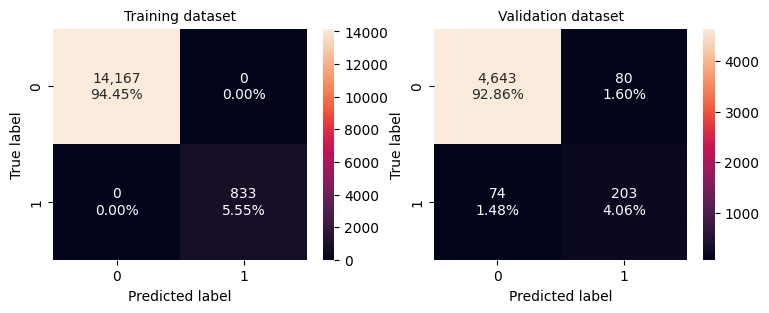

Model performance:



LogisticRegression:                                                                                   


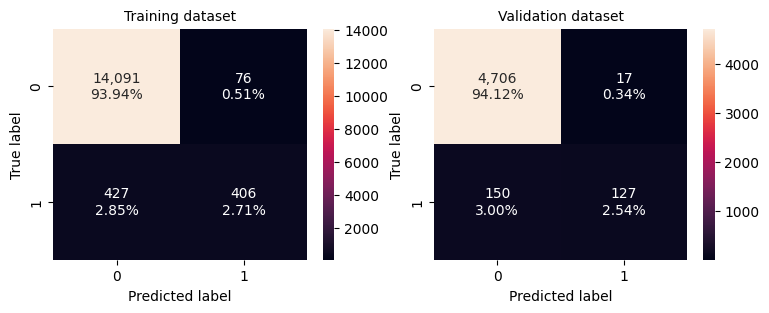

Model performance:



RandomForestClassifier:                                                                               


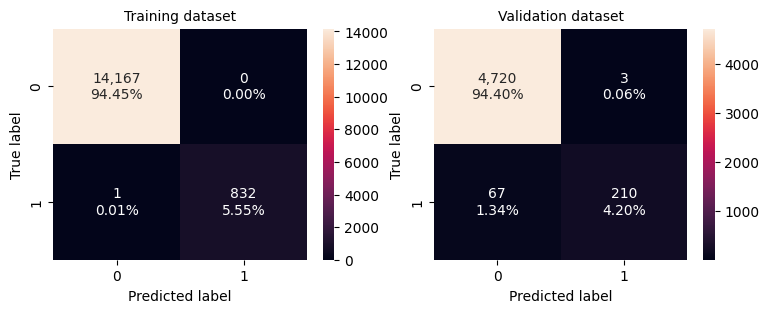

Model performance:



BaggingClassifier:                                                                                    


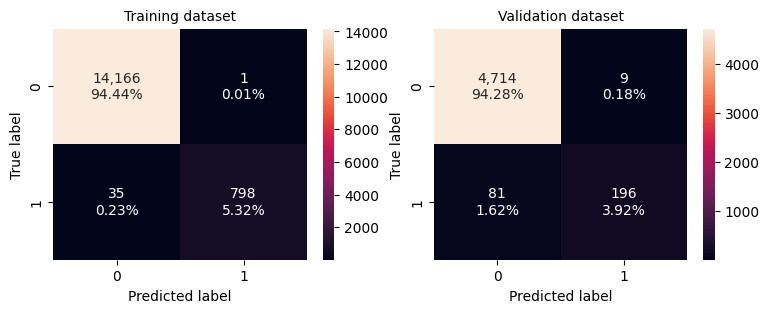

Model performance:



AdaBoostClassifier:                                                                                   


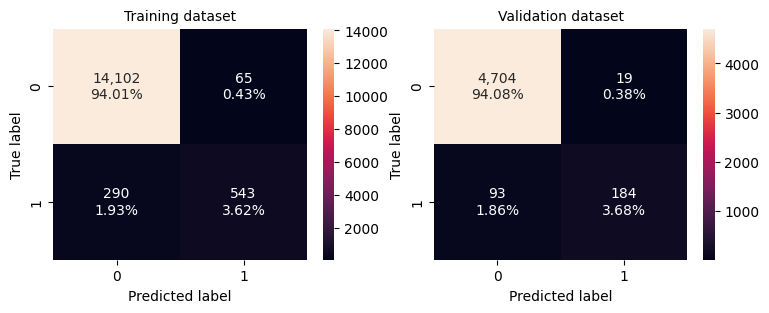

Model performance:



GradientBoostingClassifier:                                                                           


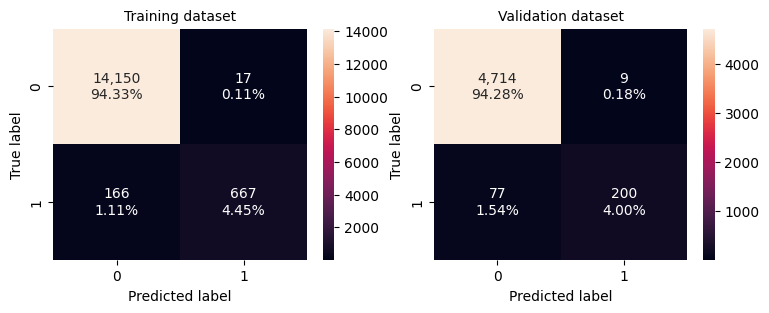

Model performance:



XGBClassifier:                                                                                        


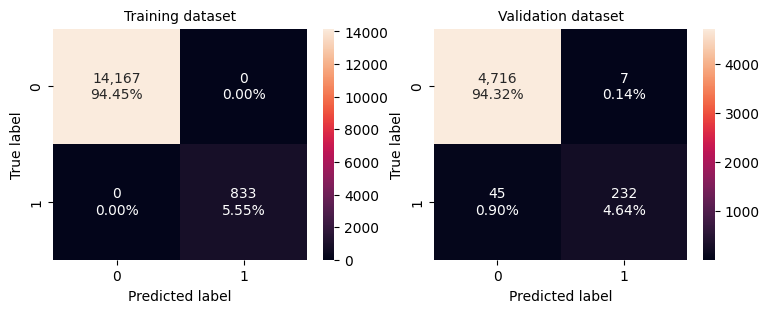

Model performance:


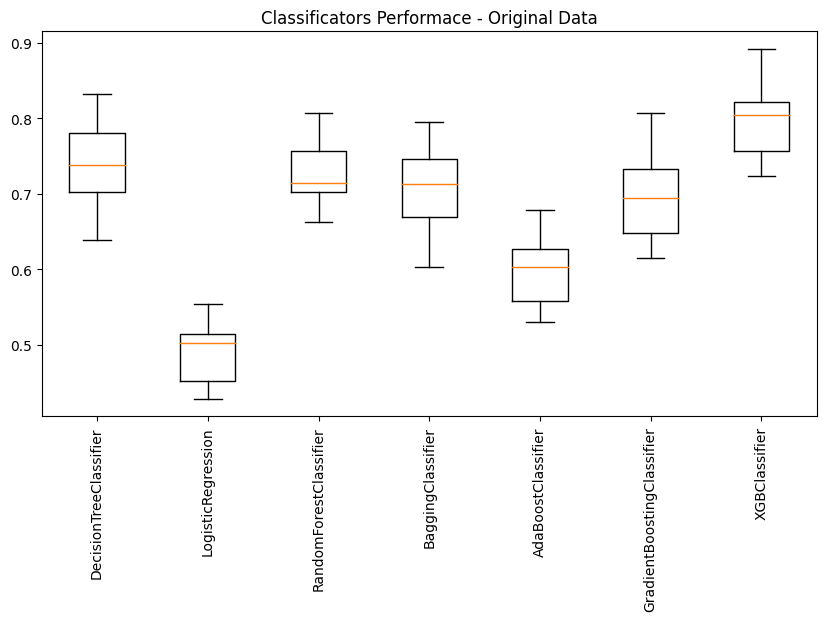

In [49]:
res_orig = cv_simple(models_grid, X_train, y_train, X_valid, y_valid, title='Original')

In [50]:
res_orig

index  Accuracy  Precision    Recall       NPV  Specificity  \
0     Training  1.000000   1.000000  1.000000  1.000000     1.000000   
1   Validation  0.969200   0.717314  0.732852  0.984312     0.983062   
2     Training  0.966467   0.842324  0.487395  0.970588     0.994635   
3   Validation  0.966600   0.881944  0.458484  0.969110     0.996401   
4     Training  0.999933   1.000000  0.998800  0.999929     1.000000   
5   Validation  0.986000   0.985915  0.758123  0.986004     0.999365   
6     Training  0.997600   0.998748  0.957983  0.997535     0.999929   
7   Validation  0.982000   0.956098  0.707581  0.983107     0.998094   
8     Training  0.976333   0.893092  0.651861  0.979850     0.995412   
9   Validation  0.977600   0.906404  0.664260  0.980613     0.995977   
10    Training  0.987800   0.975146  0.800720  0.988405     0.998800   
11  Validation  0.982800   0.956938  0.722022  0.983928     0.998094   
12    Training  1.000000   1.000000  1.000000  1.000000     1.000000   
13  Validation  0.989600   0.970711  0.837545  0.990548     0.998518   

          F1    duration  cv_recall                       model  
0   1.000000   18.276706   0.740620      DecisionTreeClassifier  
1   0.725000    2.138366        NaN      DecisionTreeClassifier  
2   0.617490    0.587506   0.489802          LogisticRegression  
3   0.603325    0.058208        NaN          LogisticRegression  
4   0.999399  139.675461   0.727496      RandomForestClassifier  
5   0.857143   15.562946        NaN      RandomForestClassifier  
6   0.977941  108.716687   0.708161           BaggingClassifier  
7   0.813278   12.694744        NaN           BaggingClassifier  
8   0.753643   48.776676   0.596644          AdaBoostClassifier  
9   0.766667    5.226020        NaN          AdaBoostClassifier  
10  0.879367  242.121486   0.696328  GradientBoostingClassifier  
11  0.823045   26.894625        NaN  GradientBoostingClassifier  
12  1.000000  106.620129   0.795869               XGBClassifier  
13  0.899225   11.581028        NaN               XGBClassifier

**Observations:**
* **XGBClassifier** performs best on both the training and validation datasets, making it the most promising model for this dataset.

* **RandomForestClassifier** and **DecisionTreeClassifier** also demonstrate good performance on both datasets, and they could be considered as alternative models.

* **GradientBoostingClassifier** and **BaggingClassifier** exhibit moderate performance on the training dataset and reasonable performance on the validation dataset.

* **LogisticRegression** and **AdaBoostClassifier** show below-average performance on both the training and validation datasets, indicating that they may not be suitable models for this specific problem.

* The decision-tree-based algorithms (DecisionTreeClassifier, BaggingClassifier, RandomForestClassifier) seem to exhibit overfitting, as evidenced by the high recall on the training set, approaching or equal to 1, in contrast to the considerably lower recall observed on the validation dataset.

* The initial models employing boosting algorithms show no significant overfitting, as evidenced by their consistent performance on both the training and validation datasets.

* The **XGBClassifier** model demonstrates very good performance in terms of recall on the validation dataset compared to other models. This indicates that it is the most effective at identifying true positives, minimizing the number of false negatives.

* Among the models in our training data, the median recall score of **XGBClassifier** is the highest.

* In addition to delivering the highest recall score for the validation dataset, the **XGBClassifier** model has a relatively efficient learning duration. While some other models take longer to train, **XGBClassifier** achieves superior performance with a shorter training time, making it a more time-effective choice. This balance between performance and learning duration emphasizes the suitability of **XGBClassifier** for our problem.

* Given these findings, **XGBClassifier** is the top-performing model for our dataset. However, **RandomForestClassifier** and **DecisionTreeClassifier** could also be viable options if properly optimized.

### Model Building with Oversampled data



Cross-Validation performance on training dataset:

	DecisionTreeClassifier: 0.97184
		Iteration duration: 21.93 seconds
	LogisticRegression: 0.87393
		Iteration duration: 1.37 seconds
	RandomForestClassifier: 0.98482
		Iteration duration: 191.60 seconds
	BaggingClassifier: 0.97551
		Iteration duration: 137.09 seconds
	AdaBoostClassifier: 0.89229
		Iteration duration: 96.17 seconds
	GradientBoostingClassifier: 0.92398
		Iteration duration: 468.36 seconds
	XGBClassifier: 0.99054
		Iteration duration: 226.97 seconds

Validation Performance:

	DecisionTreeClassifier: 0.76534
		Iteration duration: 2.58 seconds
	LogisticRegression: 0.87726
		Iteration duration: 0.19 seconds
	RandomForestClassifier: 0.85921
		Iteration duration: 21.77 seconds
	BaggingClassifier: 0.83032
		Iteration duration: 15.60 seconds
	AdaBoostClassifier: 0.88809
		Iteration duration: 11.02 seconds
	GradientBoostingClassifier: 0.89531
		Iteration duration: 52.77 seconds
	XGBClassifier: 0.89170
		Iteration duration: 25.28

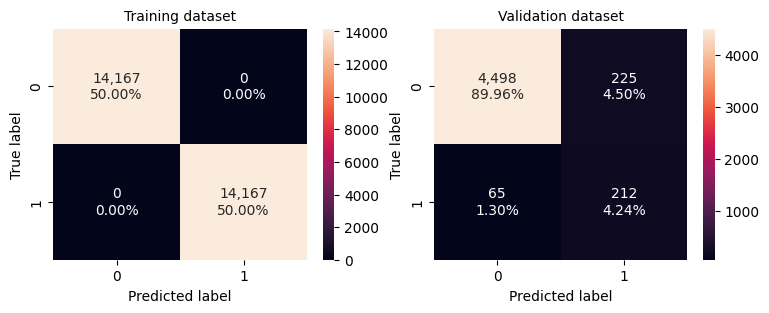

Model performance:



LogisticRegression:                                                                                   


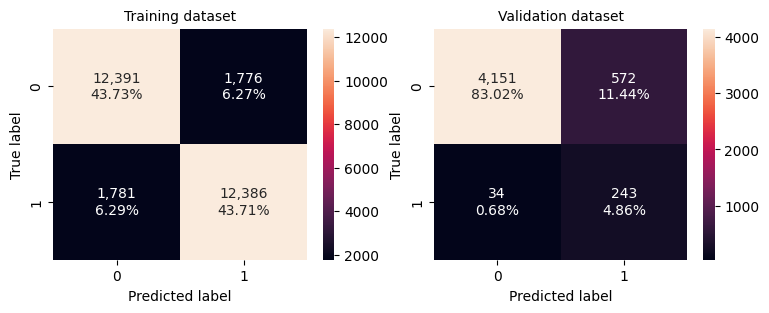

Model performance:



RandomForestClassifier:                                                                               


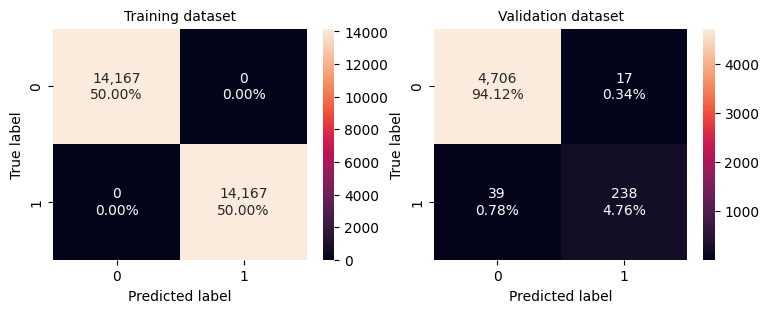

Model performance:



BaggingClassifier:                                                                                    


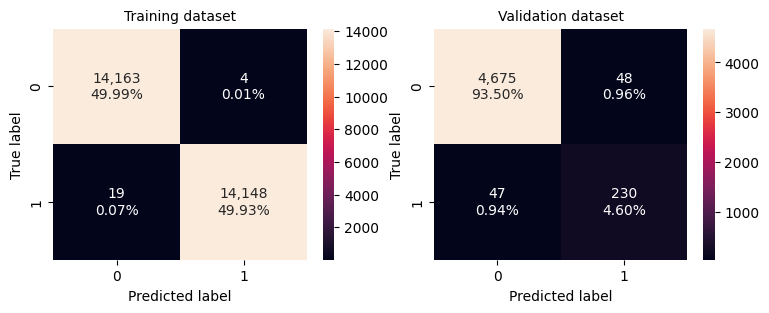

Model performance:



AdaBoostClassifier:                                                                                   


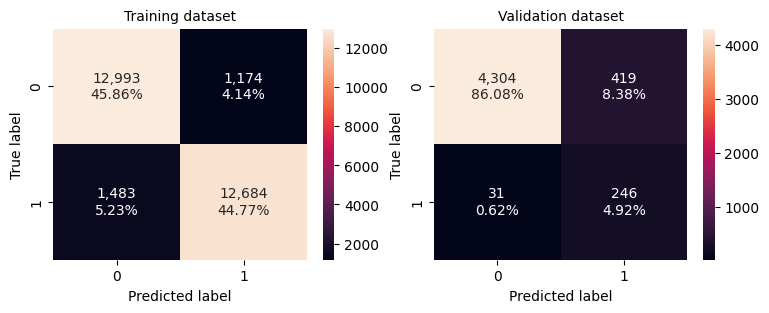

Model performance:



GradientBoostingClassifier:                                                                           


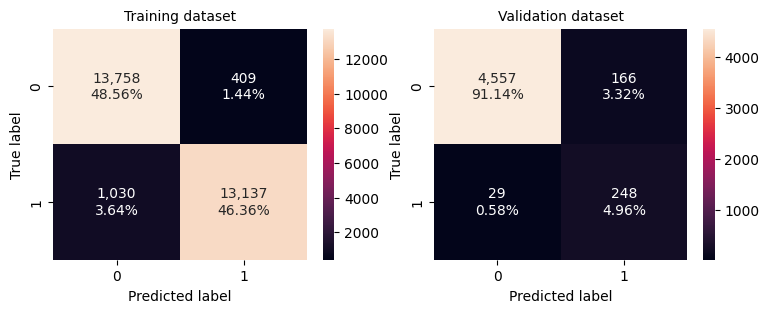

Model performance:



XGBClassifier:                                                                                        


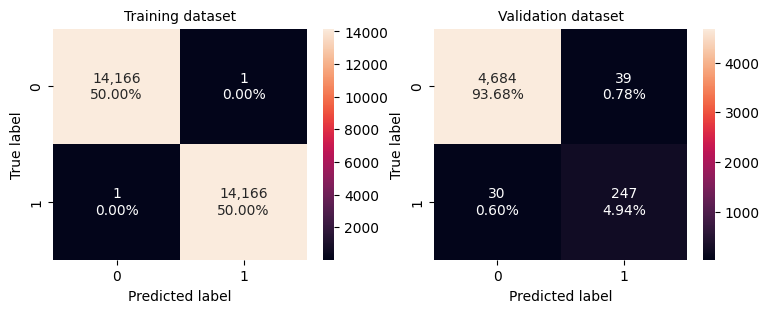

Model performance:


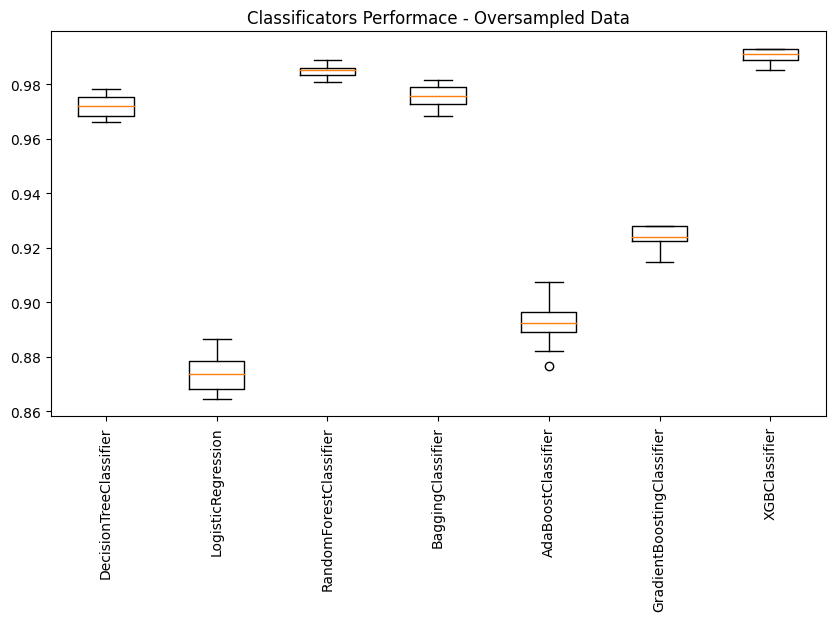

In [51]:
res_over = cv_simple(models_grid, X_train_over, y_train_over, X_valid, y_valid, title='Oversampled')

In [52]:
res_over

index  Accuracy  Precision    Recall       NPV  Specificity  \
0     Training  1.000000   1.000000  1.000000  1.000000     1.000000   
1   Validation  0.942000   0.485126  0.765343  0.985755     0.952361   
2     Training  0.874462   0.874594  0.874285  0.874330     0.874638   
3   Validation  0.878800   0.298160  0.877256  0.991876     0.878891   
4     Training  1.000000   1.000000  1.000000  1.000000     1.000000   
5   Validation  0.988800   0.933333  0.859206  0.991781     0.996401   
6     Training  0.999188   0.999717  0.998659  0.998660     0.999718   
7   Validation  0.981000   0.827338  0.830325  0.990047     0.989837   
8     Training  0.906226   0.915284  0.895320  0.897555     0.917131   
9   Validation  0.910000   0.369925  0.888087  0.992849     0.911285   
10    Training  0.949213   0.969807  0.927296  0.930349     0.971130   
11  Validation  0.961000   0.599034  0.895307  0.993676     0.964853   
12    Training  0.999929   0.999929  0.999929  0.999929     0.999929   
13  Validation  0.986200   0.863636  0.891697  0.993636     0.991743   

          F1    duration  cv_recall                       model  
0   1.000000   21.925469   0.971836      DecisionTreeClassifier  
1   0.593838    2.580847        NaN      DecisionTreeClassifier  
2   0.874440    1.365862   0.873933          LogisticRegression  
3   0.445055    0.186492        NaN          LogisticRegression  
4   1.000000  191.593849   0.984824      RandomForestClassifier  
5   0.894737   21.773816        NaN      RandomForestClassifier  
6   0.999188  137.088547   0.975506           BaggingClassifier  
7   0.828829   15.595947        NaN           BaggingClassifier  
8   0.905192   96.166766   0.892286          AdaBoostClassifier  
9   0.522293   11.014912        NaN          AdaBoostClassifier  
10  0.948075  468.356503   0.923979  GradientBoostingClassifier  
11  0.717800   52.771510        NaN  GradientBoostingClassifier  
12  0.999929  226.971239   0.990542               XGBClassifier  
13  0.877442   25.277743        NaN               XGBClassifier

**Observations:**

Using the **oversampled** data, we observe the following:

* Both **XGBClassifier** and **GradientBoostingClassifier** demonstrate the highest performance on the training and validation datasets, indicating that they are the most promising models for our dataset.

* In terms of validation performance, **AdaBoostClassifier** achieves relatively high scores, indicating that it generalizes well to unseen data.

* While **DecisionTreeClassifier**, **RandomForestClassifier**, and **BaggingClassifier** show high scores on the training dataset, their performance on the validation dataset is comparatively lower, suggesting that they might be overfitting to the training data.

* **LogisticRegression** has demonstrated a significant improvement in performance when applied to oversampled data compared to the original training dataset. Nevertheless, it still shows lower values for the performance metric when compared to other models.

* Learning durations for the models vary significantly, with **LogisticRegression** being the fastest and **GradientBoostingClassifier** taking the longest time to train.

Based on these findings, **XGBClassifier** remains promising model for the oversampled dataset. However, **AdaBoostClassifier** and **GradientBoostingClassifier** also show good performance on the validation dataset, and they could be considered as alternative options with proper optimization.

Upon analyzing the model performance on oversampled data, we observe some  overfitting concerning our Recall measure for DecisionTree, RandomForest and Bagging classifiers.
  - This overfitting may result in poor generalization when applied to test data or in a production environment.
  - To address this issue, it is crucial to improve the model's performance by reducing overfitting and achieving a better balance between recall and other evaluation metrics.

### Model Building with Undersampled data


Cross-Validation performance on training dataset:

	DecisionTreeClassifier: 0.85851
		Iteration duration: 0.84 seconds
	LogisticRegression: 0.85711
		Iteration duration: 0.25 seconds
	RandomForestClassifier: 0.89924
		Iteration duration: 9.02 seconds
	BaggingClassifier: 0.87279
		Iteration duration: 4.60 seconds
	AdaBoostClassifier: 0.86681
		Iteration duration: 5.53 seconds
	GradientBoostingClassifier: 0.89203
		Iteration duration: 23.07 seconds
	XGBClassifier: 0.89924
		Iteration duration: 10.64 seconds

Validation Performance:

	DecisionTreeClassifier: 0.84838
		Iteration duration: 0.10 seconds
	LogisticRegression: 0.88087
		Iteration duration: 0.03 seconds
	RandomForestClassifier: 0.91336
		Iteration duration: 1.00 seconds
	BaggingClassifier: 0.85560
		Iteration duration: 0.54 seconds
	AdaBoostClassifier: 0.87726
		Iteration duration: 0.64 seconds
	GradientBoostingClassifier: 0.90253
		Iteration duration: 2.55 seconds
	XGBClassifier: 0.90253
		Iteration duration: 2.47 seconds

Dec

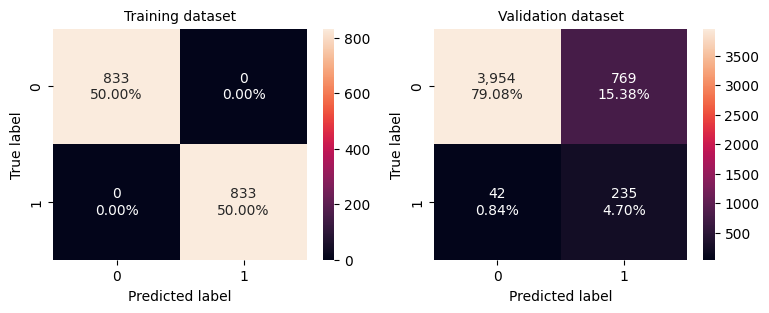

Model performance:



LogisticRegression:                                                                                   


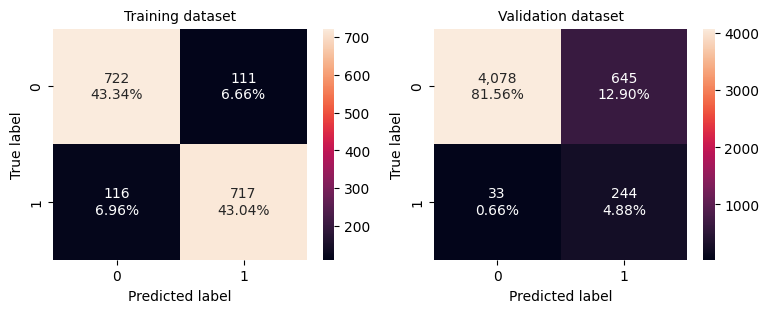

Model performance:



RandomForestClassifier:                                                                               


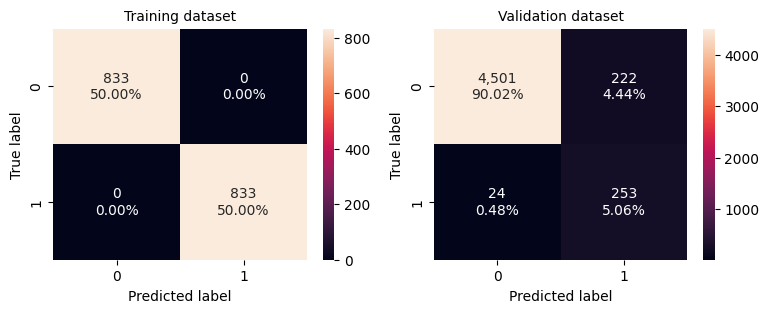

Model performance:



BaggingClassifier:                                                                                    


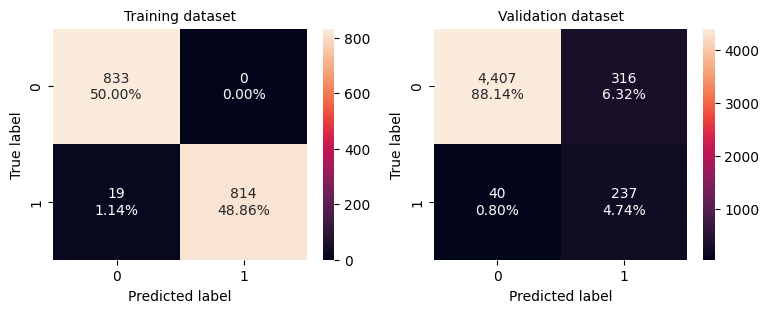

Model performance:



AdaBoostClassifier:                                                                                   


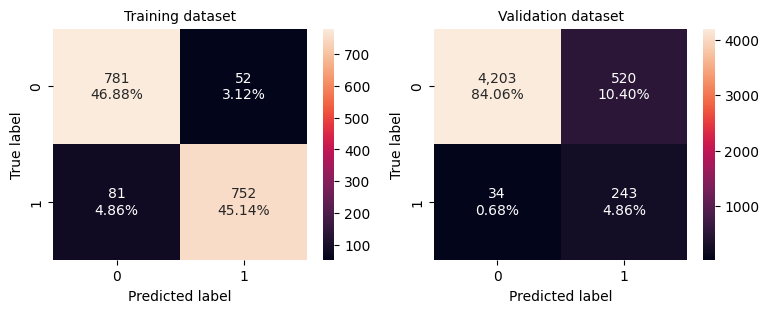

Model performance:



GradientBoostingClassifier:                                                                           


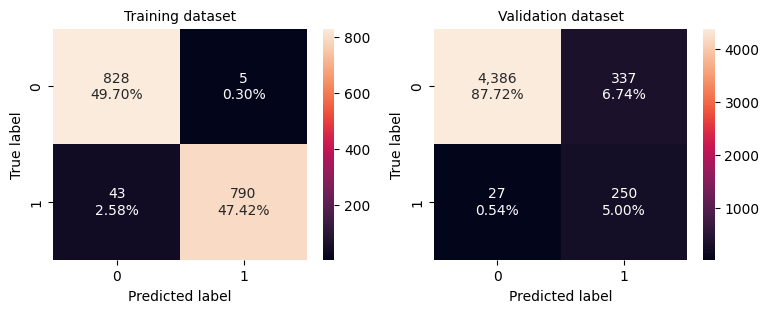

Model performance:



XGBClassifier:                                                                                        


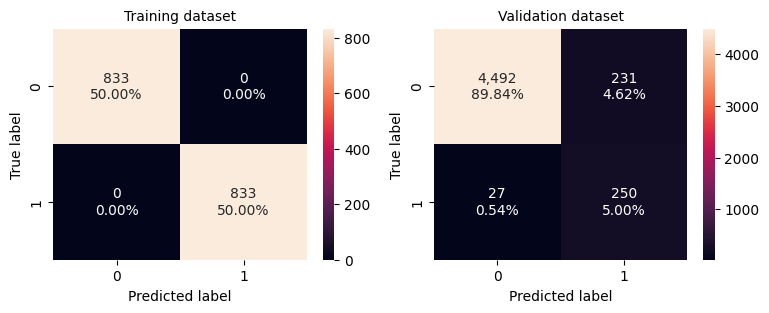

Model performance:


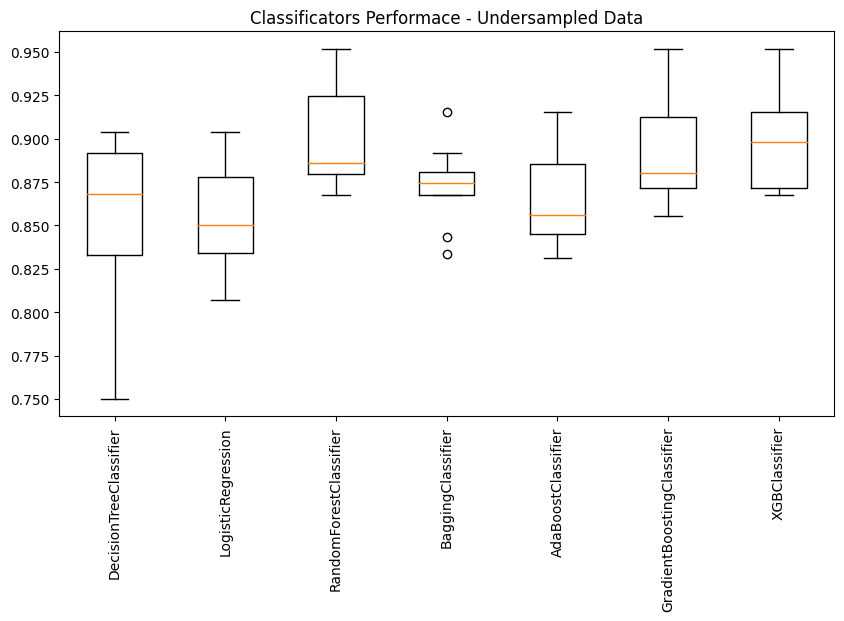

In [53]:
res_un = cv_simple(models_grid, X_train_un, y_train_un, X_valid, y_valid, title='Undersampled')

In [54]:
res_un

index  Accuracy  Precision    Recall       NPV  Specificity  \
0     Training  1.000000   1.000000  1.000000  1.000000     1.000000   
1   Validation  0.837800   0.234064  0.848375  0.989489     0.837180   
2     Training  0.863745   0.865942  0.860744  0.861575     0.866747   
3   Validation  0.864400   0.274466  0.880866  0.991973     0.863434   
4     Training  1.000000   1.000000  1.000000  1.000000     1.000000   
5   Validation  0.950800   0.532632  0.913357  0.994696     0.952996   
6     Training  0.988595   1.000000  0.977191  0.977700     1.000000   
7   Validation  0.928800   0.428571  0.855596  0.991005     0.933093   
8     Training  0.920168   0.935323  0.902761  0.906032     0.937575   
9   Validation  0.889200   0.318480  0.877256  0.991975     0.889900   
10    Training  0.971188   0.993711  0.948379  0.950631     0.993998   
11  Validation  0.927200   0.425894  0.902527  0.993882     0.928647   
12    Training  1.000000   1.000000  1.000000  1.000000     1.000000   
13  Validation  0.948400   0.519751  0.902527  0.994025     0.951090   

          F1   duration  cv_recall                       model  
0   1.000000   0.843659   0.858505      DecisionTreeClassifier  
1   0.366901   0.094575        NaN      DecisionTreeClassifier  
2   0.863335   0.252838   0.857114          LogisticRegression  
3   0.418525   0.026560        NaN          LogisticRegression  
4   1.000000   9.019661   0.899240      RandomForestClassifier  
5   0.672872   0.994174        NaN      RandomForestClassifier  
6   0.988464   4.604301   0.872791           BaggingClassifier  
7   0.571084   0.541749        NaN           BaggingClassifier  
8   0.918754   5.526041   0.866810          AdaBoostClassifier  
9   0.467308   0.643924        NaN          AdaBoostClassifier  
10  0.970516  23.070930   0.892025  GradientBoostingClassifier  
11  0.578704   2.552907        NaN  GradientBoostingClassifier  
12  1.000000  10.641260   0.899240               XGBClassifier  
13  0.659631   2.471798        NaN               XGBClassifier

**Observations:**

Using the **undersampled** data, we can make the following observations:

* When comparing the performance of models trained on original, undersampled, and oversampled data, the Recall metric appears to be more consistent for models trained on undersampled data.

* **RandomForestClassifier** displays the highest performance on the training and validation datasets, indicating its potential as the most promising model for our dataset

* Both **XGBClassifier** and **GradientBoostingClassifier** achieve very good scores, suggesting good generalization to unseen data.

* **LogisticRegression**, **BaggingClassifier**, and **AdaBoostClassifier** demonstrate moderate performance on both training and validation datasets.

* Learning durations for the models are generally shorter compared to the oversampled data scenario, with **LogisticRegression** being the fastest and **GradientBoostingClassifier** taking the longest time to train.

Based on these findings, **RandomForestClassifier**, **GradientBoostingClassifier**, and **XGBClassifier** emerge as the top-performing models for the underdamped dataset. However, it is important to fine-tune and optimize these models to achieve even better performance.

### Consolidated resultas

In [55]:
# Resulting columns show in percentage
col_perc = ['Accuracy', 'Precision', 'Recall', 'NPV', 'Specificity', 'F1']

In [56]:
res_orig['model'] += ' (original)'
res_over['model'] += ' (oversampled)'
res_un['model'] += ' (undersampled)'

In [57]:
results = pd.concat([res_orig, res_over, res_un], axis=0)

In [58]:
print(f"\n{'-'*120}\n   Performance metrics of models trained on original, oversampled, and undersampled subsets of the training dataset\n{'-'*120}\n")
results[results['index']=='Training'].set_index('model').drop('index', axis=1)\
  .sort_values(by=['Recall', 'duration'], ascending=[False, True]).style\
  .format('{:.2f}')\
  .format('{:.2%}', subset=col_perc+['cv_recall'])


------------------------------------------------------------------------------------------------------------------------
   Performance metrics of models trained on original, oversampled, and undersampled subsets of the training dataset
------------------------------------------------------------------------------------------------------------------------



In [59]:
print(f"\n{'-'*123}\nPerformance metrics of models trained on original, oversampled, and undersampled subsets of the validation dataset (Recall)\n{'-'*123}\n")

results[results['index']=='Validation'].set_index('model').drop(['index', 'cv_recall'], axis=1)\
  .sort_values(by=['Recall', 'duration'], ascending=[False, True]).style\
  .set_table_styles([dict(selector="th", props=[('min-width', '75px'), 
                                                ('text-align', 'right')])])\
  .highlight_max(color='lightgreen', axis=0, subset=col_perc)\
  .highlight_min(color='lightgreen', axis=0, subset=['duration'])\
  .format('{:.2f}')\
  .format('{:.2%}', subset=col_perc)


---------------------------------------------------------------------------------------------------------------------------
Performance metrics of models trained on original, oversampled, and undersampled subsets of the validation dataset (Recall)
---------------------------------------------------------------------------------------------------------------------------



In [60]:
print(f"\n{'-'*122}\n   Performance metrics of models trained on original, oversampled, and undersampled subsets of the validation dataset (F1)\n{'-'*122}\n")

results[results['index']=='Validation'].set_index('model').drop(['index', 'cv_recall'], axis=1)\
  .sort_values(by=['F1', 'duration'], ascending=[False, True]).style\
  .set_table_styles([dict(selector="th", props=[('min-width', '75px'), 
                                                ('text-align', 'right')])])\
  .highlight_max(color='lightgreen', axis=0, subset=col_perc)\
  .highlight_min(color='lightgreen', axis=0, subset=['duration'])\
  .format('{:.2f}')\
  .format('{:.2%}', subset=col_perc)


--------------------------------------------------------------------------------------------------------------------------
   Performance metrics of models trained on original, oversampled, and undersampled subsets of the validation dataset (F1)
--------------------------------------------------------------------------------------------------------------------------



**Observations:**

1. **XGBClassifier** and **RandomForestClassifier** consistently perform well across different datasets, particularly when using undersampled and oversampled data. These two models achieve high recall scores, which is a key performance metric for our task, as **minimizing false negatives** is a priority.

2. **GradientBoostingClassifier** also shows strong performance, especially when using undersampled and oversampled data. However, it takes considerably longer to train compared to **XGBClassifier** and **RandomForestClassifier**.

3. **LogisticRegression** and **AdaBoostClassifier** achieve moderate recall scores when trained on undersampled and oversampled data, but their performance is lower when using the original dataset.

4. The decision tree-based models, **DecisionTreeClassifier** and **BaggingClassifier**, demonstrate varied performance across the different datasets. They have lower recall scores when trained on the original data compared to the undersampled and oversampled datasets.

In terms of duration, **LogisticRegression** is the fastest model to train, while **GradientBoostingClassifier** generally takes the longest.

Overall, **XGBClassifier** and **RandomForestClassifier** are the top-performing models in terms of recall scores, particularly when trained on undersampled and oversampled data. These models could be the best choice as our main goal is to maximize recall. Additionally, fine-tuning and optimizing the models could lead to even better performance.

## Hyperparameter Tuning 

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:
```
  param_grid = {
      'n_estimators': np.arange(100, 150, 25),
      'learning_rate': [0.2, 0.05, 1],
      'subsample': [0.5, 0.7], 
      'max_features': [0.5, 0.7]
  }

- For Adaboost:
```
  param_grid = {
      'n_estimators': [100, 150, 200],
      'learning_rate': [0.2, 0.05],
      'base_estimator': [DecisionTreeClassifier(max_depth=1, random_state=42),
                         DecisionTreeClassifier(max_depth=2, random_state=42)
                         DecisionTreeClassifier(max_depth=3, random_state=42)]
  }

- For Bagging Classifier:
```
  param_grid = {
      'max_samples': [0.8, 0.9, 1], 
      'max_features': [0.7, 0.8, 0.9],
      'n_estimators' : [30, 50, 70],
  }

- For Random Forest:
```
  param_grid = {
      'n_estimators': [200, 250, 300],
      'min_samples_leaf': np.arange(1, 4),
      'max_features': [np.arange(0.3, 0.6, 0.1), 'sqrt'],
      'max_samples': np.arange(0.4, 0.7, 0.1)
  }

- For Decision Trees:
```
  param_grid = {
      'max_depth': np.arange(2, 6), 
      'min_samples_leaf': [1, 4, 7],
      'max_leaf_nodes' : [10, 15],
      'min_impurity_decrease': [0.0001, 0.001]
  }

- For Logistic Regression:
```
  param_grid = {
    'C': np.arange(0.1, 1.1, 0.1)
  }

- For XGBoost:
```
  param_grid = {
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5, 10],
    'learning_rate': [0.1, 0.2],
    'gamma': [0, 3,5],
    'subsample': [0.8, 0.9]
  }
```

>We need to identify at least three top-performing models from all previously constructed models.

- We have chosen the following classifiers based on their performance in terms of Recall and F1 scores, as observed during previous stages of model building with default hyperparameters:
  - RandomForestClassifier
  - GradientBoostingClassifier
  - XGBClassifier

- These classifiers have demonstrated a strong ability to accurately identify positive instances while also maintaining a balanced trade-off between precision and recall.

- These classifiers will be fitted on each of the three datasets: original, oversampled, and undersampled.

In [61]:
clfs = ['RandomForestClassifier', 'GradientBoostingClassifier', 'XGBClassifier']

models_tuned_grid = list(filter(lambda clf: clf[0] in clfs, models_grid))

### Tuning RF, GBM, and XGB models using the original dataset


RandomForestClassifier:                                                                               
	Best parameters are:
		n_estimators: 250
		min_samples_leaf: 2
		max_samples: 0.6
		max_features: sqrt
	CV score=0.68666
	Iteration duration: 351.70 seconds
-----------------------------------------------------------------------------------------------------


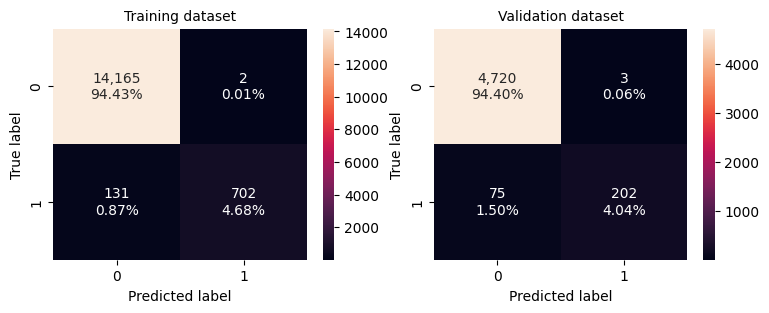

Model performance:



GradientBoostingClassifier:                                                                           
	Best parameters are:
		subsample: 0.7
		n_estimators: 100
		max_features: 0.7
		learning_rate: 0.2
	CV score=0.73590
	Iteration duration: 313.59 seconds
-----------------------------------------------------------------------------------------------------


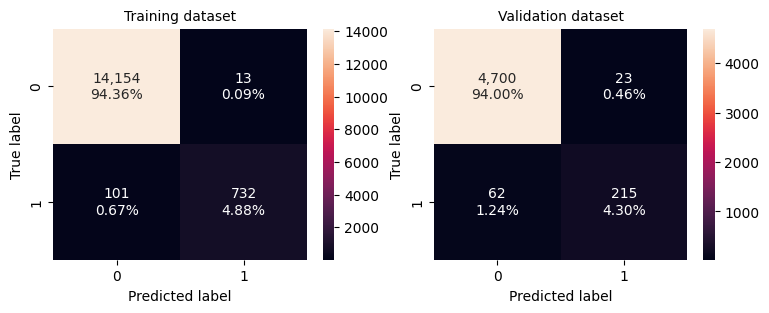

Model performance:



XGBClassifier:                                                                                        
	Best parameters are:
		subsample: 0.8
		scale_pos_weight: 10
		n_estimators: 250
		learning_rate: 0.1
		gamma: 3
	CV score=0.84514
	Iteration duration: 866.33 seconds
-----------------------------------------------------------------------------------------------------


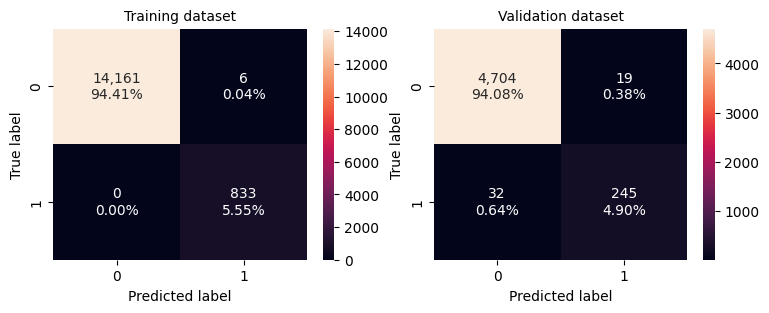

Model performance:


In [62]:
res_tuned_orig = cv_tuned(models_tuned_grid, X_train, y_train, X_valid, y_valid, 'original')

### Tuning RF, GBM, and XGB models using the oversampled dataset


RandomForestClassifier:                                                                               
	Best parameters are:
		n_estimators: 200
		min_samples_leaf: 2
		max_samples: 0.6
		max_features: sqrt
	CV score=0.97508
	Iteration duration: 518.66 seconds
-----------------------------------------------------------------------------------------------------


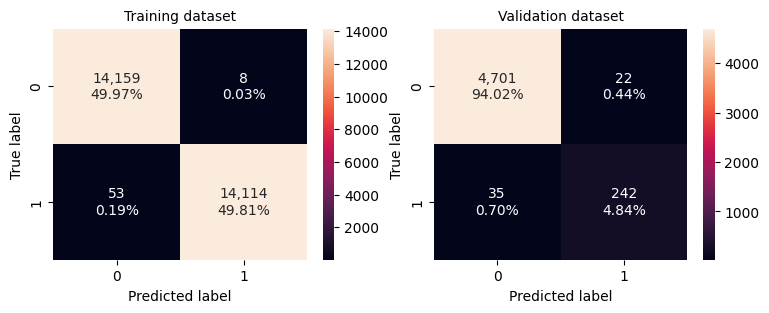

Model performance:



GradientBoostingClassifier:                                                                           
	Best parameters are:
		subsample: 0.5
		n_estimators: 125
		max_features: 0.5
		learning_rate: 1
	CV score=0.95786
	Iteration duration: 615.83 seconds
-----------------------------------------------------------------------------------------------------


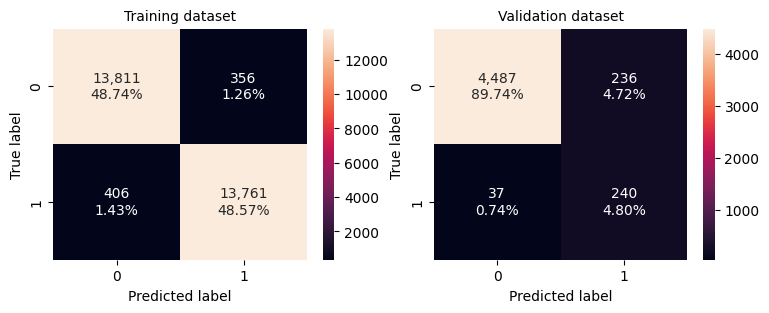

Model performance:



XGBClassifier:                                                                                        
	Best parameters are:
		subsample: 0.8
		scale_pos_weight: 10
		n_estimators: 250
		learning_rate: 0.1
		gamma: 0
	CV score=0.99626
	Iteration duration: 1767.25 seconds
-----------------------------------------------------------------------------------------------------


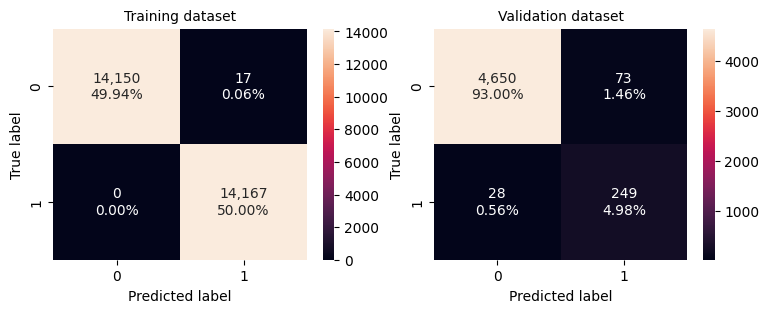

Model performance:


In [63]:
res_tuned_over = cv_tuned(models_tuned_grid, X_train_over, y_train_over, X_valid, y_valid, 'oversampled')

### Tuning RF, GBM, and XGB models using the undersampled dataset


RandomForestClassifier:                                                                               
	Best parameters are:
		n_estimators: 300
		min_samples_leaf: 2
		max_samples: 0.4
		max_features: sqrt
	CV score=0.89676
	Iteration duration: 25.02 seconds
-----------------------------------------------------------------------------------------------------


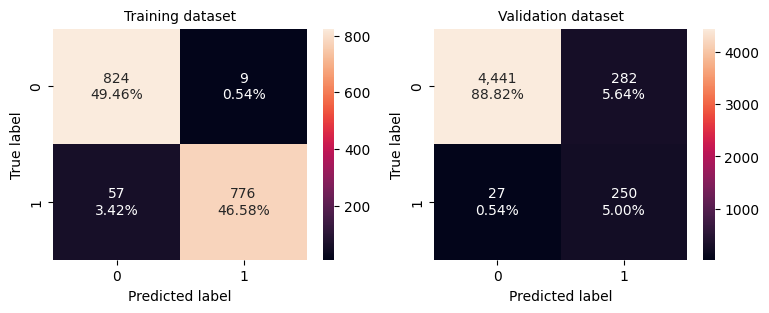

Model performance:



GradientBoostingClassifier:                                                                           
	Best parameters are:
		subsample: 0.5
		n_estimators: 100
		max_features: 0.5
		learning_rate: 0.2
	CV score=0.90036
	Iteration duration: 32.66 seconds
-----------------------------------------------------------------------------------------------------


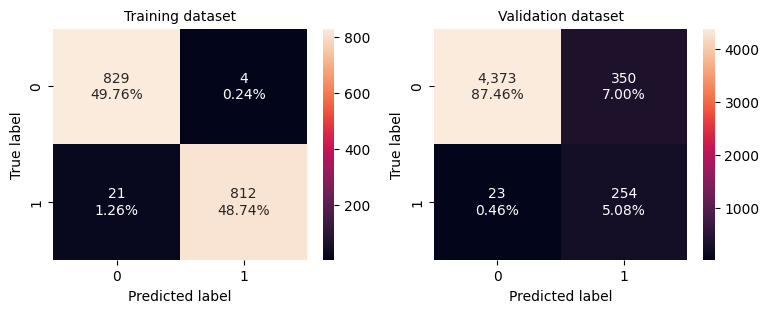

Model performance:



XGBClassifier:                                                                                        
	Best parameters are:
		subsample: 0.8
		scale_pos_weight: 10
		n_estimators: 200
		learning_rate: 0.1
		gamma: 5
	CV score=0.92557
	Iteration duration: 90.53 seconds
-----------------------------------------------------------------------------------------------------


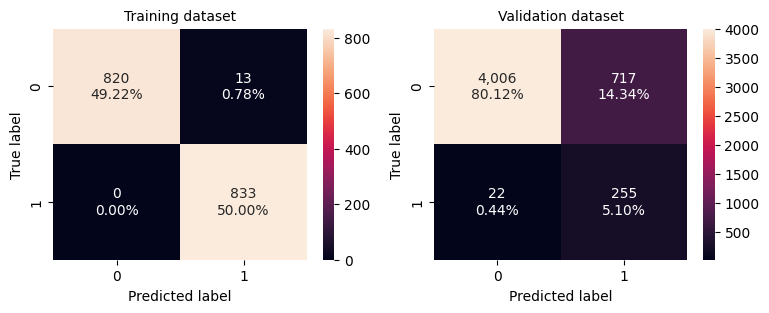

Model performance:


In [64]:
res_tuned_un = cv_tuned(models_tuned_grid, X_train_un, y_train_un, X_valid, y_valid, 'undersampled')

In [65]:
res_tuned_orig['model'] += ' (original)'
res_tuned_over['model'] += ' (oversampled)'
res_tuned_un['model'] += ' (undersampled)'

results_tuned = pd.concat([res_tuned_orig, res_tuned_over, res_tuned_un], axis=0).drop('best_params', axis=1)

## Model performance comparison and choosing the final model

In [66]:
results_tuned[results_tuned['index']=='Training'].set_index('model').drop('index', axis=1)\
  .sort_values(by=['Recall', 'duration'], ascending=[False, True]).style\
  .format('{:.2f}')\
  .format('{:.2%}', subset=col_perc)

In [67]:
results_tuned[results_tuned['index']=='Validation'].set_index('model').drop('index', axis=1)\
  .sort_values(by=['Recall', 'duration'], ascending=[False, True]).style\
  .set_table_styles([dict(selector="th", props=[('min-width', '75px'), 
                                                ('text-align', 'right')])])\
  .highlight_max(subset=col_perc, color='lightgreen', axis=0)\
  .highlight_min(subset=['duration'], color='lightgreen', axis=0)\
  .format('{:.2f}')\
  .format('{:.2%}', subset=col_perc)
  

> Since we are focusing on recall, below is a summary of the top 3 models with the highest recall scores:


1. XGBClassifier (undersampled):
  - Recall: 92.06%
  - F1 Score: 40.83%

2. GradientBoostingClassifier (undersampled):
  - Recall: 91.70%
  - F1 Score: 57.66%

3. RandomForestClassifier (undersampled):
  - Recall: 90.25%
  - F1 Score: 61.80%


* Even though these models trained on an undersampled dataset have a high Recall, their Precision, and consequently F1 score, is quite low. This indicates that the models have a high Type I error rate, meaning they produce many False Positive (FP) predictions. FP are detections where there is no failure, which result in inspection costs.

* While inspection is the least expensive operation, a high number of such errors can still lead to significant overall costs. Moreover, there is a possibility that resources needed for more costly operations, such as replacement and repair, will be tied up in inspections, which may result in delays of urgent and important operations and additional expenses.

* As a result, we need to strike a balance between Recall and Precision. Unfortunately, we lack specific information about the costs of various operations. We only know that repairing a generator costs significantly less than replacing it, and the cost of inspection is lower than the cost of repair.

> Additionally, for double-check, let's assume that the cost of repair is 1/10 the cost of replacement, and the cost of inspection is 1/5 of the repair cost, and see what are the possible costs of different models.

In [68]:
cost = results_tuned[results_tuned['index']=='Validation']\
  .set_index('model').drop('index', axis=1)

length = y_valid.count()
positive = y_valid.sum()
negative = length - positive

# FN (replacement) cost
replace_cost = 1.0

# TP (repair) cost
repair_cost = replace_cost / 10

# FP (inspection) cost
inspection_cost = repair_cost / 2

cost['repair (TP)'] = cost['Recall'] * positive
cost['replace (FN)'] = positive - cost['repair (TP)']
cost['inspection (FP)'] = negative * (1 - cost['Specificity'])
cost['cost'] = cost['repair (TP)'] * repair_cost + \
               cost['replace (FN)'] * replace_cost + \
               cost['inspection (FP)'] * inspection_cost

cost.iloc[:,-5:].sort_values('cost')

duration  repair (TP)  \
model                                                                 
XGBClassifier (oversampled)                1767.240445        249.0   
XGBClassifier (original)                    866.321799        245.0   
RandomForestClassifier (oversampled)        518.655441        242.0   
GradientBoostingClassifier (undersampled)    32.658896        254.0   
RandomForestClassifier (undersampled)        25.011586        250.0   
GradientBoostingClassifier (oversampled)    615.831026        240.0   
XGBClassifier (undersampled)                 90.525579        255.0   
GradientBoostingClassifier (original)       313.589346        215.0   
RandomForestClassifier (original)           351.694661        202.0   

                                           replace (FN)  inspection (FP)  \
model                                                                      
XGBClassifier (oversampled)                        28.0             73.0   
XGBClassifier (original)                           32.0             19.0   
RandomForestClassifier (oversampled)               35.0             22.0   
GradientBoostingClassifier (undersampled)          23.0            350.0   
RandomForestClassifier (undersampled)              27.0            282.0   
GradientBoostingClassifier (oversampled)           37.0            236.0   
XGBClassifier (undersampled)                       22.0            717.0   
GradientBoostingClassifier (original)              62.0             23.0   
RandomForestClassifier (original)                  75.0              3.0   

                                            cost  
model                                             
XGBClassifier (oversampled)                56.55  
XGBClassifier (original)                   57.45  
RandomForestClassifier (oversampled)       60.30  
GradientBoostingClassifier (undersampled)  65.90  
RandomForestClassifier (undersampled)      66.10  
GradientBoostingClassifier (oversampled)   72.80  
XGBClassifier (undersampled)               83.35  
GradientBoostingClassifier (original)      84.65  
RandomForestClassifier (original)          95.35

In [69]:
final_results = results_tuned[results_tuned['index']=='Validation'].set_index('model').drop('index', axis=1)
final_results['cost'] = cost['cost']
final_results['repair (TP)'] = cost['repair (TP)']
final_results['replace (FN)'] = cost['replace (FN)']
final_results['inspection (FP)'] = cost['inspection (FP)']


In [70]:
final_results.sort_values(by=['cost'], ascending=[True]).style\
             .set_table_styles([{'selector': 'th.index_name', 'props': 'width: 100px;'},
                                {'selector': 'th:first-child', 'props': 'width: 100px;'},
                                {'selector': "th", 
                                 'props': [('width', '50px'),
                                           ('text-align', 'right')]}])\
             .highlight_max(subset=col_perc, color='lightgreen', axis=0)\
             .highlight_min(subset=['duration', 
                                    'cost', 
                                    'repair (TP)', 
                                    'replace (FN)', 
                                    'inspection (FP)'], 
                            color='lightgreen', axis=0)\
             .highlight_max(subset=['duration', 
                                    'cost', 
                                    'repair (TP)', 
                                    'replace (FN)', 
                                    'inspection (FP)'],
                            color='pink', axis=0)\
             .format('{:.0f}')\
             .format('{:.2%}', subset=col_perc)
             

**Observations:**

* Based on the table above, the **XGBClassifier** model trained on the oversampled dataset has the lowest cost considering our assumptions based on the provided data about relations between different costs for replacement, repair, and inspection.

* When selecting a model, it's crucial to consider not only its performance metrics, such as Recall and Precision, but also the associated costs, as demonstrated in this table. Balancing these factors will help us choose the most appropriate model for our case.

* The **XGBClassifier** trained on the oversampled data has a **Recall of 89.89%** and an **F1 score of 83.14%** on the validation dataset. There were **28** cases of FN on the validation dataset, which would have led to expensive replacement, and **73** cases of FP involving relatively inexpensive inspection.

* The XGBClassifier trained on the original dataset achieves results that are quite similar to those of the oversampled model. However, the oversampled model takes more than twice as long to train, making it less time-efficient. Nevertheless, we will select the model with a lower number of false negative outcomes as it is  stated as a goal.

* All three models trained on the undersampled dataset have very good Recall and a low number of Type II errors. However, they produce too many False Positive outcomes (Type I errors), leading to numerous inspections. Depending on resource availability and the cost of inspection, this could have a significant impact on overall efficiency and expenses. Particularly if we assume that the same resources are utilized for the inspection, repair, and replacement processes.

## Test set final performance

Considering the above, the **XGBClassifier** trained on the **oversampled** training dataset has been selected as the final model. The ultimate performance evaluation will be based on this chosen model.

In [71]:
best_params_final = res_tuned_over.loc[(res_tuned_over['model']=='XGBClassifier (oversampled)')&
                                       (res_tuned_over['index']=='Validation'), 'best_params'].values[0][0]

print('Best params for XGBClassifier (oversampled):')
for e in best_params_final:
  print(f'\t{e}: {best_params_final[e]}')

Best params for XGBClassifier (oversampled):
	subsample: 0.8
	scale_pos_weight: 10
	n_estimators: 250
	learning_rate: 0.1
	gamma: 0


In [72]:
final_model = XGBClassifier(subsample=0.8,
                            scale_pos_weight=10,
                            n_estimators=250,
                            learning_rate=0.1,
                            gamma=0,
                            random_state=42)

In [73]:
final_model.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

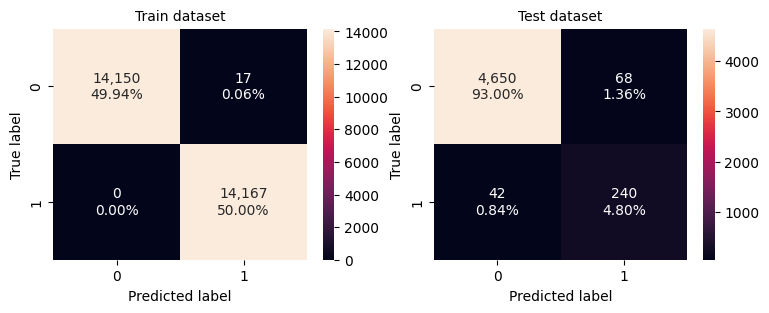

Model performance:


In [74]:
final_model_perf = model_performance(final_model,
                                     X_train_over, y_train_over,
                                     X_test, y_test)

* The **Recall** score of **85.11%** on the test data validates that the chosen model performs well in identifying true positive cases. This high recall performance confirms that the model is a good final model, suitable for deployment and further evaluations in real-world scenarios. By maintaining an acceptable recall performance on unseen data, the model demonstrates its effectiveness in generalizing to new instances, making it a reliable choice for the given task.

### Feature Importance

- The performance on test data is generalised
- Let's check the important features for prediction as per the the final model

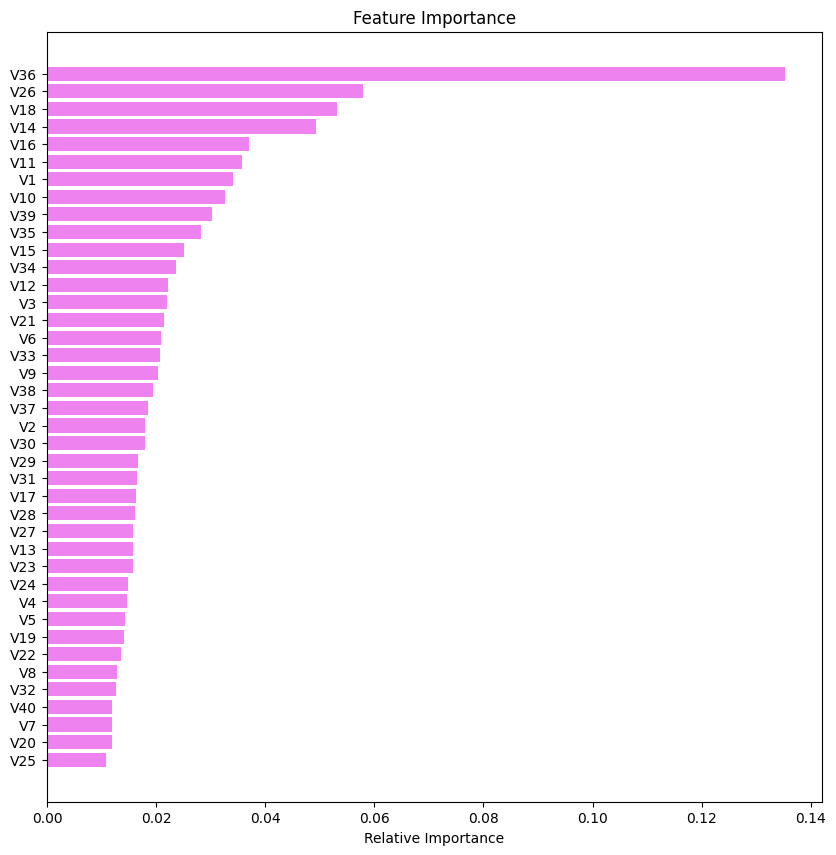

In [75]:
feature_names = X_train.columns
importances = (final_model.feature_importances_)
indices = np.argsort(importances)

plt.figure(figsize=(10, 10))
plt.title("Feature Importance")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


* V36 is the most important feature, followed by V26, V18, and V14.

## Pipelines to build the final model


Now that we have a final model, let's use pipelines to put the model into production. We know that we can use pipelines to standardize the model building, but the steps in a pipeline are applied to each and every variable.

In [76]:
# Getting the best params from the previous steps
print('Best params for XGBClassifier (oversampled):')
for e in best_params_final:
  print(f'\t{e}: {best_params_final[e]}')


Best params for XGBClassifier (oversampled):
	subsample: 0.8
	scale_pos_weight: 10
	n_estimators: 250
	learning_rate: 0.1
	gamma: 0


In [77]:
pipeline_model = Pipeline(
    [
        ('Imputer', 
         KNNImputer(n_neighbors=5)),
        ('Oversampler', 
         SMOTE(k_neighbors=5, sampling_strategy=1, random_state=42)),
        ('XGBClassifier', 
         XGBClassifier(subsample=0.8,
                       scale_pos_weight=10,
                       n_estimators=250,
                       learning_rate=0.1,
                       gamma=0,
                       random_state=42
                       )
         )
    ]
)

> Now we already know the best model we need to process with, so we don't need to divide data into 3 parts

In [78]:
# Separating target variable and other variables
X_train_final = train.drop('Target', axis=1)
y_train_final = train['Target']

X_test_final = test.drop('Target', axis=1)
y_test_final = test['Target']

In [79]:
print(X_train_final.shape, X_test_final.shape)
print(y_train_final.shape, y_test_final.shape)

(20000, 40) (5000, 40)
(20000,) (5000,)


In [80]:
# Training the pipeline on the training dataset
pipeline_model.fit(X_train_final, y_train_final)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('Oversampler', SMOTE(random_state=42, sampling_strategy=1)),
                ('XGBClassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=250,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

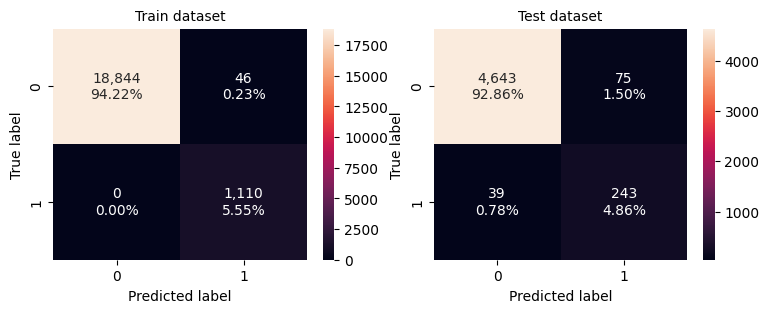

Model performance:


In [81]:
# Evaluating the pipeline on the test dataset
pipeline_model_perf_test = model_performance(pipeline_model, 
                                             X_train_final, y_train_final,
                                             X_test, y_test,
                                             verbose=True, sets=['Train', 'Test'])

- We trained the pipeline using the full training dataset, which yielded a slight increase in Recall but a small reduction in Precision on Test dataset when compared to the evaluation of the model that was previously trained on a preliminary dataset, where the original training data had been split into separate training and validation portions.

#Business Insights and Conclusions

* Minimizing **False Negatives** is vital because of their high associated cost. As a result, we should focus on models with strong Recall and F1 scores. After tuning, the best models were:
  - XGBClassifier with undersampled data,
  - GradientBoostingClassifier with undersampled data,
  - RandomForestClassifier with undersampled data.

* These models, trained on undersampled data, have high Recall but low Precision and F1 scores. This indicates a high Type I error rate, which means they produce many False Positive (FP) predictions. FPs are detections where no failure occurs, resulting in inspection costs.

* Although inspections are the least expensive operations, a high number of errors can still lead to significant overall costs. Additionally, resources needed for costlier operations, like replacement and repair, may be tied up in inspections. This could cause delays in urgent and important operations and additional expenses.

* Therefore, we need to find a balance between Recall and Precision. Unfortunately, we don't have specific information about the costs of various operations. We only know that repairing a generator is much cheaper than replacing it, and inspection costs are lower than repair costs.

* Among all evaluated models, the **XGBClassifier** with **oversampled** data achieved the best balance between Recall and F1 score after tuning, making it the recommended model for production.
  * This model also showed excellent performance on test data, with a strong **Recall of 85.11%** and an **F1 score of 81.36%**, indicating effective generalization.
  * On the test dataset, the pipeline achieves a Recall of 86.17% and an F1 score of 81% when trained on the entire training set.

* In conclusion, the best model seems to be the **XGBClassifier tuned with oversampled data**. It generalizes well on test data and has the best overall performance for both training and validation data.

* The top four important features are V36, V26, V18, and V14. It is recommended to further analyze each feature to understand the high number of outliers in the dataset.

* In addition, we have designed a pipeline that, when implemented in future scenarios, can decrease processing time and minimize the risk of human errors at every step of the process.

In [3]:
!jupyter nbconvert --to html /content/project_6_at.ipynb

[NbConvertApp] Converting notebook /content/project_6_at.ipynb to html
[NbConvertApp] Writing 5839228 bytes to /content/project_6_at.html


***